<a href="https://colab.research.google.com/github/RoyPoulami/X-axis-parameter-generation-Neurokit/blob/main/Version_2_1_New_Client_6_page_testing_code_Poulami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Client Access Block

In [ ]:
reset

# ***CLIENT ACCESS BLOCK***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.google/carditek-ecg
!cp /content/drive/MyDrive/Colaboratory/dot-google/client_secret.json ~/.google/carditek-ecg

%cd /content/drive/MyDrive/Colaboratory/dot-google/python-client-master/carditek/cloud/client
import buffer
import client

client = client.Client()

workspace ='/content/drive/My Drive/Colaboratory/Carditek TIFF Files/CAL_PULSE/'
background = '/content/drive/My Drive/Colaboratory/Carditek TIFF Files'
import sys; sys.path.append(workspace)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1q0cNRCNl-FiQ1sdRz_H4Qa7dtYD-81-B/Colaboratory/dot-google/python-client-master/carditek/cloud/client


# 2. Packages and functions

In [ ]:
!pip install pytz
!pip install condat-tv
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.signal import find_peaks


from pathlib import Path

import numpy as np
import random
import statistics as st
import pandas as pd
import statistics as st
import math
import scipy as sp
from PIL import Image, ImageDraw, ImageFont
from scipy import signal, fftpack
import datetime
from pytz import timezone
import condat_tv

%pip install scaleogram
import scaleogram as scg
from IPython.display import HTML
from subprocess import getoutput



from scipy.signal import hilbert, savgol_filter
import collections
from numpy import array, sign, zeros
from scipy.interpolate import interp1d

In [ ]:
## data loss correction ##
def data_loss(input_signal):
  for x in  range(1,len(input_signal)-1,1):    #### data loss
    if (input_signal[x] == 0):                   ## checks zero values in input signal and replaces with the mean of adjacent non zero values
      input_signal[x] = st.mean([input_signal[x-1], input_signal[x+1]])
  return (input_signal)

## time stamp ##
def get_time_from_timestamp(timestamp):           ## converting unit timestamp to a readable date and time format
  read_able = datetime.datetime.fromtimestamp(timestamp)
  now_asia = str(read_able.astimezone(timezone('Asia/Kolkata'))); #print(now_asia)
  year = now_asia[0:10]
  year = year[8:10]+"-"+year[5:7]+"-"+year[0:4]
  time = now_asia[11:19]
  return (year,time)

## function extracts values from a dictionary given a specific index ##
def Value_axis(data_dict,value):
  data=list(data_dict.items())
  an_array=np.array(data,dtype=object)
  Values_1=an_array[value]
  Values_2=np.asarray(Values_1[1])
  return Values_2

## R peak detection: Filters the input ECG lead data to enhance R-peaks for detection ##
def R_Peak_Detection_03(raw_data):
  peaks_up = []; amp = [];
  b = signal.firwin(1377, cutoff = [1/500], window = "hamming", pass_zero=False); a = 1
  h, g = signal.butter(4, [45/500] , btype='low', analog=False)
  filt_BW = signal.filtfilt(b, a, raw_data); data_F = signal.lfilter(h, g, filt_BW)
  data_D = np.diff(data_F); data_S = data_D*data_D
  peaks,rpeak = signal.find_peaks(data_S,distance = 400,height=(max(data_S[1000:5000])/4));n = len(peaks);

  for i in range(0,n):
    win=50;
    if (peaks[i]-(win))<0: start_win = 0
    else: start_win = (peaks[i]-(win))
    seg = data_F[start_win:(peaks[i])+(win)]; seg = seg*seg;
    max_peak,peak_amp = signal.find_peaks(seg, distance = 10, height = (max(seg)/2))
    if len(max_peak)<2 and max_peak.size!=0:          ##########Check y its equal to 0 in some patients
      peaks_u = start_win + max_peak[0];
    else: peaks_u = start_win + np.argmax(seg)
    peaks_up.append(peaks_u);
  peaks_up = peaks_up[1:len(peaks_up)-2]
  return peaks_up



## smoothening filter: Baseline filter+powerline noise+150 hz low pass filter ##
def ecg_filters_V5_smooth(lead_data,hp=0.67):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  for x in  range(1,len(lead_data),1):
      if (lead_data[x] == 0):
       lead_data[x] = lead_data[x-1]

 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [hp/500], window = "hamming", pass_zero=False); a = 1
  #b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter
  # h, g = signal.butter(2, [45/500] , btype='low', analog=False)
  h, g = signal.butter(2, [150/500] , btype='low', analog=False)
  j, i = signal.butter(2, [15/500] , btype='low', analog=False)

  filt_BW = signal.filtfilt(b, a, lead_data); filt_SM = (signal.lfilter(j, i, filt_BW))
  filt_LP = (signal.lfilter(h, g, filt_BW))

  sparse = filt_LP - filt_SM;
  denoise = condat_tv.tv_denoise(sparse,6.5)
  smooth_data = filt_SM+denoise

  return smooth_data

def baseline_filter(lead_data,hp=0.67):
 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [hp/500], window = "hamming", pass_zero=False); a = 1
  filt_BW = signal.filtfilt(b, a, lead_data);
  return filt_BW

def ecg_filters_V5_01(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  for x in  range(1,len(lead_data),1):
      if (lead_data[x] == 0):
       lead_data[x] = lead_data[x-1]

 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [1/500], window = "hamming", pass_zero=False); a = 1
  #b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter
  h, g = signal.butter(4, [45/500] , btype='low', analog=False)

  filt_BW = signal.filtfilt(b, a, lead_data)
  filt_50 = signal.lfilter(d, c, filt_BW); filt_100 = signal.lfilter(f, e, filt_50)
  filt_LP = signal.lfilter(h, g, filt_50)
  smoothed = signal.savgol_filter(filt_LP, window_length =29, polyorder = 3)
  return filt_LP



## Notch filter for removal of 22 Hz ##

def notch_filter(lead_data):
  notch_freq = 22
  quality_factor = 6.7
  b, a = signal.iirnotch(notch_freq, quality_factor, 1000); lead_data = signal.filtfilt(b, a, lead_data)   ## iir filter for sharp notch filter
  return lead_data

## Median filter for removal of Movement artifact ##

def filt2(data,BW = 101):
  Baseline = sp.signal.medfilt(data, kernel_size=BW)
  BW_Filtered = data - Baseline
  return BW_Filtered

## S peak finding code ##
def find_peaks_amplitudes(signal):
    s_peaks, _ = find_peaks(-signal, height=0.6, distance=100)
    s_amplitudes = signal[s_peaks]

    return s_peaks, s_amplitudes


############     ECTOPIC DETECTION
def bandpass(low, high, fs=1000, order=25):
    return sp.signal.butter(order, [low, high], fs=fs, btype='bandpass',
    #return sp.cheby1(4, 1, [low, high], btype='bandpass', analog=True,
    output='sos')

def ectopic_filters(signal):
  lead_data = data_loss(signal)
  Baseline = sp.signal.medfilt(lead_data, kernel_size=401)
  BW_Filtered = lead_data - Baseline
  sos = bandpass(0.5, 20,fs=1000, order=3)
  filtered = (sp.signal.sosfilt(sos, BW_Filtered))
  return filtered

def find_ectopic(signal):
  filtered1 = ectopic_filters(signal)
  peaks,rpeak = sp.signal.find_peaks(filtered1,distance = 400,height=(max(filtered1[1000:5000])/4))
  peaks = peaks[1:len(peaks)-1];peak_len = len(peaks) ## 1st and last peak removed to avoid incomplete beats/complex
  Ramp = Value_axis(rpeak,0); Ramp = Ramp[0:len(Ramp)-1]
  AUC = collections.deque(); RR_int = collections.deque();
  ##    LIST OF RR INTERVALS
  for i in range(1, len(peaks)):    RR_int.append(peaks[i]-peaks[i-1])
  ##    INDIVIDUAL COMPLEX EXTRACTION
  com_width = round(Fs//(8));
  ecg = np.zeros((peak_len,com_width*2)); start_p = np.empty([peak_len],dtype=int); end_p = np.empty([peak_len],dtype=int)
  for i in  range(peak_len):
    start_p[i] = peaks[i]-com_width; end_p[i] = peaks[i]+com_width
    ecg[i] = filtered1[start_p[i]:end_p[i]]
  ##   LIST OF AREA UNDER THE CURVE
  for j in ecg:
    area = np.trapz(j);
    AUC.append(area)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(peaks, dtype=float); PVC_list[:] = np.NaN
  SVC_list = np.empty_like(peaks, dtype=float); SVC_list[:] = np.NaN
  AUC = np.array(AUC)
  for i in range(1, len(RR_int)):
    if len(AUC[0:i-1])!=0: medAUC = st.median(AUC[0:i-1])
    else: medAUC= AUC[0]
    if RR_int[i]>=(1.5*RR_int[i-1]):
      if Ramp[i]>=(Ramp[i-1]+(0.2*Ramp[i-1])):#PVC
        if AUC[i]>medAUC:
          PVC_list[i] = peaks[i]
      else: #SVC or PVC
        if AUC[i]>1.3*medAUC:
          PVC_list[i] = peaks[i]
        elif AUC[i]<=1.3*medAUC: # less area undercurve
          SVC_list[i] = peaks[i]
  return SVC_list, PVC_list

## QRS segment smoothening filter: 3 to 25 Hz bandpass ##
def ecg_filters_Smooth_QRS(lead_data,Fs=1000):
  d,c = sp.signal.butter(7, [25/(Fs/2)] , btype='low', analog=False)
  b,a = signal.butter(5, [3/(Fs/2)] , btype='high', analog=False)
  f, e = signal.iirnotch(50, 10, Fs)
  h, g = signal.butter(1, [30/500] , btype='low', analog=False)
  j, i = signal.butter(1, [3/500] , btype='low', analog=False)

  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  filt_50 = sp.signal.lfilter(f, e, filt_BW)
  filt_SM = (signal.lfilter(j, i, filt_50))
  filt_LP = (signal.lfilter(h, g, filt_50))

  sparse = filt_LP - filt_SM;
  denoise = condat_tv.tv_denoise(sparse,7.65)
  smooth_data = filt_BW+denoise
  return filt_50

# Function for average interval calculation by neglecting nan elements
def avg_intervalcalculation(start_pt,stop_pt):
  count=0;interval_average=0
  for d in range(0,min(len(start_pt),len(stop_pt))):
    if np.isnan(start_pt[d])!=True and np.isnan(stop_pt[d])!=True:
      interval_average=interval_average+(stop_pt[d]-start_pt[d])
      count=count+1
  interval_average=interval_average/count
  return(interval_average)

## X parameter filter ##
def ecg_filters_Xparameter(lead_data):
  d, c = sp.signal.butter(3, [45/500] , btype='low', analog=False)
  #d = signal.firwin(511, cutoff = [150/500], window = "hamming", pass_zero=True); a = 1
  b = sp.signal.firwin(1735, cutoff = [0.8/500], window = "hamming", pass_zero=False); a = 1
  #b, a = sp.butter(5, [0.5/500] , btype='high', analog=False)
  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  filt_45 = sp.signal.lfilter(d, c, filt_BW)
  return filt_45


#------------- Diastolic Dysfunction -------------#
def ecgplot_DD(ax,data,x):
  ax.plot(data*(-1))
  ax.set_ylim([-10.2,10]); ax.grid(True);
  ax.set_yticklabels([]); ax.set_xticklabels([]);
  ax.title.set_text(x);ax.set_xlim(5000,7000);

def scalogram_DD(ax, data, x):
  cws_data = data[5000:7000]
  scg.set_default_wavelet('gaus1')
  # scg.cws(cws_data, ax=ax, cmap="jet", cbar=None, spectrum='amp',coi = False, ylabel="Period", xlabel="Time in ms");
  scg.cws(cws_data, ax=ax, cmap="jet", cbar=None, spectrum='power',coi = False, ylabel="Period", xlabel="Time in ms");
  ax.title.set_text(x)

# ---------------------QRS Scalogram--------------------#
def ecgplot(ax,data,x):
  ax.plot(data*(-1))
  # ax.set_ylim([-10.2,10]);
  ax.grid(True);
  ax.set_yticklabels([]); ax.set_xticklabels([]);
  ax.title.set_text(x);ax.set_xlim(x1,x2);

def scalogram_qrs(ax, data, x):
  cws_data = data[x1:x2]
  scg.set_default_wavelet('morl')
  scg.cws(cws_data, ax=ax, cmap="jet", cbar=None, coi = False, ylabel="Period", xlabel="Time in ms");
  # scg.cws(cws_data, ax=ax, cmap="gray",coi = False, ylabel="Period", xlabel="Time in ms");
  ax.title.set_text(x)

#------------- Reading Multiple Timestamps ----------------#
def read_ECG(start_timestamp, MAC, read='all'):
  ts=start_timestamp
  lead1=collections.deque(); lead2=collections.deque(); lead3=collections.deque()
  v1_lead=collections.deque(); v2_lead=collections.deque(); v3_lead=collections.deque();
  v4_lead=collections.deque(); v5_lead=collections.deque(); v6_lead=collections.deque();
  tscount=0; skip=0; Tmax=0
  bufferloop = {}; fra = {}; buffer = client.fetch(MAC,(start_timestamp)); frame =  buffer.frame
  Patient_name=buffer.patient_name; Phone_number=buffer.patient_phone
  if read=='all': end=True; read=False
  else: end=0
  while end!=read:
    bufferloop = {}; fra = {}; buffer = client.fetch(MAC,(ts));
    if buffer != None:
      # Patient_name=buffer.patient_name; Phone_number=buffer.patient_phone
      if (buffer.patient_name==Patient_name) and (buffer.patient_phone==Phone_number):
        frame=buffer.frame; #print(Tmax, Patient_name, MacId, ts)
        data1=frame.i; data2=frame.ii; data3=frame.v1; data4=frame.v2;
        data5=frame.v3; data6=frame.v4; data7=frame.v5; data8=frame.v6
        # print(start_timestamp+(15*Tmax));
        if (Tmax%3)!=0:
          for i in range(len(data1)):
            lead1.append(data1[i]); lead2.append(data2[i]); v1_lead.append(data3[i]); v2_lead.append(data4[i]);
            v3_lead.append(data5[i]); v4_lead.append(data6[i]); v5_lead.append(data7[i]); v6_lead.append(data8[i])
        ts=ts+15; c=0; Tmax +=1
        if isinstance(end, int)==True: end+=1
    elif skip<=10:
      ts=ts+15; skip=skip+1; #print("skip",skip)
    else:
      print("End of patient data")
      break;
  print("Number of Timestamps read : ",int(len(lead1)/15000))
  Patient_det = [Patient_name, Phone_number]
  lead2 = np.array(lead2); lead1 = np.array(lead1);
  lead3 = lead2-lead1 ; avr_lead = -(lead2+lead1)/2; avl_lead = lead1-(lead2/2); avf_lead = lead2-(lead1/2);
  lead_frame = pd.DataFrame(list(zip(lead1,lead2,lead3,avr_lead,avl_lead, avf_lead,v1_lead,v2_lead,v3_lead,v4_lead,v5_lead,v6_lead)),
                            columns =['Lead_1','Lead_2','Lead_3','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'], dtype = float)
  return Patient_det, lead_frame

#------------- Rhythm regularity ----------------#
def Rhythm_Check(lead_data):
  b = sp.signal.firwin(1735, cutoff = [3/500], window = "hamming", pass_zero=False); a = 1 ;  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  d, c = sp.signal.butter(15, [35/500] , btype='low', analog=False); filtered = sp.signal.lfilter(d, c, filt_BW);filtered = filtered*filtered;
  peaks,rpeak = sp.signal.find_peaks(filtered,distance = 400,height=(max(filtered[1000:5000])/4))
  RR_int = []
  for j in range (0,len(peaks)-1):
    diff = (peaks[j+1]) - (peaks[j])
    RR_int.append(diff)
  st_dev = np.std(RR_int)
  if (st_dev<90):
    return("Regular Rhythm"); print('Regular Rhythm','go')
  else:
    return("Irregular Rhythm"); print('Irregular Rhythm','ro')




#------------- Heart Rate Variability -------------#
def RR_calculation_Testing(inputframe):
  peaks, info = nk.ecg_peaks(inputframe, sampling_rate=Fs)
  R_peak=peaks.ECG_R_Peaks; peak=[]
  for k in range(len(R_peak)):
    peak.append(R_peak[k])
  df = pd.DataFrame.from_dict(info); #print(df)
  peaklocations = df.ECG_R_Peaks; IntRR=np.empty(len(peaklocations)-1)
  for i in range(1,len(peaklocations)):

    ch = peaklocations[i]-peaklocations[i-1]
    if ch<2000: IntRR[i-1] = ch;
  for j in range(0,len(IntRR)-1):
    if IntRR[j]<=500: IntRR[j]=st.mean([IntRR[j-1],IntRR[j+1]])
  return (peak, IntRR,peaks)

def HRV_calc_Testing(input_signal):
  RR_data = RR_calculation_Testing(input_signal)
  timeaxis=[]; count=0; DIFFRR=[]
  peak=RR_data[0]; RR_interval=RR_data[1]
  for i in range(len(peak)):
    if peak[i]==0: count=count+1;
    else: timeaxis.append(count/1000);
  timeaxis = timeaxis[1:len(timeaxis)]
  newRR=[]; MeanRR = np.mean(RR_interval)
  for i in range(1,len(RR_interval)):
    if RR_interval[i]<(MeanRR+200) and RR_interval[i]>(MeanRR-200):
      newRR.append(RR_interval[i])
  # print(RR_interval);
  SDNN = st.pstdev(RR_interval); #print("SDNN",SDNN)
  for k in range(1,len(RR_interval)):
    ch= RR_interval[k]-RR_interval[k-1]; DIFFRR.append(ch)
  RMSSD = np.sqrt(np.mean(np.square(DIFFRR))); #print("RMSSD:",RMSSD)
  return (timeaxis,newRR, [SDNN, RMSSD])

def HRV_plot(ax, input_lead):
  series, RR, index = HRV_calc_Testing(R_Peak_Detection_03(input_lead))
  HRV_title = ("HRV::  SDNN= %.0f, RMSSD= %.0f"%(index[0],index[1]))
  MeanRR = np.mean(RR)
  ax.title.set_text(HRV_title); ax.plot(series[0:len(RR)],RR,'k',marker='o',markerfacecolor='r',markersize=2, lw=0.75)
  ax.set_ylim([MeanRR-300,MeanRR+300])
  if np.max(series)>= 120: ax.set_xlim([0,120])
  else :ax.set_xlim([0,np.max(series)])
  ax.hlines(MeanRR, 0,200, 'orange', linestyles='--',lw=2)
  ax.set_xlabel("Time (sec)"); ax.set_ylabel("RR-Intervals (msec)")

def find_ectopic(signal):
  filtered1 = ectopic_filters(signal)
  peaks,rpeak = sp.signal.find_peaks(filtered1,distance = 400,height=(max(filtered1[1000:5000])/4))
  peaks = peaks[1:len(peaks)-1];peak_len = len(peaks) ## 1st and last peak removed to avoid incomplete beats/complex
  Ramp = Value_axis(rpeak,0); Ramp = Ramp[0:len(Ramp)-1]
  AUC = collections.deque(); RR_int = collections.deque();
  ##    LIST OF RR INTERVALS
  for i in range(1, len(peaks)):    RR_int.append(peaks[i]-peaks[i-1])
  ##    INDIVIDUAL COMPLEX EXTRACTION
  com_width = round(Fs//(8));
  ecg = np.zeros((peak_len,com_width*2)); start_p = np.empty([peak_len],dtype=int); end_p = np.empty([peak_len],dtype=int)
  for i in  range(peak_len):
    start_p[i] = peaks[i]-com_width; end_p[i] = peaks[i]+com_width
    ecg[i] = filtered1[start_p[i]:end_p[i]]
  ##   LIST OF AREA UNDER THE CURVE
  for j in ecg:
    area = np.trapz(j);
    AUC.append(area)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(peaks, dtype=float); PVC_list[:] = np.NaN
  SVC_list = np.empty_like(peaks, dtype=float); SVC_list[:] = np.NaN
  AUC = np.array(AUC)
  for i in range(1, len(RR_int)):
    if len(AUC[0:i-1])!=0: medAUC = st.median(AUC[0:i-1])
    else: medAUC= AUC[0]
    if RR_int[i]>=(1.5*RR_int[i-1]):
      if Ramp[i]>=(Ramp[i-1]+(0.2*Ramp[i-1])):#PVC
        if AUC[i]>medAUC:
          PVC_list[i] = peaks[i]
      else: #SVC or PVC
        if AUC[i]>1.3*medAUC:
          PVC_list[i] = peaks[i]
        elif AUC[i]<=1.3*medAUC: # less area undercurve
          SVC_list[i] = peaks[i]
  return SVC_list, PVC_list

def phasor_transform(signal, Rv):
  PT = np.empty_like(signal, dtype=float)
  for i in range(len(signal)):
    ch = signal[i]/Rv
    PT[i] = math.degrees(math.atan(ch))
    # PT[i] = Rv+ ()
  return(PT)
def find_PVC(signal, Rpeaks, Ramplitued, RRinterval):
  ##   LIST OF AREA UNDER THE CURVE
  AUC = collections.deque()
  for k in Rpeaks:
    ch=abs(np.trapz(signal[k-80:k+80]));AUC.append(ch)
    # print("median : ",ch, 1.3*st.median(AUC))
  AUC = np.array(AUC); #print(len(AUC),AUC)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(Rpeaks, dtype=float); PVC_list[:] = np.NaN
  SVC_list = np.empty_like(Rpeaks, dtype=float); SVC_list[:] = np.NaN
  for i in range(1,len(RRinterval)):
    if RRinterval[i]>=(1.5*RRinterval[i-1]):
      if Ramplitued[i]>=(Ramplitued[i-1]+(0.2*Ramplitued[i-1])):#PVC
        if AUC[i]>(1.3*st.median(AUC[0:i-1])):
          PVC_list[i] = Rpeaks[i]
      else: #SVC or PVC
        if i>1:
          if AUC[i]>(1.3*st.median(AUC[0:i-1])):
            PVC_list[i] = Rpeaks[i]
  return np.array(PVC_list)


def ecg_filters_Pwave(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
  ##### 150Hz Low pass filter
  h, g = sp.signal.butter(4, [40/500] , btype='low', analog=False); j, i = signal.butter(2, [15/500] , btype='low', analog=False)
  filt_50 = sp.signal.lfilter(d, c, lead_data); filt_100 = sp.signal.lfilter(f, e, filt_50)
  filt_LP = sp.signal.lfilter(h, g, filt_50)
  smoothed = sp.signal.savgol_filter(filt_LP, window_length =19, polyorder = 3)
  n=41; baseline_wander=sp.signal.medfilt(smoothed,kernel_size=n);
  return baseline_wander

def P_Detection(rawECG, R_peaks, RRint, Ramp):
  Filt_ECG = ecg_filters_V5_smooth(rawECG)
  peaks = R_peaks;

  PVC = find_PVC(Filt_ECG, peaks, Ramp, RRint)
  PT_pwave = phasor_transform(ecg_filters_Pwave(rawECG), Rv=0.05)
  P_st =[]; P_sp =[]; loc = []; Pamp = []
  P_location = []; Pst = []; Psp = []
  for k in range(0,len(peaks)):
    if k==0:  # 1st P-peak detection
      win_1 = len(Filt_ECG[0:peaks[0]]) ; #print(win_1)
      if win_1>300:
        win_st = peaks[0]-300; win_sp = peaks[0]-80
        ch = np.max(PT_pwave[peaks[0]-300:peaks[0]-80]);
      elif win_1<=300 and win_1>=80:
        win_st = 0; win_sp = peaks[0]-80
        ch = np.max(PT_pwave[0:peaks[0]-80]);
      elif win_1<80:
        P_location.append(math.nan); win_st = math.nan; win_sp = math.nan
        break;
    elif k>0 and k<len(peaks)-1: # Second to Last but 1 peak
      win_st = int(peaks[k]-(0.4*RRint[k])); win_sp = int(peaks[k]-(0.05*(RRint[k]-100))); #print(win_st,win_sp)
      ch = np.max(PT_pwave[win_st:win_sp]);
    else: # Last peak
      win_st = int(peaks[k]-(0.4*RRint[k-1])); win_sp = int(peaks[k]-(0.05*(RRint[k-1]-100))); #print(win_st,win_sp)
      ch = np.max(PT_pwave[win_st:win_sp]);
    loc_ch = (np.where(PT_pwave==ch)); loc_ch = loc_ch[0];
    if loc_ch[0]<80: loc_st=loc_ch[0]
    else: loc_st = loc_ch[0]-80
    ix = np.max(Filt_ECG[loc_st:loc_ch[0]+80]); loc_ch = (np.where(Filt_ECG==ix)); loc_ch = loc_ch[0];
    loc.append(loc_ch[0]); Pamp.append(np.abs(Filt_ECG[loc_ch[0]]))
    P_st.append(win_st); P_sp.append(win_sp)

    for m in range(0,len(RRint)):
    #print(m)
      if np.isnan(PVC[m])==True and Pamp[m]>(0.5*Filt_ECG[peaks[m]]):    #Beat Not a PVC: retain P loc
        P_location.append(loc[m])
      Pst.append(P_st[m]); Psp.append(P_sp[m])
      '''if m>1 and (RRint[m]>(1.6*RRint[m-1])):    #Beat not 1st and RR > 1.6*prevRR :: check dissosiated P wave
        win_st = int(peaks[m]+400); win_sp = int(loc[m+1]-400);
        print(m, win_st, win_sp)
        ch = np.max(PT_pwave[win_sp:win_st]); loc_ch = (np.where(PT_pwave==ch)); loc_ch = loc_ch[0];
        ix = np.max(Filt_ECG[loc_ch[0]-80:loc_ch[0]+80]); loc_ch = (np.where(Filt_ECG==ix)); loc_ch = loc_ch[0];
        amp = np.abs(Filt_ECG[loc_ch[0]])
        if amp>(0.05*Filt_ECG[peaks[m]]):    #Pamp>0.05*QRS amp: Dissosiated P detected
          P_location.append(loc_ch[0]); Pamp = np.insert(Pamp, m, (Filt_ECG[loc_ch[0]]))
          Pst.append(win_st); Psp.append(win_sp)'''

# def T_Wave_Filter(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
#   b = signal.firwin(2377, cutoff = [1.5/500], window = "hamming", pass_zero=False); a = 1
#   h, g = signal.butter(4, [5/500] , btype='low', analog=False)
#   filt_BW = signal.filtfilt(b, a, lead_data)
#   filt_LP = signal.lfilter(h, g, filt_BW)
#   return filt_LP

def ecg_filters_Twave(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
  ##### 150Hz Low pass filter
  h, g = sp.signal.butter(4, [20/500] , btype='low', analog=False)
  j, i = signal.butter(2, [15/500] , btype='low', analog=False)
  filt_50 = sp.signal.lfilter(d, c, lead_data); #filt_100 = sp.signal.lfilter(f, e, filt_50)
  filt_LP = sp.signal.lfilter(h, g, filt_50)
  smoothed = sp.signal.savgol_filter(filt_LP, window_length =19, polyorder = 3)
  n=41; baseline_wander=sp.signal.medfilt(smoothed,kernel_size=n);
  return baseline_wander


def T_Detection(raw_signal, R_peaks, RRint):
  Filt_ECG = ecg_filters_V5_smooth(raw_signal)
  T_filt = ecg_filters_Twave(raw_signal)
  PT_twave = phasor_transform(T_filt, Rv=0.1)
  T_st =[]; T_sp =[]; T_loc = []; Tamp = []
  for k in range(0,len(R_peaks)):
    if k==len(R_peaks)-1:
      win_st = int(R_peaks[k]+(0.16*RRint[k-1]));  win_sp = int(R_peaks[k]+(0.57*(RRint[k-1]))); #print(win_st,win_sp)
    elif k>0 and k<len(R_peaks)-1:
      win_st = int(R_peaks[k]+(0.16*RRint[k])); win_sp = int(R_peaks[k]+(0.57*(RRint[k]))); #print(win_st,win_sp)
    else:
      win_st = int(R_peaks[k]+(0.16*RRint[k+1])); win_sp = int(R_peaks[k]+(0.57*(RRint[k+1]))); #print(win_st,win_sp)
    ch = np.max(PT_twave[win_st:win_sp]); loc_ch = (np.where(PT_twave==ch)); loc_ch = loc_ch[0];
    # print("window :",loc_ch[0]-80,loc_ch[0]+80)
    ix = np.max(Filt_ECG[loc_ch[0]-80:loc_ch[0]+80]); loc_ch = (np.where(Filt_ECG==ix)); loc_ch = loc_ch[0];
    T_loc.append(loc_ch[0]); Tamp.append(np.abs(Filt_ECG[loc_ch[0]]))
    T_st.append(win_st); T_sp.append(win_sp)
  return (np.array(T_loc))




def detect_qrs_onset_offset(r_location, r_peak_ecg_signal, onset_window=50, offset_window=50):
    qrs_onset = []
    qrs_offset = []

    for m in range(len(r_location)):
        # QRS Onset
        loc = r_location[m] - onset_window
        R_peak = r_peak_ecg_signal[loc]
        R_prev = r_peak_ecg_signal[loc - 1]
        count = 1

        while R_peak > R_prev:
            R_peak = r_peak_ecg_signal[loc - count]
            R_prev = r_peak_ecg_signal[loc - count - 1]
            count = count + 1

        qrs_onset.append(loc - count)

        # QRS Offset
        loc2 = r_location[m] + offset_window
        R_on = r_peak_ecg_signal[loc2]
        R_end = r_peak_ecg_signal[loc2 + 1]
        count = 1

        while R_on < R_end:
            R_on = r_peak_ecg_signal[loc2 + count]
            R_end = r_peak_ecg_signal[loc2 + 1 + count]
            count = count + 1

        qrs_offset.append(loc2 + count)

    return qrs_onset, qrs_offset


def calculate_pr_interval(r_location, qrs_onset, ecg_signal, offset_value=80):
    r_loc_new = np.empty(len(r_location), dtype=int)
    pr_array = np.empty(len(r_location))

    for v in range(len(r_location)):
        r_loc_new[v] = r_location[v] - offset_value
        pr_array[v] = np.mean(ecg_signal[(r_loc_new[v]):(qrs_onset[v])])

    return r_loc_new, pr_array

def calculate_mode(pr_array):
    mode_value = st.mode(pr_array)
    return mode_value

def calculate_new_qrs_onset_offset(r_location, r_peak_ecg_signal, mode_value, offset_before=50, offset_after=50):
    new_qrs_onset = []
    new_qrs_offset = []

    for a in range(len(r_location)):
        loc = r_location[a] - offset_before
        r_peak = r_peak_ecg_signal[loc]
        r_prev = r_peak_ecg_signal[loc - 1]
        count = 1
        while r_peak > r_prev > mode_value:
            r_peak = r_peak_ecg_signal[loc - count]
            r_prev = r_peak_ecg_signal[loc - count - 1]
            count = count + 1
        new_qrs_onset.append(loc - count)

    for b in range(len(r_location)):
        loc2 = r_location[b] + offset_after
        r_on = r_peak_ecg_signal[loc2]
        r_end = r_peak_ecg_signal[loc2 + 1]
        count = 1
        while r_on < r_end < mode_value:
            r_on = r_peak_ecg_signal[loc2 + count]
            r_end = r_peak_ecg_signal[loc2 + 1 + count]
            count = count + 1
        new_qrs_offset.append(loc2 + count)

    return new_qrs_onset, new_qrs_offset


def find_PVC(signal, Rpeaks, Ramplitued, RRinterval):
  ##   LIST OF AREA UNDER THE CURVE
  AUC = collections.deque()
  for k in Rpeaks:
    ch=abs(np.trapz(signal[k-80:k+80]));AUC.append(ch)
    # print("median : ",ch, 1.3*st.median(AUC))
  AUC = np.array(AUC); #print(len(AUC),AUC)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(Rpeaks, dtype=float); PVC_list[:] = np.NaN
  SVC_list = np.empty_like(Rpeaks, dtype=float); SVC_list[:] = np.NaN
  for i in range(1,len(RRinterval)):
    if RRinterval[i]>=(1.5*RRinterval[i-1]):
      if Ramplitued[i]>=(Ramplitued[i-1]+(0.2*Ramplitued[i-1])):#PVC
        if AUC[i]>(1.3*st.median(AUC[0:i-1])):
          PVC_list[i] = Rpeaks[i]
      else: #SVC or PVC
        if i>1:
          if AUC[i]>(1.3*st.median(AUC[0:i-1])):
            PVC_list[i] = Rpeaks[i]
  return np.array(PVC_list)

def ecg_filters_Pwave(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
  ##### 150Hz Low pass filter
  h, g = sp.signal.butter(4, [40/500] , btype='low', analog=False); j, i = signal.butter(2, [15/500] , btype='low', analog=False)
  filt_50 = sp.signal.lfilter(d, c, lead_data); filt_100 = sp.signal.lfilter(f, e, filt_50)
  filt_LP = sp.signal.lfilter(h, g, filt_50)
  smoothed = sp.signal.savgol_filter(filt_LP, window_length =19, polyorder = 3)
  n=41; baseline_wander=sp.signal.medfilt(smoothed,kernel_size=n);
  return baseline_wander

def ecg_filters_Pwave(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
  ##### 150Hz Low pass filter
  h, g = sp.signal.butter(4, [40/500] , btype='low', analog=False); j, i = signal.butter(2, [15/500] , btype='low', analog=False)
  filt_50 = sp.signal.lfilter(d, c, lead_data); filt_100 = sp.signal.lfilter(f, e, filt_50)
  filt_LP = sp.signal.lfilter(h, g, filt_50)
  smoothed = sp.signal.savgol_filter(filt_LP, window_length =19, polyorder = 3)
  n=41; baseline_wander=sp.signal.medfilt(smoothed,kernel_size=n);
  return baseline_wander

def P_Detection(rawECG, R_peaks, RRint, Ramp):
  Filt_ECG = ecg_filters_V5_smooth(rawECG)
  peaks = R_peaks;

  PVC = find_PVC(Filt_ECG, peaks, Ramp, RRint)
  PT_pwave = phasor_transform(ecg_filters_Pwave(rawECG), Rv=0.05)
  P_st =[]; P_sp =[]; loc = []; Pamp = []
  P_location = []; Pst = []; Psp = []
  for k in range(0,len(peaks)):
    if k==0:  # 1st P-peak detection
      win_1 = len(Filt_ECG[0:peaks[0]]) ; #print(win_1)
      if win_1>300:
        win_st = peaks[0]-300; win_sp = peaks[0]-80
        ch = np.max(PT_pwave[peaks[0]-300:peaks[0]-80]);
      elif win_1<=300 and win_1>=80:
        win_st = 0; win_sp = peaks[0]-80
        ch = np.max(PT_pwave[0:peaks[0]-80]);
      elif win_1<80:
        P_location.append(math.nan); win_st = math.nan; win_sp = math.nan
        break;
    elif k>0 and k<len(peaks)-1: # Second to Last but 1 peak
      win_st = int(peaks[k]-(0.4*RRint[k])); win_sp = int(peaks[k]-(0.05*(RRint[k]-100))); #print(win_st,win_sp)
      ch = np.max(PT_pwave[win_st:win_sp]);
    else: # Last peak
      win_st = int(peaks[k]-(0.4*RRint[k-1])); win_sp = int(peaks[k]-(0.05*(RRint[k-1]-100))); #print(win_st,win_sp)
      ch = np.max(PT_pwave[win_st:win_sp]);
    loc_ch = (np.where(PT_pwave==ch)); loc_ch = loc_ch[0];
    if loc_ch[0]<80: loc_st=loc_ch[0]
    else: loc_st = loc_ch[0]-80
    ix = np.max(Filt_ECG[loc_st:loc_ch[0]+80]); loc_ch = (np.where(Filt_ECG==ix)); loc_ch = loc_ch[0];
    loc.append(loc_ch[0]); Pamp.append(np.abs(Filt_ECG[loc_ch[0]]))
    P_st.append(win_st); P_sp.append(win_sp)

  # print("Pamp temp :", len(Pamp), Pamp);  print("Ploc temp :", len(loc), loc)

  for m in range(0,len(RRint)):
    #print(m)
    if np.isnan(PVC[m])==True and Pamp[m]>(0.5*Filt_ECG[peaks[m]]):    #Beat Not a PVC: retain P loc
      P_location.append(loc[m])
      Pst.append(P_st[m]); Psp.append(P_sp[m])
      '''if m>1 and (RRint[m]>(1.6*RRint[m-1])):    #Beat not 1st and RR > 1.6*prevRR :: check dissosiated P wave
        win_st = int(peaks[m]+400); win_sp = int(loc[m+1]-400);
        print(m, win_st, win_sp)
        ch = np.max(PT_pwave[win_sp:win_st]); loc_ch = (np.where(PT_pwave==ch)); loc_ch = loc_ch[0];
        ix = np.max(Filt_ECG[loc_ch[0]-80:loc_ch[0]+80]); loc_ch = (np.where(Filt_ECG==ix)); loc_ch = loc_ch[0];
        amp = np.abs(Filt_ECG[loc_ch[0]])
        if amp>(0.05*Filt_ECG[peaks[m]]):    #Pamp>0.05*QRS amp: Dissosiated P detected
          P_location.append(loc_ch[0]); Pamp = np.insert(Pamp, m, (Filt_ECG[loc_ch[0]]))
          Pst.append(win_st); Psp.append(win_sp)'''

  P_location = loc
  P_onset=[]; #print("P location : ",P_location)
  # print("Pst :", Pst); print("Psp :",Psp)
  for m in range(len(P_location)):
    loc= P_location[m]
    P_on = Filt_ECG[loc-20]; prev = Filt_ECG[loc-20-1]; Count=1
    while P_on>prev:
      P_on = Filt_ECG[loc-20-Count]; prev = Filt_ECG[loc-20-Count-1]; Count=Count+1
    P_onset.append(loc-Count);
  return (P_location, Pamp, P_onset)

def calculate_p_offset_p_duration_and_average_pr(p_loc, r_peak_ecg_signal, qrs_onset, window_size=60):
    p_offset = []
    p_duration = []
    pr_differences = []

    for n in range(len(p_loc)):
        loc2 = p_loc[n] + window_size
        p_start = r_peak_ecg_signal[loc2]
        p_off = r_peak_ecg_signal[loc2 + 1]
        count = 1

        while p_start < p_off:
            p_start = r_peak_ecg_signal[loc2 + count]
            p_off = r_peak_ecg_signal[loc2 + 1 + count]
            count = count + 1

        p_offset.append(loc2 + count)
        p_duration.append(qrs_onset[n] - (p_loc[n] - count))
        pr_differences.append(qrs_onset[n] - (loc2 + count))

    average_p_duration = np.mean(np.subtract(p_offset, p_loc))
    average_pr = np.mean(pr_differences)+80
    if average_pr<80:
      average_pr=average_pr+100
    if average_pr<0:
      average_pr=average_pr+150

    return p_offset, p_duration, average_pr

def calculate_t_offset_qt_and_qtc_duration(t_loc, r_peak_ecg_signal, qrs_onset, average_rr_interval, heart_rate):
    t_offset = []

    for o in range(len(t_loc)):
        location = t_loc[o]
        t_start = r_peak_ecg_signal[location]
        t_off = r_peak_ecg_signal[location + 1]
        count = 1

        while t_start < t_off:
            t_start = r_peak_ecg_signal[location + count]
            t_off = r_peak_ecg_signal[location + 1 + count]
            count = count + 1

        t_offset.append(location + count + 100)

    qt_difference = np.subtract(t_offset, qrs_onset)
    average_qt = np.mean(qt_difference) ##### adjust here

    if average_qt <= (average_rr_interval / 2):
        print(f"Average QT: {average_qt}")
    else:
        print("Prolonged QT Interval")

    qtc_duration = int(average_qt + 1.75 * (heart_rate - 60))

    if qtc_duration <= (average_rr_interval / 2):
        print(f"QTc Duration: {qtc_duration}")
    else:
        print("Prolonged QTc Interval")

    return t_offset, qt_difference, average_qt, qtc_duration




# Generation of 12 LEAD ECG
1. manual adding: trial ID, name, gender, age , time stamp and Mac ID
2. Leads through version 5.2 smoothening filter
3. R peak detection from peak detection code

4. Selecting a clear lead(manually) for X axis parameter calculation and rhythm check
5. ECG signal lead through filter of 3 to 18 Hz (QRS complex detection)
6. QRS On and OFF detection and QRS duration calculation
7. Pon and Off marking from phasor code
8. Ton and Toff marking from Phasor code
9. X axis parameter printing (PR, QRS and QT duration)
10. Axis calculation
11. ECG Leads plotting: Manually check if all the leads are without baseline wander/if baseline wander is there remove it by median filter
12. Plotting 12 lead ECG, X axis parameter, axis change


# 4. ECG 12-Lead: UNDER DEVELOPMENT
QRS axis + Xparameters + ECG filter version 1.5


Regular Rhythm
distance_between_QRS_on_R_peak: 57.214285714285715
new_QRS_Duration: 110
PR_Duration: 76.71428571428571
Average QT: 426.2142857142857
QTc Duration: 440
QT_Duration: 426.2142857142857
QTc_Duration: 440
THETA =  88.0


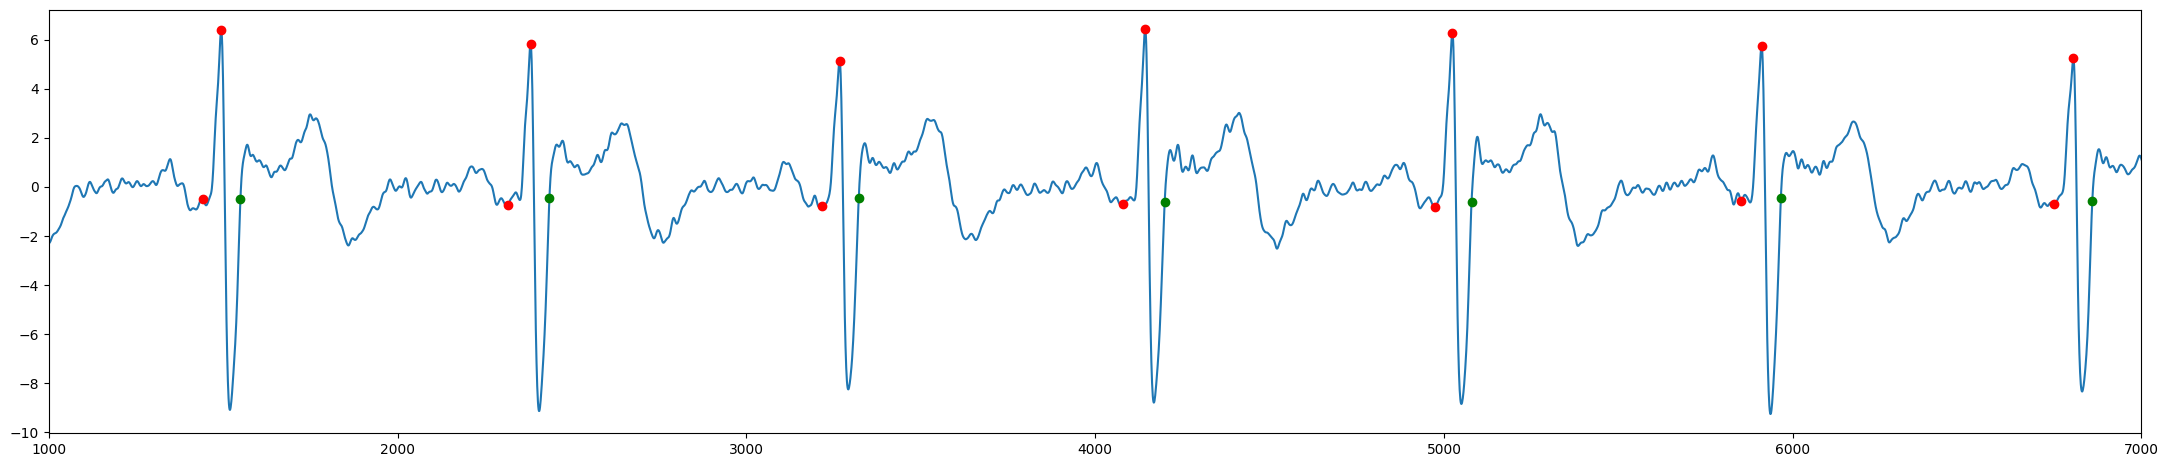

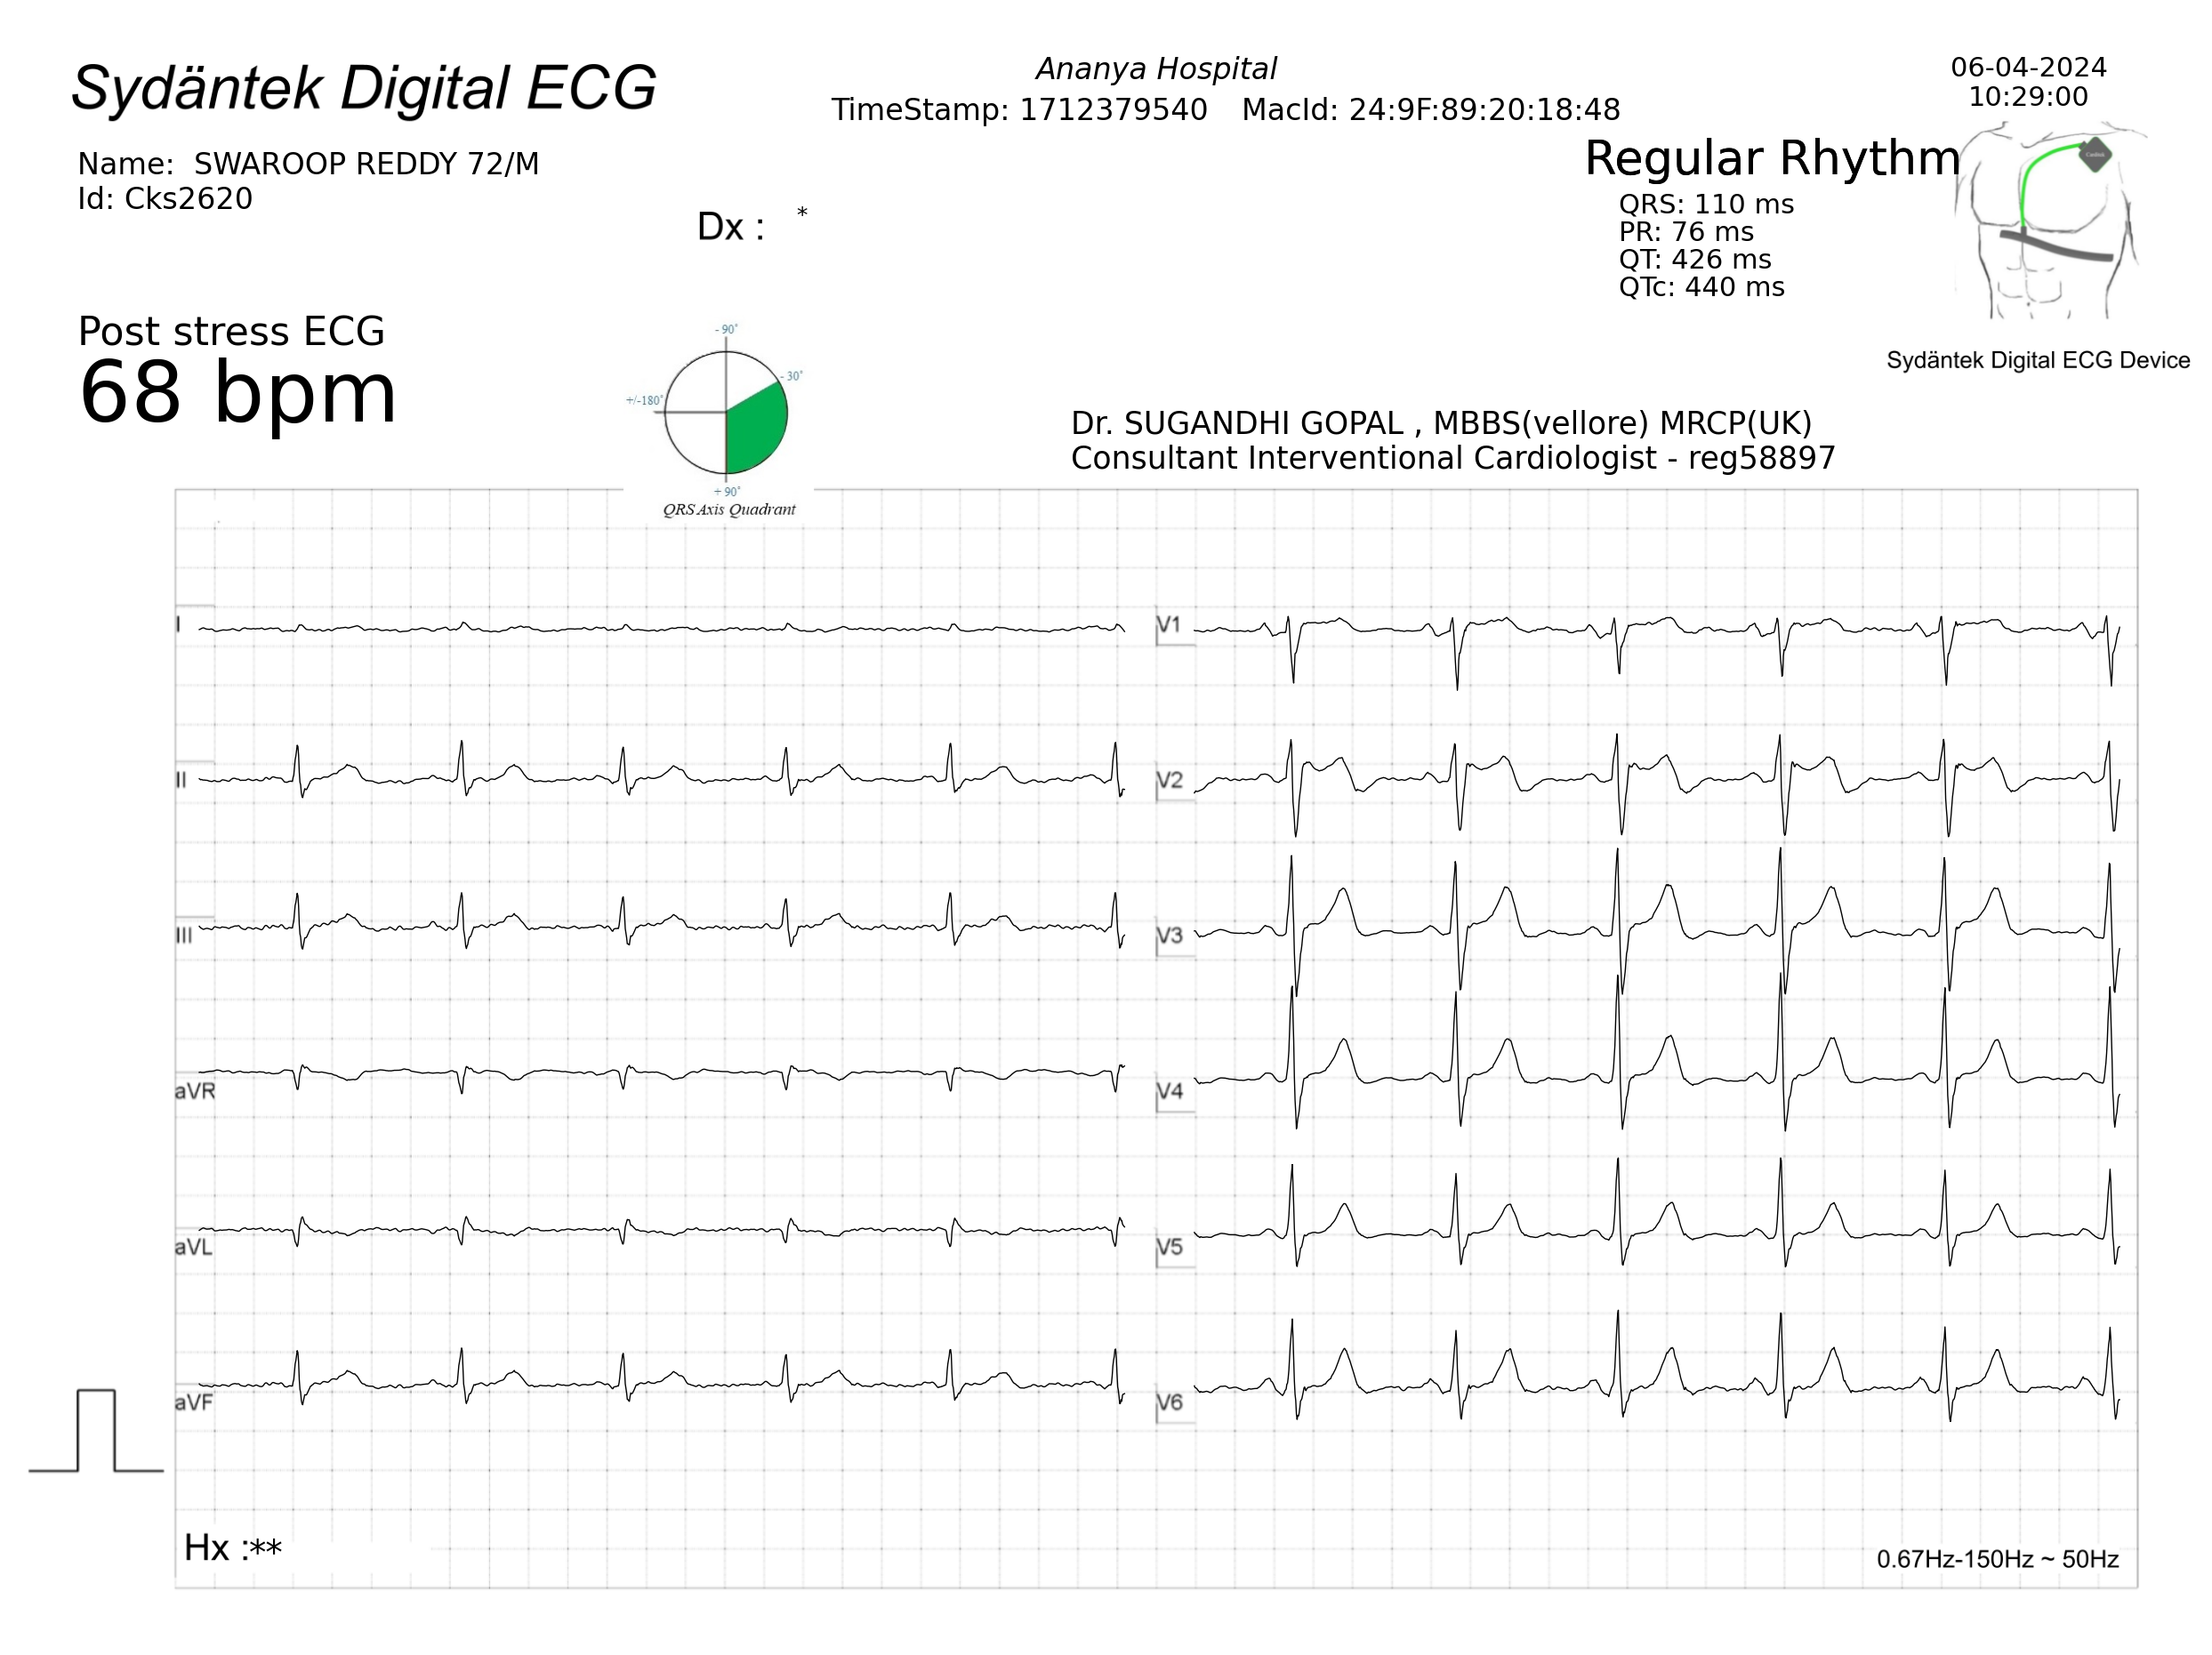

In [ ]:
Fs = 1000
BW = 1001 #int((Fs)-1)


#yvonne,72,F,984411027,,HFECG,ft,24:9F:89:20:18:24,1708575810


trialId ="Cks2620"
name = ' Swaroop Reddy'; name = name.upper()
age_gender ='72/M'
ts= 1712379540+(15*0)
date,time = get_time_from_timestamp(ts)
# macId ='E4:E1:12:C4:CD:C8'
macId ='24:9F:89:20:18:48'
His = 'Post stress ECG'
Dx='*'
Hx='**'
#####################################
# Patient_Details = ("Name :  %s  \nID :  %s \nAge and gender:  %s  \nTimestamp :  %d  \nMAC: %s\n%s"%(name,trialId,age_gender,ts,macId,His))
# Patient_Details = ("Name :  %s  \nID :  %s "%(name,trialId))
file_name = str(trialId)
###-----------------Starting Point of ECG Segment------------------------##
start = 500

buffer = client.fetch(macId,ts)
frame = buffer.frame;
Lead1 = frame.i; Lead2 = frame.ii; v1 = frame.v1*1.7; v2 = frame.v2; v3 = frame.v3; v4 = frame.v4; v5 = frame.v5; v6 = frame.v6*1.8 ##############    to add V6 enter V5 Here
# Lead2=notch_filter(Lead2)
# v2=v3-v1

## ------------------ Ectopic detection ------------------##
# Atrial_ectopic, Ventricular_ectopic = find_ectopic(Lead1);
# Atrial_ectopic = np.round(Atrial_ectopic/3.703); Ventricular_ectopic =np.round(Ventricular_ectopic/3.703);

##------------------------------Leads value: ADS value multiplied with resolution-------------------------------------##
# gain = 1.9;
gain = 1.2;


Lead1 = ((Lead1)*0.000286)*(-(gain)); Lead2 = ((Lead2)*0.000286)*(-(gain));
v1 = ((v1)*0.000286)*(-(gain));v2 = ((v2)*0.000286)*(-(gain));v3 = ((v3)*0.000286)*(-(gain));
v4 = ((v4)*0.000286)*(-(gain));v5 = ((v5)*0.000286)*(-(gain));v6 = ((v6)*0.000286)*(-(gain));

##--------------------------- Raw_data fetching and R peak detection---------------------------- ###
R_data=v2*(-1) #### change the lead here as required
R_peak_ecg_signal=ecg_filters_V5_01(R_data)
R_Location=R_Peak_Detection_03(R_data)
plt.figure(figsize=(27.0,5.5))
plt.plot(R_peak_ecg_signal)
plt.plot(R_Location,R_peak_ecg_signal[R_Location],'ro')

###--------------------------Heart Rate calculation---------------------------------- ###
R_amp =[]; RRint = [];
for i in range(0,len(R_Location)-1):
  ch=R_Location[i+1]-R_Location[i]; RRint.append(ch)
  R_amp.append(R_peak_ecg_signal[R_Location[i]])
  if i==(len(R_Location)-2):
    R_amp.append(R_peak_ecg_signal[R_Location[i+1]])
RR_int=np.array(RRint)
average_RR_interval=np.mean(RR_int)
Rhythm = Rhythm_Check(Lead2)
Heart_rate=int((60 * Fs) / average_RR_interval)
print(Rhythm)


##--------------------------QRS detection------------------------------###
QRS_Onset, QRS_Offset = detect_qrs_onset_offset(R_Location, R_peak_ecg_signal)
R_Loc_New, PR_Array = calculate_pr_interval(R_Location, QRS_Onset, R_peak_ecg_signal)
distance_between_QRS_on_R_peak=np.subtract(R_Location,QRS_Onset)
avg_distance_between_QRS_on_R_peak=np.mean(distance_between_QRS_on_R_peak)
print("distance_between_QRS_on_R_peak:",avg_distance_between_QRS_on_R_peak)
S_in_signal=find_peaks_amplitudes(R_peak_ecg_signal)
if S_in_signal==True:
  QRS_Offset= 2*(avg_distance_between_QRS_on_R_peak)
  new_QRS_difference=np.subtract(QRS_Offset,QRS_Onset)
  new_average_QRS=np.mean(new_QRS_difference);print("new_QRS_Duration:",int(new_average_QRS))
  plt.plot(QRS_Onset, R_peak_ecg_signal[QRS_Onset], 'ro')
  plt.plot(QRS_Offset, R_peak_ecg_signal[QRS_Offset], 'go')
  plt.xlim(1000,7000)
else:
    Mode_Value = calculate_mode(PR_Array)
    New_QRS_Onset, New_QRS_Offset = calculate_new_qrs_onset_offset(R_Location, R_peak_ecg_signal, Mode_Value)
    plt.plot(New_QRS_Onset, R_peak_ecg_signal[New_QRS_Onset], 'ro')
    plt.plot(New_QRS_Offset, R_peak_ecg_signal[New_QRS_Offset], 'go')
    plt.xlim(1000,7000)
    new_QRS_difference=np.subtract(New_QRS_Offset,New_QRS_Onset)
    new_average_QRS=np.mean(new_QRS_difference)
    print("new_QRS_Duration:",int(new_average_QRS))


##-----------------------------PR duration Calculation------------------------------##
PVC = find_PVC(R_data, R_Location, R_amp, RRint)
P_location, Pamp, P_onset=P_Detection(R_data, R_Location, RRint, R_amp)
P_Offset, P_Duration, Average_PR = calculate_p_offset_p_duration_and_average_pr(P_location, R_data, New_QRS_Onset)

print("PR_Duration:",  Average_PR)

##---------------------------------QT and QTc Calculation-----------------------------##
T_loc=T_Detection(R_peak_ecg_signal,R_Location , RRint)
T_Offset, QT_Difference, Average_QT, QTc_Duration = calculate_t_offset_qt_and_qtc_duration(T_loc,R_peak_ecg_signal , New_QRS_Onset,average_RR_interval , Heart_rate)
print("QT_Duration:",Average_QT);print("QTc_Duration:",QTc_Duration)

######-------------------------- Leads with Version 5 smoothing Filter-----------------------#####
# Leadv2=filt2(v2,BW=111)
# Lead2=notch_filter(Lead2)
# Lead2=filt2(Lead2,BW=101)
Lead1 = ecg_filters_V5_smooth(Lead1); Lead2 = ecg_filters_V5_smooth(Lead2);
Leadv1 = ecg_filters_V5_smooth(v1); Leadv2 = ecg_filters_V5_smooth(v2); Leadv3 = ecg_filters_V5_smooth(v3);
Leadv4 = ecg_filters_V5_smooth(v4); Leadv5 = ecg_filters_V5_smooth(v5); Leadv6 = ecg_filters_V5_smooth(v6);

####---------------------- Median filter to remove severe baseline --------------------######
# Lead3= notch_filter(Leadv6)
# Lead1=filt2(Lead1,BW=151)
# Lead2=filt2(Lead2,BW=151)
# Leadv1=filt2(Leadv1,BW=101)
# Leadv2=filt2(Leadv2,BW=101)
# Leadv3=filt2(Leadv3,BW=151)
# Leadv4=filt2(Leadv4,BW=101)
# Leadv5=filt2(Leadv5,BW=101)
# Leadv6=filt2(Leadv6,BW=101)
# Lead3 = Lead2-Lead1

# im = Image.open(Path(background,'Newbackground_3204x2403.jpeg'))
im = Image.open(Path('/content/drive/MyDrive/Colaboratory/Carditek TIFF Files/Standard_Calibration_background.png'))
# im = Image.open(Path('/content/drive/MyDrive/Colaboratory/Carditek TIFF Files/Half_Calibration_background.png'))
# gain = 1.2
# #####-------------------- Half calibration calculation-------------------------#####
# Calibration_status = "normal"
# LeadList = [Leadv1, Leadv2, Leadv3, Leadv4, Leadv5, Leadv6]
# for k in range(len(LeadList)):
#   amp= np.max(LeadList[k]);
#   print(k+1,amp)
#   if amp>=25 :
#     Calibration_status = "half"
#     break

# if Calibration_status == "half":
#   gain = gain/2;
#   im = Image.open(Path('/content/drive/MyDrive/Colaboratory/Carditek TIFF Files/Half_Calibration_background.png'))

# Lead1 = Lead1*gain;  Lead2 = Lead2*gain;  Leadv1 = Leadv1*gain; Leadv2 = Leadv2*gain; Leadv3 = Leadv3*gain;
# Leadv4 = Leadv4*gain; Leadv5 =Leadv5*gain ;Leadv6 = Leadv6*gain;




secs = len(Lead1)/Fs; samps = int(secs*270) ;
i = (sp.signal.resample(Lead1, samps));ii = (sp.signal.resample(Lead2, samps));v1 = (sp.signal.resample(Leadv1, samps));v2 = (sp.signal.resample(Leadv2, samps));
v3 = (sp.signal.resample(Leadv3, samps));v4 = (sp.signal.resample(Leadv4, samps));v5 = (sp.signal.resample(Leadv5, samps));v6 = (sp.signal.resample(Leadv6, samps));

end = start+1352;i = i[start:end]*10; ii = ii[start:end]*10; iii = ii - i;avr = -(ii+i)/2; avl = i-(ii/2); avf = ii-(i/2);
v1 = v1[start:end]*10; v2 = v2[start:end]*10;v3 = v3[start:end]*10;v4 = v4[start:end]*10;v5 = v5[start:end]*10; v6 = v6[start:end]*10;

# v2 = v2*2;
#v3 = avf; v4 = ii/0.7; v5 = ii/0.9; v6 = ii; ############################

i = (((i-1485))*(-1)); ii = (((ii-1268))*(-1)); iii = (((iii-1052))*(-1)); avr = (((avr-837))*(-1)); avl = (((avl-607))*(-1)); avf = (((avf-384))*(-1));
v1 = (((v1-1485))*(-1)); v2 = (((v2-1268))*(-1)); v3 = (((v3-1052))*(-1));v4 = (((v4-837))*(-1)); v5 = (((v5-607))*(-1)); v6 = (((v6-384))*(-1));

#------------------ Axis ------------------#
rloc1b,rpeak1b = sp.signal.find_peaks(Lead1, distance = 40, height = (max(Lead1) * 0.8));         sloc1b,speak1b = sp.signal.find_peaks((-1*Lead1), distance = 40, height = (max(Lead1)*0.7));
rloc3b,rpeak3b = sp.signal.find_peaks(Lead2, distance = 40, height = (max(Lead2) * 0.8));     sloc3b,speak3b = sp.signal.find_peaks((-1*Lead2), distance = 40, height = (max(Lead2)*0.7));
# print("rpeak1b:",rpeak1b)
##### DICTIONARY TO ND_ARRAY CONVERSION #####
rp1b = Value_axis(rpeak1b,0);      sp1b = Value_axis(speak1b,0);
# print("rp1b:",rpeak1b)
rp3b = Value_axis(rpeak3b,0);      sp3b = Value_axis(speak3b,0);
rp1b = np.average(rp1b);     rp1b = round(rp1b,1);     sp1b = np.average(sp1b);         sp1b = round(sp1b,1);      #Lead 1
rp3b = np.average(rp3b);     rp3b = round(rp3b,1);     sp3b = np.average(sp3b);         sp3b = round(sp3b,1);      #aVF
#############################     LEAD 1    ##############################
if(np.isnan(rp1b) == False and np.isnan(sp1b) == True):       # R and no S present
  sp1b = 0.0; R1b = rp1b;
elif(np.isnan(rp1b) == True and np.isnan(sp1b) == False):      # no R and S present
  columnB = 4; R1b = -(sp1b);
elif(np.isnan(rp1b) ==True and np.isnan(sp1b) == True):    # no R and no S present
  rp1a = 0.0; sp1a = 0.0; R1b = 0.0;
elif(np.isnan(rp1b) == False and np.isnan(sp1b) == False):    # R and S present
  R1b = (rp1b)-(sp1b);
#############################     LEAD 3    ##############################
if(np.isnan(rp3b) == False and np.isnan(sp3b) == True):       # R and no S present
  sp3b = 0.0;R3b = rp3b;
elif(np.isnan(rp3b) == True and np.isnan(sp3b) == False):      # no R and S present
  R3b = -(sp3b);
elif(np.isnan(rp3b) ==True and np.isnan(sp3b) == True):    # no R and no S present
  rp3b = 0.0; sp3b = 0.0; R3b = 0.0;
elif(np.isnan(rp3b) == False and np.isnan(sp3b) == False):    # R and S present
  R3b = (rp3b)-(sp3b);

theta =  (R1b + 2 * (R3b)) / (math.sqrt(3) * R1b )
theta = round(math.degrees(math.atan(theta)),0)
print("THETA = ", theta)
##############################   CONDITION FOR AXIS - QUADRANT METHOD   ##############################
if(-30 <= theta <= 90 ):
  im = im.convert('RGB')
  im2 = Image.open(Path(background,'NA.JPG'))        #Normal Axis
  Image.Image.paste(im, im2, (700, 350)) ##### pasting im2 on im #####
elif(-90 <= theta < -30 ):
  im = im.convert('RGB')
  im2 = Image.open(Path(background,'LA.JPG'))        #Left Axis deviation
  Image.Image.paste(im, im2, (700, 350))
elif(90 < theta <= 180 ):
  im = im.convert('RGB')
  im2 = Image.open(Path(background,'RA.JPG'))        #Right Axis Deviation
  Image.Image.paste(im, im2, (700, 350))
elif(-90 < theta <= -180):
  im = im.convert('RGB')
  im2 = Image.open(Path(background,'EA.JPG'))        #Extreme Axis Deviation
  Image.Image.paste(im, im2, (700, 350))

fig = plt.figure(figsize=(32.04,23.92))
plt.axes();  plt.xlim([0, 3204]); plt.ylim([0, 2392])
plt.imshow(im, extent=[0, 3204, 0, 2392])
x1 = np.arange(278, 1630, 1); x2 = np.arange(1731, 3083, 1);



plot_width=1;
plt.plot(x1, i,'-k', linewidth=plot_width);plt.plot(x1, ii,'-k', linewidth=plot_width);
plt.plot(x1, iii,'-k', linewidth=plot_width);plt.plot(x1, avr,'-k', linewidth=plot_width)
plt.plot(x1, avl,'-k', linewidth=plot_width);plt.plot(x1, avf,'-k', linewidth=plot_width)
plt.plot(x2, v1,'-k', linewidth=plot_width);plt.plot(x2, v2,'-k', linewidth=plot_width)
plt.plot(x2, v3,'-k', linewidth=plot_width);plt.plot(x2, v4,'-k', linewidth=plot_width)
plt.plot(x2, v5,'-k', linewidth=plot_width);plt.plot(x2, v6,'-k', linewidth=plot_width)

# print(Atrial_ectopic, Ventricular_ectopic)
# Atrial_ectopic = Atrial_ectopic+1630; Ventricular_ectopic=Ventricular_ectopic+1630
# for n in Atrial_ectopic:
#   if n>278 and n<1630: plt.axvspan(n-30, n+30, ymin=0.05, ymax=0.7, alpha=0.15, color="red")
# for n in Ventricular_ectopic:
#   if n>278 and n<1630:plt.axvspan(n-30, n+30, ymin=0.05, ymax=0.7, alpha=0.15, color="red")
# for n in Atrial_ectopic:
#   if n>1731 and n<3083: plt.axvspan(n-30, n+30, ymin=0.05, ymax=0.7, alpha=0.15, color="yellow")
# for n in Ventricular_ectopic:
#   if n>1731 and n<3083:plt.axvspan(n-30, n+30, ymin=0.05, ymax=0.7, alpha=0.15, color="yellow")

# plt.text(1200,2290, "NiSH Clinic",fontsize=27, fontstyle='italic')  #######################################
# plt.text(1500,2290, "Sri Jayadeva Institute of cardiovascular Science and research ",fontsize=24, fontstyle='italic')
plt.text(1500,2290, "Ananya Hospital ",fontsize=24, fontstyle='italic')
# plt.text(100,2250, "SYDÄNTEK Digital ECG",fontsize=40, fontstyle='italic')
plt.text(1550,1720, "Dr. SUGANDHI GOPAL , MBBS(vellore) MRCP(UK)\nConsultant Interventional Cardiologist - reg58897",fontsize=25)   #############################################
# plt.text(100,1900, Patient_Details,fontsize=22)

plt.text(100,2150,str("Name: %s %s"%(name,age_gender)),fontsize=24)
plt.text(100,2100,str("Id: %s"%(trialId)),fontsize=24)
plt.text(1150,2080,Dx,fontsize=18)
plt.text(1200,2230,str("TimeStamp: %d"%(ts)),fontsize=24)
plt.text(1800,2230,str("MacId: %s"%(macId)),fontsize=24)
plt.text(2300,2150, Rhythm,fontsize=38)
if Rhythm =="Regular Rhythm":
 plt.text(2300,2150, Rhythm,fontsize=38,color="black")
else:
 plt.text(2300,2150, Rhythm,fontsize=38,color="red")
Heart_Rate= ("%d bpm"%(Heart_rate))
plt.text(100,1790,Heart_Rate,fontsize=68)
plt.text(100,1900,His,fontsize=32)
Xpara1=("QRS: %d ms\n "%(new_average_QRS))
Xpara2=("PR: %d ms\n "%(Average_PR))
plt.text(2350,2010,Xpara2, fontsize=22)
plt.text(2350,2050, Xpara1, fontsize=22)
Xpara3=("QT: %d ms\n "%(Average_QT))
Xpara4=("QTc: %d ms\n"% (QTc_Duration))
plt.text(2350,1970,Xpara3, fontsize=22)
plt.text(2350,1930,Xpara4,fontsize=22)
# if QTc_duration <=(average_RR_interval/2):
#   plt.text(2350,1930,"Prolonged QTc",fontsize=22,color="red")
# else:
#   plt.text(2350,1930,Xpara4,fontsize=22,color="black")
plt.text(2950,2250, str(date+"\n"+time),horizontalalignment='center', fontsize=22)
plt.text(350,120, Hx,fontsize=28 )
# plt.text(2950,1790, "Sydäntek Digital ECG Device",horizontalalignment='center', fontsize=15)
plt.axis('off')

# plt.savefig(('/content/drive/MyDrive/Colaboratory/Carditek TIFF Files/CAL_PULSE/WA_S/Normal_Sydantek_Ver5filt/'+trialId+'_'+name+'_'+date+'.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/Carditek_Report_for_Celara/12 Lead ECG/'+trialId+'_'+name+'_'+date+'.pdf'), bbox_inches='tight')
plt.savefig(('/content/drive/MyDrive/Carditek Report for Celara/12 Lead ECG/'+trialId+'_'+name+'_'+date+'_'+His+'.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/My Drive/King Georges Report/12 Lead ECG/'+trialId+'_'+name+'_'+date+'.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/Carditek Report for Celara/TMT_study/'+trialId+'_'+name+'_'+date+'.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/Holter Report/Testing/'+trialId+'_'+name+'_'+date+'.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/My Drive/HFECG_Results/Jayadeva_Ward/12_Lead_ECG/'+trialId+'_ECG.pdf'), bbox_inches='tight')'''


# 4. Diastolic Function 12 Lead



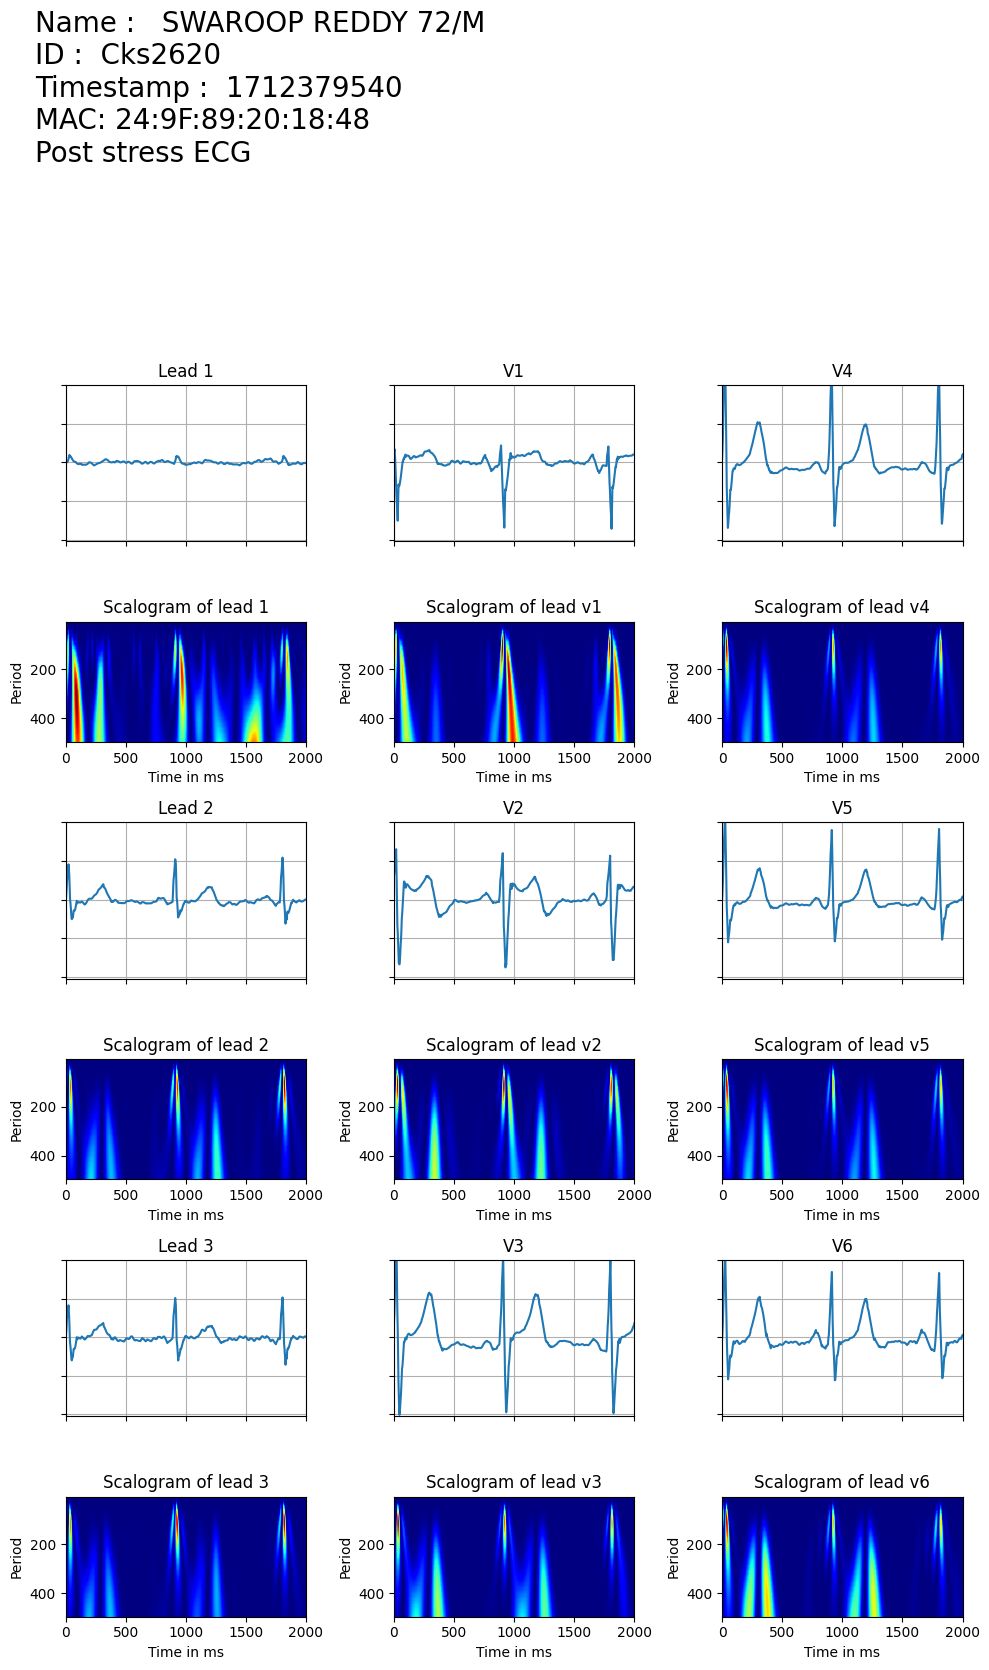

In [ ]:

Fs=1000
Wavelet_Type='Gaus 1 Power spectrum'
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15), (ax16, ax17, ax18)) = \
plt.subplots(6, 3, figsize=(10,15), gridspec_kw={'height_ratios': [1.3, 1, 1.3, 1, 1.3, 1]})
fig.subplots_adjust(hspace=1)
Patient_Details = ("Name :  %s %s \nID :  %s \nTimestamp :  %d  \nMAC: %s\n%s"%(name,age_gender,trialId,ts,macId,His))
fig.suptitle(Patient_Details,fontsize=20,ha = 'left', y=1.11, x=0.04)
#------------- ECG plot -------------#
# Lead1=T_Wave_Filter(Lead1);Lead2=T_Wave_Filter(Lead2)
# Leadv1=T_Wave_Filter(Leadv1);Leadv2=T_Wave_Filter(Leadv2);Leadv3=T_Wave_Filter(Leadv3);Leadv4=T_Wave_Filter(Leadv4);Leadv5=T_Wave_Filter(Leadv5);Leadv6=T_Wave_Filter(Leadv6)
Lead3=Lead2-Lead1
ecgplot_DD(ax1,Lead1,'Lead 1'); ecgplot_DD(ax7,Lead2,'Lead 2'); ecgplot_DD(ax13,Lead3,'Lead 3')
ecgplot_DD(ax2,Leadv1,'V1'); ecgplot_DD(ax8,Leadv2,'V2'); ecgplot_DD(ax14,Leadv3,'V3')
ecgplot_DD(ax3,Leadv4,'V4'); ecgplot_DD(ax9,Leadv5,'V5'); ecgplot_DD(ax15,Leadv6,'V6')
#------------- Spectrogram Plot -------------#
np.int = np.int32  # typecasting np.int32
scalogram_DD(ax4,Lead1,'Scalogram of lead 1');scalogram_DD(ax10,Lead2,'Scalogram of lead 2'); scalogram_DD(ax16,Lead3,'Scalogram of lead 3')
scalogram_DD(ax5,Leadv1,'Scalogram of lead v1'); scalogram_DD(ax11,Leadv2,'Scalogram of lead v2'); scalogram_DD(ax17,Leadv3,'Scalogram of lead v3')
scalogram_DD(ax6,Leadv4,'Scalogram of lead v4'); scalogram_DD(ax12,Leadv5,'Scalogram of lead v5'); scalogram_DD(ax18,Leadv6,'Scalogram of lead v6')
plt.tight_layout()
# plt.text(-3500,-5000,"Wavelet_Type: %s"%(Wavelet_Type),fontsize=24)

plt.savefig(('/content/drive/MyDrive/Carditek Report for Celara/12-LeadDiastolicDysfunction/'+trialId+'_'+name+'_'+date+'DD.tif'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/Carditek_Report_for_Celara/12-LeadDiastolicDysfunction/'+trialId+'_'+name+'_'+date+'DD.tif'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/King Georges Report/Diastolic Dysfunction/'+trialId+'_'+name+'_'+date+'DD.pdf'), bbox_inches='tight')

# plt.savefig(('/content/drive/MyDrive/Holter Report/Testing/'+tialId+'_'+name+'DD.pdf'), bbox_inches='tight')

# 5. Page-2



## Version 1.2 of Page 2 Report

In [ ]:
# RESPIRATORY RATE GRAPHICAL DISPLAY
def RespiratoryRate_ver2(AX, Rpeak, FiltECG):
  # R-peak amplitude
  Ramp = []; new_Y = [];
  for i in range(0, len(Rpeak)):
    ch = FiltECG[Rpeak[i]]
    Ramp.append(np.round(ch, 4))
  Ramp = np.array(Ramp);
  # Cubic Interpolation
  u_xAmp = Rpeak[0:len(Rpeak)];  u_yAmp = Ramp.flatten()
  u_pAmp = interp1d(u_xAmp, u_yAmp, kind = 'cubic',bounds_error = False, fill_value=0.0)
  xnew_Amp = np.arange(-0.5, len(FiltECG), 1);  ynew_Amp = u_pAmp(xnew_Amp)
  for i in ynew_Amp:
    if i!=0: new_Y.append(i)
  new_Y=np.array(new_Y);
  norm = new_Y/np.max(new_Y)
  b, a= sp.signal.butter(2, 0.5, fs=1000, btype='low');
  norm_f = sp.signal.filtfilt(b, a, norm);
  norm_loc,x = sp.signal.find_peaks(norm_f, distance=2000, height=int((np.min(norm_f)+np.max(norm_f))/2));
  print(norm_loc)
  RespRate = len(norm_loc)/(len(FiltECG)/60000)
  # Plot the signal
  RespTitle= ("ECG Derived Respiratory Rate : %0.0f breath/min"%(RespRate)); AX.title.set_text(RespTitle)
  AX.plot(norm_f,'-',color='green',lw=1);  AX.plot(norm_loc, norm_f[norm_loc],'+r')
  # Create x-axis tick positions
  ticks_per_interval = int(20*1000); tick_positions = np.arange(0, 120000, ticks_per_interval)
  tick_labels = np.arange(0, 120 , 20); plt.xticks(tick_positions, tick_labels)
  AX.set_xlabel("Time (msec)"); AX.set_ylabel("Normalized\nAmplitude (mV)", fontsize=8)
  if len(FiltECG)>= 120000: AX.set_xlim([0,120000])
  else: AX.set_xlim([0,(len(FiltECG)/1000)])
  return()



# HEARTRATE VARIABILITY GRAPHICAL DISPLAY
def HRV_ver2_1(AX, Rpeaks, RRint):
  # Time axis estimation
  Timeaxis = []; Timeaxis.append(Rpeaks[0]/1000)
  for i in range(0,len(RRint)):
    Timeaxis.append(np.sum(RRint[0:i])/1000)
  print("Timeaxis :",Timeaxis)
  # HRV Parameter calculations
  SDNN = st.pstdev(RRint); #print("SDNN",SDNN)
  DIFFRR = np.diff(RRint)
  RMSSD = np.sqrt(np.mean(np.square(DIFFRR))); #print("RMSSD:",RMSSD)
  MeanRR = np.mean(RRint)
  # Plotting
  HRV_title = ("HRV::  SDNN= %.0f, RMSSD= %.0f"%(SDNN,RMSSD)); AX.title.set_text(HRV_title);
  AX.plot(Timeaxis[0:len(RRint)],RRint,'k',marker='o',markerfacecolor='r',markersize=2, lw=0.75)
  AX.set_ylim([MeanRR-300,MeanRR+300]); AX.set_xticks(np.arange(0,300,20))
  if np.max(Timeaxis)>= 120: AX.set_xlim([0,120])
  else: AX.set_xlim([0,np.max(Timeaxis)])
  AX.hlines(MeanRR, 0,500, 'orange', linestyles='--',lw=2)
  AX.set_xlabel("Time (sec)"); AX.set_ylabel("RR-Intervals\n(msec)", fontsize=8)
  return()



def ecgplot_DD(ax,data,x):
  ax.plot(data*(-1))
  ax.set_ylim([-10.2,10]); ax.grid(True);
  ax.set_yticklabels([]); ax.set_xticklabels([]);
  ax.title.set_text(x);ax.set_xlim(X1,X2);

def scalogram_DD(ax, data, x):
  cws_data = data[X1:X2]
  scg.set_default_wavelet('gaus1')
  scg.cws(cws_data, ax=ax, cmap="jet", cbar=None, spectrum='amp',coi = False, ylabel="Period", xlabel="Time in ms");
  ax.title.set_text(x)

End of patient data
Number of Timestamps read :  8
Timeaxis : [0.895, 0.0, 0.761, 1.506, 2.239, 2.986, 3.738, 4.487, 5.218, 5.956, 6.707, 7.459, 8.203, 8.931, 14.656, 15.415, 16.171, 16.886, 17.622, 18.337, 19.062, 19.787, 20.506, 21.244, 22.002, 22.755, 23.497, 24.283, 25.068, 25.829, 26.606, 27.384, 28.147, 28.902, 29.978, 30.738, 31.514, 32.313, 33.122, 33.895, 34.69, 35.482, 36.257, 37.017, 37.778, 38.557, 39.322, 40.075, 40.847, 41.639, 42.395, 43.135, 43.883, 44.639, 45.387, 46.125, 46.883, 47.653, 48.407, 49.169, 49.945, 50.716, 51.474, 52.251, 53.043, 53.823, 54.585, 55.383, 56.183, 56.981, 57.749, 58.499, 59.606, 60.356, 61.13, 61.891, 62.629, 63.358, 64.088, 64.838, 65.567, 66.314, 67.093, 67.887, 68.646, 69.404, 70.171, 70.937, 71.677, 72.407, 73.151, 73.894, 74.625, 75.362, 76.106, 76.835, 77.563, 78.304, 79.05, 79.789, 80.547, 81.328, 82.088, 82.844, 83.634, 84.429, 85.194, 85.976, 86.784, 87.591, 88.369, 89.678, 90.43, 91.197, 91.99, 92.792, 93.595, 94.362, 95.116, 95.881

<ipython-input-97-da9e48c3727b>:38: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()
<ipython-input-97-da9e48c3727b>:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


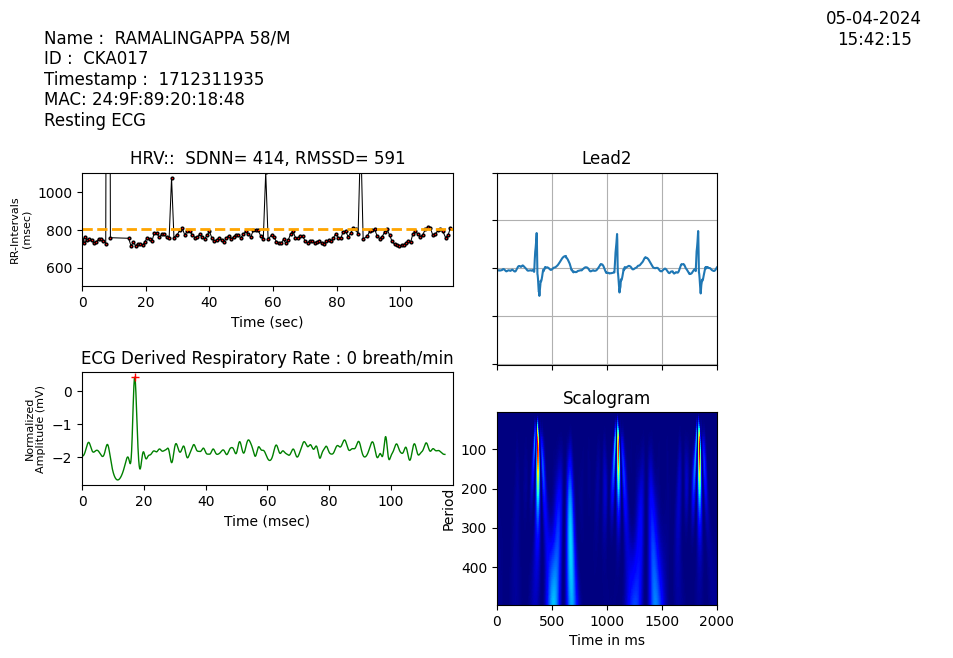

In [ ]:
# ts = 1703225310  +(15*0)
# macId = '24:9F:89:20:18:24'
_, LeadFrame = read_ECG(ts, macId, read=15)

gain = 1.2; X1=2000; X2=2000+X1
Data_DD = np.array(LeadFrame.Lead_2); Data_DD = ((Data_DD)*0.000286)*((gain));
Data_DD = ecg_filters_V5_smooth(Data_DD);

Data_HRVRR = np.array(LeadFrame.V3); ata_HRVRR = ((Data_HRVRR)*0.000286)*((gain));
Data_HRVRR = ecg_filters_V5_smooth(Data_HRVRR);
R_peaks = R_Peak_Detection_03(Data_HRVRR)
RR_int = np.diff(R_peaks)

fig1 = plt.figure(2, figsize=(11.6,8.2),constrained_layout=True)
ax_name = plt.subplot2grid((16,24), (0, 0), colspan=20, rowspan=2, fig=fig1)
ax_datetime = plt.subplot2grid((16,24), (0, 22), colspan=2, rowspan=1, fig=fig1)
ax_spectTitle = plt.subplot2grid((16,24), (2,1), colspan=6, rowspan=1, fig=fig1)
ax_lead2 = plt.subplot2grid((16,24),(3,12), colspan=6, rowspan=5, fig=fig1)
ax_lead2spect = plt.subplot2grid((16,24), (9,12), colspan=6, rowspan=5, fig=fig1)
ax_HRV = plt.subplot2grid((16,24), (3,1), colspan=10, rowspan=3, fig=fig1)
ax_Resp = plt.subplot2grid((16,24), (8,1), colspan=10, rowspan=3, fig=fig1)

ecgplot_DD(ax_lead2,Data_DD*(-1),'Lead2')
scalogram_DD(ax_lead2spect,Data_DD,'Scalogram')

# HRV_Data = np.array(LeadFrame.Lead_2);
# HRV_plot(ax_HRV, HRV_Data)

HRV_ver2_1(ax_HRV, R_peaks, RR_int)
RespiratoryRate_ver2(ax_Resp, R_peaks,Data_HRVRR)
# ax_Resp.axis('off')

ax_name.text(0,0, Patient_Details,fontsize=12); ax_name.axis('off')
ax_datetime.text(0,0, str(date+"\n"+time+"\n\n"),horizontalalignment='center', fontsize=12); ax_datetime.axis('off')
# ax_spectTitle.text(0,0.05, 'Diastolic Function Spectrogram',fontsize=10 );
ax_spectTitle.axis('off')

plt.tight_layout()
plt.show()

## Version 1.0 of Page 2 Report

In [ ]:
# ts =1677904875+(15*2)
# macId = '24:9F:89:20:18:3E'
_, LeadFrame = read_ECG(ts, macId, read=15)

Data = np.array(LeadFrame.Lead_2);
gain = 1.2; Data_DD = ((Data)*0.000286)*((gain));
Data_DD = ecg_filters_V5_smooth(Data_DD);
R_peaks = R_Peak_Detection_03(Data_DD)
RR_int = np.diff(R_peaks)

fig1 = plt.figure(2, figsize=(11.6,8.2),constrained_layout=True)
ax_name = plt.subplot2grid((16,24), (0, 0), colspan=20, rowspan=2, fig=fig1)
ax_datetime = plt.subplot2grid((16,24), (0, 22), colspan=2, rowspan=1, fig=fig1)
ax_spectTitle = plt.subplot2grid((16,24), (2,1), colspan=6, rowspan=1, fig=fig1)
ax_lead2 = plt.subplot2grid((16,24),(4,1), colspan=6, rowspan=5, fig=fig1)
ax_lead2spect = plt.subplot2grid((16,24), (10,1), colspan=6, rowspan=5, fig=fig1)
ax_HRV = plt.subplot2grid((16,24), (3,10), colspan=10, rowspan=3, fig=fig1)

ecgplot_DD(ax_lead2,Data_DD*(-1),'Lead2')
scalogram_DD(ax_lead2spect,Data_DD,'Scalogram')

HRV_Data = np.array(LeadFrame.Lead_2);
HRV_plot(ax_HRV, HRV_Data)

# HRV_ver2_1(ax_HRV, R_peaks, RR_int)
# ax_Resp = plt.subplot2grid((16,24), (7,10), colspan=10, rowspan=3, fig=fig1)
# RespiratoryRate_ver2(ax_Resp, R_peaks,Data_DD)

ax_name.text(0,0, Patient_Details,fontsize=12); ax_name.axis('off')
ax_datetime.text(0,0, str(date+"\n"+time+"\n\n"),horizontalalignment='center', fontsize=12); ax_datetime.axis('off')
ax_spectTitle.text(0,0.05, 'Diastolic Function Spectrogram',fontsize=10 ); ax_spectTitle.axis('off')

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

# 12 Lead FFT

In [ ]:

def fft_peakvalue(data,endpoint):
  data = (data)*0.000286  ############ without filters
  # data = dataloss(data)*0.000286  ############ without filters
  # data = ecg_filters_Twave(data)  ############ with filters
  max_amp = np.max(data[2000:13000]); min_amp = np.min(data[2000:13000]); ppamp = max_amp-(min_amp);
  fft_lead = fftpack.fft(data.ravel());abs_lead = 2*(abs(np.array(fft_lead))/N)
  p_lead = abs_lead[1:endpoint]
  up_10 = int((len(p_lead)*9)/(Fs/2)); lo_10 = int((len(p_lead)*11)/(Fs/2))
  up_22 = int((len(p_lead)*21)/(Fs/2)); lo_22 = int((len(p_lead)*23)/(Fs/2))
  up_50 = int((len(p_lead)*49)/(Fs/2)); lo_50 = int((len(p_lead)*51)/(Fs/2))
  Peak_10 = np.max(p_lead[up_10:lo_10]);
  Peak_22 = np.max(p_lead[up_22:lo_22]); Peak_50 = np.max(p_lead[up_50:lo_50])
  PSD_lead = (np.abs(p_lead)**2)/(Fs*len(p_lead))
  return(p_lead,PSD_lead,Peak_22,Peak_50,ppamp)

def plotting_FFTonly(fftAX,fft_data,freq_axis,title,Xlim=[0,150],Ylim=None,colour='green',Power=None):
  fftAX.plot(freq_axis,fft_data,lw=1.5,color=colour); fftAX.set_title(title, fontsize=20);
  fftAX.set_xlabel('Frequency in HZ');fftAX.set_ylabel('Amplitude in mV');
  Xlim_diff = Xlim[1]-Xlim[0]
  if Xlim_diff<30:  fftAX.set_xticks(np.arange(0,500,1));fftAX.set_xlim(Xlim);fftAX.set_ylim(Ylim);
  elif Xlim_diff>30 and Xlim_diff<80:  fftAX.set_xticks(np.arange(0,500,5));fftAX.set_xlim(Xlim);fftAX.set_ylim(Ylim);
  elif Xlim_diff>80 and Xlim_diff<200:  fftAX.set_xticks(np.arange(0,500,10));fftAX.set_xlim(Xlim);fftAX.set_ylim(Ylim);
  elif Xlim_diff>200 and Xlim_diff<500:  fftAX.set_xticks(np.arange(0,500,50));fftAX.set_xlim(Xlim);fftAX.set_ylim(Ylim);
  if Power is not None:
    Freq=max_power(Power[0],Power[1]);
    lable=str(str(Power[1])+'% power below '+str(Freq)+' Hz')
    fftAX.text(0.2,1,lable,fontsize=10)
  # plt.minorticks_on(); plt.grid(which = 'major', linestyle = '-', linewidth = 0.5, color = 'red');
  # fftAX.grid(which = 'minor', linestyle = ':', linewidth = 0.5, color = (1,0.7,0.7))
  fftAX.grid(True)
  return

def max_power(PSD, Percent=50):
  cum_psd = np.cumsum(PSD); #Cumilative Power Spectrum Density
  total_power = np.sum(PSD);  # Calculate the total power
  ## Find the frequency at which cumulative power exceeds 50% default or as specified
  idx = np.argmax(cum_psd >(Percent/10)*total_power)
  freq_50_percent = np.fft.fftfreq(len(PSD),1/Fs)[idx]
  return (freq_50_percent)

def FFT_valueprint(fft_data, startFreq=0, stopFreq=100):
  for i in range(startFreq,stopFreq):
    print("%d Hz : %f mV"%(i,fft_data[i]))
  return

# **READ ME INSTRUCTIONS**

***For standard FFT:***
1. Keep line number 9,10 and 11 uncommented
2. Always make sure Line number 14, 15, 16 and 17 commented
3. In line number 30 Make sure Xmin=0 and **Xmax=50**

***For Diastolic Dysfunction check:***
1.  Always make sure Line number 14, 15, 16 and 17 uncommented
2. Keep line number 9,10 and 11 uncommented
3. In line number 30 Make sure Xmin=0 and **Xmax=10**

***For Bundle Branch Block Patients:***
1. Always make sure Line number 14, 15, 16 and 17 uncommented
2. Keep line number 9,10 and 11 uncommented
3. In line number 30 Make sure Xmin=0 and **Xmax=20**

<Figure size 640x480 with 0 Axes>

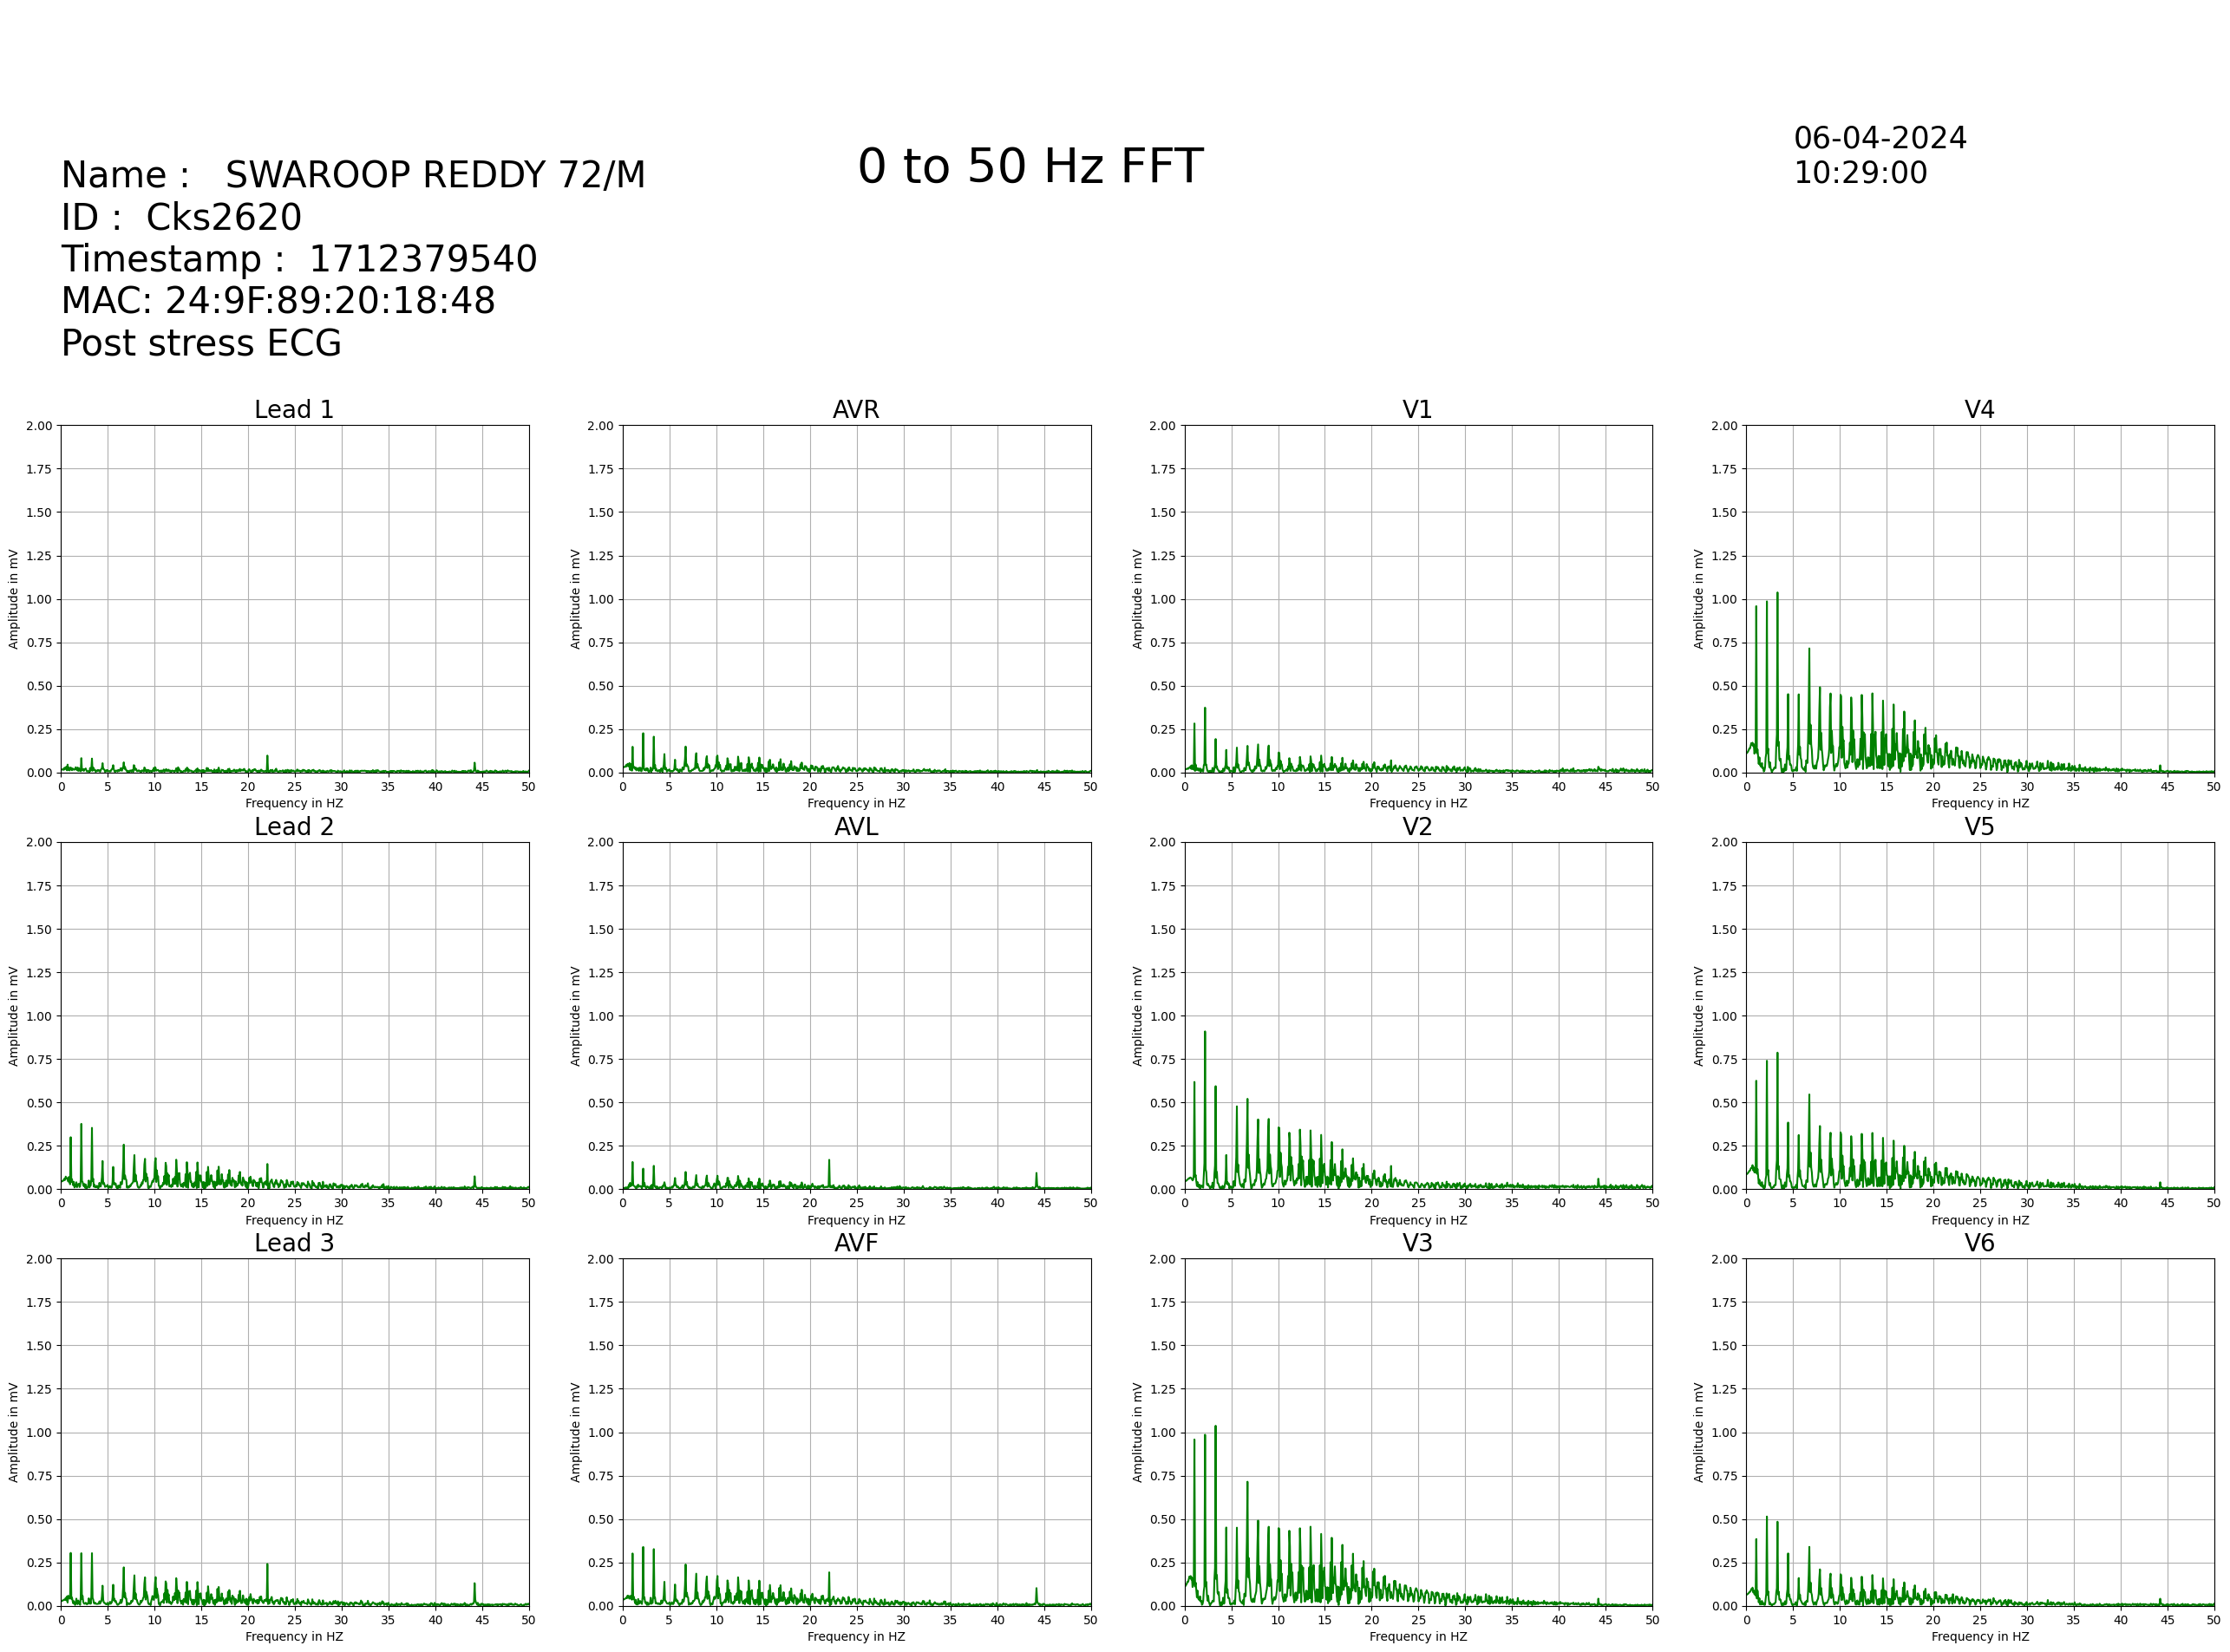

In [ ]:
Fs = 1000; dt = 1/Fs;
t = np.arange(0,15,dt)
N = 15000; endpoint = int((N/2)+1)
time_axis = ((np.arange(1,N+1))/Fs); freq_axis = (Fs*np.arange(0,(N/2))/N)

####      FOR REGULAR ECGs
buffer = client.fetch(macId,ts)
# frame = buffer.frame;
ecgsignal_lead1 = frame.i; ecgsignal_lead2 = frame.ii; ecgsignal_lead3=frame.iii;
ecgsignal_V1 = frame.v1; ecgsignal_V2 = frame.v2; ecgsignal_V3 = frame.v3;
ecgsignal_V4 = frame.v4; ecgsignal_V5 = frame.v5; ecgsignal_V6 = frame.v6 ##############    to add V6 enter V5 Here

####  APPLY FILTERS HERE IF ANY
ecgsignal_lead1 = baseline_filter(ecgsignal_lead1); ecgsignal_lead2= baseline_filter(ecgsignal_lead2)
ecgsignal_V1 = baseline_filter(ecgsignal_V1); ecgsignal_V2 = baseline_filter(ecgsignal_V2)
ecgsignal_V3 = baseline_filter(ecgsignal_V4); ecgsignal_V4 = baseline_filter(ecgsignal_V4)
ecgsignal_V5 = baseline_filter(ecgsignal_V5); ecgsignal_V6 = baseline_filter(ecgsignal_V6)

# ecgsignal_V2=filt2(ecgsignal_V2)
# ####      FOR 502 ERROR ECGs
# ecgsignal_lead1 = pd.read_csv(Path(file_name_csv))[n1:n2]['i']; ecgsignal_lead2 = pd.read_csv(Path( file_name_csv))[n1:n2]['ii']; ecgsignal_lead3 = pd.read_csv(Path(file_name_csv))[n1:n2]['iii']
# # avr = pd.read_csv(Path( file_name_csv))[n1:n2]['avr']; # avl = pd.read_csv(Path( file_name_csv))[n1:n2]['avl']; # avf = pd.read_csv(Path( file_name_csv))[n1:n2]['avf']
# ecgsignal_V1 = pd.read_csv(Path( file_name_csv))[n1:n2]['v1']; ecgsignal_V2 = pd.read_csv(Path( file_name_csv))[n1:n2]['v3']; ecgsignal_V3 = pd.read_csv(Path( file_name_csv))[n1:n2]['v3']
# ecgsignal_V4 = pd.read_csv(Path( file_name_csv))[n1:n2]['v4']; ecgsignal_V5 = pd.read_csv(Path( file_name_csv))[n1:n2]['v5']; ecgsignal_V6 = pd.read_csv(Path( file_name_csv))[n1:n2]['v6']


plt.figure(1);
fig,((Tit,Disc,Disc1,Date),(axFFT1, axFFT4,axFFT7,axFFT10),(axFFT2,axFFT5,axFFT8,axFFT11),(axFFT3,axFFT6,axFFT9,axFFT12))=plt.subplots(nrows=4,ncols=4,figsize=(32.04,23.92))

Xmin=0; Xmax=50; Ymin = 0; Ymax = 2;
Filename = trialId+'_FFT'+str(Xmin)+'to'+str(Xmax)+'_'+date

ecgsignal_lead3 = ecgsignal_lead2 - ecgsignal_lead1

avr = -(ecgsignal_lead2+ecgsignal_lead1)/2; avl = ecgsignal_lead1-(ecgsignal_lead2/2); avf = ecgsignal_lead2-(ecgsignal_lead1/2);

LeadData = [ecgsignal_lead1,ecgsignal_lead2,ecgsignal_lead3,avr,avl,avf,ecgsignal_V1,ecgsignal_V2,ecgsignal_V3,ecgsignal_V4,ecgsignal_V5,ecgsignal_V6]
LeadTitle = ['Lead 1','Lead 2','Lead 3','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']
FFTAxis = [axFFT1,axFFT2,axFFT3,axFFT4,axFFT5,axFFT6,axFFT7,axFFT8,axFFT9,axFFT10,axFFT11,axFFT12]

for m in range(len(LeadData)):
  FFT_data,PSD_data,ch_Peak_22,ch_Peak_50,ch_PPamp = fft_peakvalue(LeadData[m],endpoint)
  plotting_FFTonly(FFTAxis[m],FFT_data,freq_axis,LeadTitle[m],Xlim=[Xmin,Xmax],Ylim=[Ymin,Ymax]);

Tit.text(0,0, Patient_Details,fontsize=30); Tit.axis('off')
Date.text(0.1,0.5, str(date+"\n"+time),horizontalalignment='left', fontsize=25); Date.axis('off')
Disc.text(0.5,0.5,str('%d to %d Hz FFT'%(Xmin,Xmax)),fontsize=40); Disc.axis('off'); Disc1.axis('off')
# plt.savefig((Save_Path+Filename+'.png'), bbox_inches='tight')
plt.savefig(('/content/drive/MyDrive/Carditek Report for Celara/12 Lead ECG FFT/'+trialId+'_'+name+'_'+date+' FFT.pdf'), bbox_inches='tight')
# plt.savefig(('/content/drive/MyDrive/Carditek_Report_for_Celara/12 Lead ECG FFT/'+trialId+'_'+name+'_'+date+'FFT.pdf'), bbox_inches='tight')


# **HFECG CODE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import scipy as sp
import math
import statistics as stat
from scipy import signal as sp
from scipy.signal import hilbert, savgol_filter
import collections
from scipy import signal
from numpy import array, sign, zeros
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linspace
from PIL import Image, ImageDraw, ImageFont,ImageFilter
import datetime
from pytz import timezone
import statistics as st

arr = collections.deque()

def get_time_from_timestamp(timestamp):
  read_able = datetime.datetime.fromtimestamp(timestamp)
  now_asia = str(read_able.astimezone(timezone('Asia/Kolkata'))); #print(now_asia)
  year = now_asia[0:10]
  year = year[8:10]+"-"+year[5:7]+"-"+year[0:4]
  time = now_asia[11:19]
  return (year,time)

def bandpass(low, high, fs=1000, order=25):
    return sp.butter(order, [low, high], fs=fs, btype='bandpass',
    #return sp.cheby1(4, 1, [low, high], btype='bandpass', analog=True,
    output='sos')

def dataloss(data):
  for x in  range(1,len(data),1):
    if (data[x] ==0):
       data[x] = data[x-1]
  return data

def high_pass(sig):
  sos = sp.butter(4, 100, 'hp', fs=1000, output='sos')
  filt = sp.sosfilt(sos,sig)
  return filt

def signal_average(raw,peaks, similarity, hf = 100):
  Fs =1000
  b = sp.firwin(1735, cutoff = [0.80/500], window = "hamming", pass_zero=False); a = 1
  filt_BW = sp.filtfilt(b, a, raw)

  sos1 = bandpass(0.05, 150, order=7)
  filtered = ((sp.sosfilt(sos1, filt_BW)))*0.000286

  com_width = round(Fs//(2.5)); com_width_h = Fs//5; sim_com = round(Fs//(10));
  ecg = np.zeros((peak_len,com_width*2)); start_p = np.empty([peak_len],dtype=int); end_p =np.empty([peak_len],dtype=int)
  sim_ecg = np.zeros((peak_len,sim_com*2)); sim_start_p = np.empty([peak_len],dtype=int); sim_end_p =np.empty([peak_len],dtype=int)

  count = 0; temp_ecg= sim_ecg[3]
  for i in  range(peak_len):
    #j=com_width
    sim_start_p[i] = peaks[i]-sim_com; sim_end_p[i] = peaks[i]+sim_com
    sim_ecg[i] = filtered[sim_start_p[i]:sim_end_p[i]]

  for j in  range(0,len(sim_ecg)):
    s = np.corrcoef(temp_ecg,sim_ecg[j]); s = s[0][1]
    #print(s)
    if s> similarity:
      arr.append(j); count = count +1

  newpeak = np.empty([len(arr)],dtype=int)
  for z in range(len(arr)):
    ch= arr.popleft()
    newpeak[z] = peaks[ch]

  peak_len_n = len(newpeak)

  ecg_n = np.zeros((peak_len_n,com_width*2)); ecg_HF = np.zeros((peak_len_n,com_width_h*2))
  start_p = np.empty([peak_len_n],dtype=int); end_p =np.empty([peak_len_n],dtype=int)

  start_h = np.empty([peak_len_n],dtype=int); end_h =np.empty([peak_len_n],dtype=int)
  Avg_ecg = np.zeros((1,com_width*2)); Avg_HF = np.zeros((1,com_width_h*2))

  sos = bandpass(hf, 450, order=6);  HFECG_filtered = ((sp.sosfilt(sos, raw)))*0.000286

  for i in  range(count):
    #j=com_width
    start_p[i] = newpeak[i]-com_width; end_p[i] = newpeak[i]+com_width; ecg_n[i] = filtered[start_p[i]:end_p[i]]; Avg_ecg = (Avg_ecg + ecg_n[i])
    start_h[i] = newpeak[i]-com_width_h; end_h[i] = newpeak[i]+com_width_h; ecg_HF[i] = HFECG_filtered[start_h[i]:end_h[i]]; Avg_HF = (Avg_HF + ecg_HF[i])

  Avg_ecg = Avg_ecg/peak_len_n; Avg_HF = Avg_HF/peak_len_n

  Avg_ecg = np.transpose(Avg_ecg); data = Avg_ecg.flatten(); data = abs(data); ecg = np.transpose(ecg_n)
  Avg_HF = np.transpose(Avg_HF); ecg_HF = np.transpose(ecg_HF)

  max_location = np.argmax(data)
  loc = max_location - 50
  r_peak = data[loc]
  r_prev = data[loc - 1]
  count = 1
  while r_peak > r_prev:
      r_peak = data[loc - count]
      r_prev = data[loc - count - 1]
      count += 1
  qrs_onset = loc - count
  loc2 = max_location + 50
  r_on = data[loc2]
  r_end = data[loc2 + 1]
  count = 1
  while r_on < r_end:
      r_on = data[loc2 + count]
      r_end = data[loc2 + 1 + count]
      count += 1
  qrs_offset = loc2 + count

  return Avg_ecg, Avg_HF, ecg, ecg_HF,peak_len_n,qrs_onset,qrs_offset

def leadplot_ecg(ecg,data,QRSON,QRSoff,x,position):
  ecg.plot(data+position,linewidth=2,color = 'darkred');
  ecg.axvline(x = QRSON, color = 'k', linestyle = ':')
  ecg.axvline(x = QRSoff, color = 'k', linestyle = ':')
  ecg.set_yticklabels([]); ecg.set_xticklabels([]);
  #ecg.text(-34, 0.03, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  ecg.set_yticks(np.arange(-20, 20,5)); ecg.set_xticks(np.arange(0, 800, 200))
  ecg.set_ylim([-15.2,15]); ecg.set_xlim(0,820);
  ecg.title.set_text(x); ecg.grid(True);
  return

def leadplot_hf(hf,data):
  hf.plot((data*1),linewidth=1.5);
  hf.set_ylim([-0.22,0.20]); hf.grid(True);
  hf.set_yticklabels([]); hf.set_xticklabels([]);
  hf.set_xlim(51,350);
  return

##########   Display with downsamplaned Stem
def hf_envop(HF):
  S_Avg_co = HF.flatten(); s = S_Avg_co; q_u = zeros(s.shape)
  u_x = [0,]; u_y = [s[0],]
  for k in range(1,len(s)-1):
    if (sign(s[k]-s[k-1])==1) and (sign(s[k]-s[k+1])==1):u_x.append(k); u_y.append(s[k])
  u_x.append(len(s)-1); u_y.append(s[-1])
  #plt.figure(); plt.stem(u_y)
  for k in range(21,len(u_y)-1):
    if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  #plt.figure(); plt.stem(u_y)
  rp,rv = sp.find_peaks(u_y,height=(max(u_y)/3))
  if max(u_y)< 0.040:
    RAZ = 2
  else:
    if len(rp)==2:
      if abs(rp[0]-rp[1])>4:
        if ((round(((min(u_y[rp[0]:rp[1]]))*100)/max(u_y)))<40): RAZ = 4 ;# print('RAZ N')
        else: RAZ = 3 ; #print('RAZ AP')
      else: RAZ = 1 ; #print('RAZ A')
    else: RAZ = 0 ; #print("NO RAZ")


  u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
  for k in range(0,len(s)):
      q_u[k] = u_p(k)
  t = np.arange(0, len(q_u), 1)
  return t,q_u, RAZ


def score(data,QRSON,QRSoff):
  ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
  data2 = (data[ON:OFF]);
  aben = round(np.sum(np.square(data2)),4)
  t,en, RAZ = hf_envop(data);
  #plt.plot(t,en)
  data = data.flatten();n_en = abs(en);
  RMS = np.round(((np.sqrt(np.mean(data[QRSON:QRSoff]**2)))*1000),1)
  kur = np.round(kurtosis(n_en[QRSON:QRSoff], axis=0, bias=True),1)
  return RAZ,RMS,kur,aben

def R_Peak_Detection_V3(data):    ## R peak detection with ectopic marking
  peaks_up = []; amp = [];
  # print(data)
  b = signal.firwin(2377, cutoff = [2/500], window = "hamming", pass_zero=False);a= 1;
  h, g = signal.butter(4, [45/500] , btype='low', analog=False)
  filt_BW = signal.filtfilt(b, a, data); data_F = signal.lfilter(h, g, filt_BW)
  data_FS = data_F*data_F; data_D = np.diff(data_FS);
  peaks,rpeak = signal.find_peaks(data_D,distance = 400,height=(max(data_D[1000:5000])/5));n = len(peaks);
  for i in range(0,n):
    win=70;
    if (peaks[i]-(win))<0: start_win = 0
    else: start_win = (peaks[i]-(win))
    seg = data_F[start_win:(peaks[i])+(win)]; seg2 = seg*seg;
    max_peak,peak_amp = signal.find_peaks(seg2, distance = 10, height = (max(seg2)/2))
    peaks_u = start_win + max_peak[0]
    peaks_up.append(peaks_u);
  return peaks_up

def hf_envop(HF):
  S_Avg_co = HF.flatten(); s = S_Avg_co; q_u = zeros(s.shape)
  u_x = [0,]; uy = [s[0],];
  for k in range(1,len(s)-1):
    if (sign(s[k]-s[k- 1])==1) and (sign(s[k]-s[k+1])==1):u_x.append(k); uy.append(s[k])
  u_x.append(len(s)-1); uy.append(s[-1]);
  u_y = uy
  for k in range(0,len(uy)-2):
    if uy[k]<(max(uy)/1.5) and uy[k+1]<(max(uy)/1.5) and uy[k-1]<(max(uy)/1.5): u_y[k] = (uy[k-1]+uy[k+1])/2
    # if (uy[k]<uy[k-1]) and (uy[k]<uy[k+1]):
    #   if u_y[k] < (uy[k-1]+uy[k+1])/3:
    #     u_y[k] = (uy[k-1]+uy[k+1]+u_y[k])/2.8
    #   else:
    #     u_y[k] = (uy[k-1]+uy[k+1])/2
      #plt.figure(); plt.stem(u_y)
  rp,rv = sp.find_peaks(u_y,height=(max(u_y)/3));
  if max(u_y)< 0.020:
    RAZ = 4
  else:
    if len(rp)>=2:
      #arrange = np.sort(rp)[::-1]; print(arrange); primary = arrange[0]; secondary = arrange[1]; h = max(primary,secondary); l = min(primary, secondary);# print(primary); print(secondary)
      if ((round(((min(u_y[rp[0]:rp[1]]))*100)/max(u_y)))<40):
        if abs(rp[0]-rp[1])>2: RAZ = 3 ;# print('RAZ N')
        else:
          RAZ = 2 ; #print('RAZ AP')
          for k in range(1,len(u_y)-1):
            if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
      else:
        RAZ = 1 ; #print('RAZ A')
        for k in range(1,len(u_y)-1):
          if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
    else:
      RAZ = 0 ; #print("NO RAZ")
      for k in range(1,len(u_y)-1):
        if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
  for k in range(0,len(s)):
      q_u[k] = u_p(k)
  #q_u = sp.medfilt(q_u, kernel_size=19)
  # average_q_u = []
  # for ind in range(len(q_u)-9):
  #   average_data.append(np.mean(q_u[ind:ind+10]))
  #diff_u = np.diff(q_u)*10
  t = np.arange(0, len(q_u), 1)
  return t,q_u, RAZ

def leadplot_hf(hf,data,peak,QRSON,QRSoff):
  Zoom = 2
  if peak > 10:
    ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
    data1 = (data[0:ON])*0.3; data2 = (data[ON:OFF]); data3 = (data[OFF:400])*0.3;
    data = np.concatenate((data1,data2,data3));
    data_P = np.concatenate((data1,data2,data3));
    for i in range(len(data_P)):
      if data_P[i] < 0:
        data_P[i] = data_P[i]*[-1]
    zcr = 0;
    # for i in range(1, len(data_P)):
    #   if data_P[i] * data_P[i - 1] < 0: zcr += 1
    # zcr = (zcr / len(data2))  ############# Zero Crossing
    aben = round(np.sum(np.square(data2)),4)  #############  absolute energy
    t,en, RAZ = hf_envop(data_P); data = data.flatten();
    RMS = round(((np.sqrt(np.mean(data2**2)))*1000),3)      ##############  RMS Voltage
    hfp = round(max(data)*1000)   ###########    Amplitude of HFECG
    variance = round(np.var(data2),4)
    kur = round(abs(kurtosis(en[ON:OFF], axis=0, bias=True)),3)

    en_r = sp.resample(data_P*Zoom, 100); t_r = np.linspace(0,100,100);
    hf.axvline(x = ON, color = 'k', linestyle = ':')
    hf.axvline(x = OFF, color = 'k', linestyle = ':')
    # if RAZ == 0: hf.text(7, 0.80, "RAZ Grade : 0",color='g',size=17,fontweight='bold');# hf.text(2, 0.65, "RAZ Score = 0 ",color='brown',size=13)
    # elif RAZ == 1: hf.text(7, 0.80, "RAZ Grade : 1",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 2 ",color='brown',size=13)
    # elif RAZ == 2: hf.text(7, 0.80, "RAZ Grade : 2",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 5 ",color='brown',size=13)
    # elif RAZ == 3: hf.text(7, 0.80, "RAZ Grade : 3",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 5 ",color='brown',size=13)
    # elif RAZ == 4: hf.text(7, 0.80, "RAZ Grade : 4",color='red',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 9 ",color='brown',size=13)
    hf.text(7, 0.67, "Peak Activation = "+str(np.argmax(data))+"mS",color='brown',size=15)
    hf.text(7, 0.57, "HF Amp = "+str(hfp)+"uV",color='brown',size=15)
    hf.text(7, 0.47, "Energy = "+str(aben),color='brown',size=15)
    hf.text(7, 0.37, "Variance = "+str(variance),color='brown',size=15)
    hf.text(7, 0.27, "Kurtosis = "+str(kur),color='brown',size=15)
    hf.text(7, 0.17, "RMS = "+str(RMS)+"uV",color='brown',size=15)
    hf.title.set_text('QRS(ms):'+str(QRSoff-QRSON));
    #hf.stem(en_r*Zoom, markerfmt=' ');
    #hf.bar(t_r, (en_r*Zoom), width = 0.75, color='#069AF3', alpha=0.9);
    hf.plot((data*Zoom*2));
    #hf.plot((data_P*Zoom*2));
    hf.plot(en*Zoom*2,linewidth=1.5);#plt.grid(True);
    hf.fill_between(t, en*Zoom*2,alpha=0.30,color='green')
  else:
    hf.plot(0);
    hf.text(45, 0.6, "INSUFFICIENT DATA", bbox=dict(facecolor='red', alpha=0.5))
  hf.set_yticklabels([]); hf.set_xticklabels([]);#hf.axis('off')
  hf.text(-130.50, -0.35, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  hf.set_yticks(np.arange(-1.90, 1.90,0.10)); hf.set_xticks(np.arange(0, 400,12))
  hf.set_xlim(0,400);hf.set_ylim(-0.40,0.90);
  hf.grid(True);
  return

def leadplot_hf_bar(hf,data,peak,QRSON,QRSoff):
  Zoom = 2
  if peak > 10:
    t,en, RAZ = hf_envop(data);
    data = data.flatten();n_en = abs(en);
    en_r = sp.resample(en*Zoom, 100); t_r = np.linspace(0,100,100);
    data = data*Zoom
    ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
    data1 = (data[0:ON])*0.3; data2 = (data[ON:OFF]); data3 = (data[OFF:400])*0.3;
    data = np.concatenate((data1,data2,data3));
    data_P = np.concatenate((data1,data2,data3));
    pri_peak = np.argmax(en);pri_m = max(en);
    sec_peak1,pv1 = sp.find_peaks(en[pri_peak:pri_peak+50],height=(max(en)/2));sec_peak1 = sec_peak1+pri_peak
    sec_peak2,pv2 = sp.find_peaks(en[pri_peak-50:pri_peak],height=(max(en)/2));sec_peak2 = (pri_peak-50)+sec_peak2

    sec_peak = np.concatenate((sec_peak2,sec_peak1)); sec_a= []
    dip_a = []
    if len(sec_peak)> 0:
      for m in range (len(sec_peak)):
        n = sec_peak[m]; sec_a.append(en[n]);
      sec_a = array(sec_a); sec_a = max(sec_a); ############# Check the location of Sec peak
      sec = np.argmax(sec_a); sec_peak = sec_peak[np.argmax(sec_a)]
      if pri_peak < sec_peak:
        dip_a = round(min(en[pri_peak:sec_peak]),4);
        hf.text(21, 1.27, "RAZ Duration = "+str(sec_peak-pri_peak)+"mS",color='brown',size=15)
      else:
        dip_a = round(min(en[sec_peak:pri_peak]),4);
        hf.text(21, 1.17, "RAZ Duration = "+str(pri_peak-sec_peak)+"mS",color='brown',size=15)
      hf.text(21, 1.07, "RAZ Amplitude = "+str(dip_a)+"uV",color='brown',size=15)
      per = 100- round(((dip_a*100)/pri_m),2)
      hf.text(21, 1.004, "Percentage of Drop = "+str(per)+"%",color='brown',size=15)
    hf.text(21, 1.27, "Peak Activation = "+str(np.argmax(data))+"mS",color='k',size=15)
    ON = int(QRSON/4); OFF = int(QRSoff/7)
    hf.axvline(x = ON, color = 'k', linestyle = ':')
    hf.axvline(x = OFF, color = 'k', linestyle = ':')
    hf.title.set_text('QRS(ms):'+str(QRSoff-QRSON));
    hf.bar(t_r, (en_r*Zoom*1.5), width = 0.75, color='#069AF3', alpha=0.9);
  else:
    hf.plot(0);
    hf.text(45, 0.6, "INSUFFICIENT DATA", bbox=dict(facecolor='red', alpha=0.5))
  hf.set_xticks(np.arange(0, 400,1.5))
  hf.set_yticklabels([]); hf.set_xticklabels([]);#hf.axis('off')
  hf.text(0, 0.03, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  hf.set_xlim(20,80);
  hf.set_yticks(np.arange(-0.10, 1.90,0.10));hf.set_ylim(0,1.40);
  hf.grid(True);
  return

def leadplot_hf_en(hf, HF_d, env, par, peak, QRSON, QRSoff):
  HF_d = HF_d/1.9
  env = env/1.9
  Zoom = 3
  if peak > 5:
    ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
    HF_d1 = (HF_d[0:ON])*0.3; HF_d2 = (HF_d[ON:OFF]); HF_d3 = (HF_d[OFF:400])*0.3;
    env1 = (env[0:ON])*0.3; env2 = (env[ON:OFF]); env3 = (env[OFF:400])*0.3;
    HF_d = np.concatenate((HF_d1,HF_d2,HF_d3))*Zoom;
    env = np.concatenate((env1,env2,env3))*Zoom*4;
    t = np.arange(0, len(env), 1)
    for z in range(0,len(env),2):
      env[z] = 0;
    hf.axvline(x = ON, color = 'k', linestyle = ':')
    hf.axvline(x = OFF, color = 'k', linestyle = ':')
    hf.title.set_text('QRS(ms):'+str(QRSoff-QRSON));
    # [PA,Amp,kur,total_area,RD,area,drop_sp,pri_peak,sec_peak]
    hf.text(10.50, 1.25, " HF Amplitude:"+str(par[1])+"uV",color='k',size=12);
    hf.text(10.50, 1.15, " HF Total Area:"+str(par[3])+"sq/mS",color='k',size=12);
    hf.text(10.50, 1.05, " RAZ Duration:"+str(par[4])+"mS",color='k',size=12);
    hf.text(10.50, 0.95, " Drop of Voltage:"+str(par[7])+"%",color='k',size=12);
    hf.text(10.50, 0.85, " Score:"+str(par[8]),color='k',size=12);
    #hf.set_xscale("symlog")
    #hf.plot((HF_d*Zoom*2));
    #hf.plot(env,linewidth=2);
    hf.bar(t,env, width = 1.3, color='#069AF3', alpha=0.9);
    #hf.plot(t[par[7]],env[par[7]],'go')
    #hf.plot(t[par[8]],env[par[8]],'ro')
    #hf.axvline(x = par[7], color = 'g')
    #hf.axvline(x = par[8], color = 'r')
    #hf.fill_between(t,env,alpha=0.30,color='green')
  else:
    hf.plot(0);
    hf.text(45, 0.6, "INSUFFICIENT DATA", bbox=dict(facecolor='red', alpha=0.5))
  hf.set_yticklabels([]); hf.set_xticklabels([]);#hf.axis('off')
  hf.text(-150.50, 0.00, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  #hf.set_yticks(np.arange(-1.90, 1.90,0.10)); hf.set_xlim(120,300); hf.set_xticks(np.arange(0, 400,6)) #hf.set_ylim(0,1.30);
  hf.set_yticks(np.arange(-1.90, 1.90,0.10)); hf.set_xlim(0,400); hf.set_xticks(np.arange(0, 400,12)) #hf.set_ylim(0,1.30);
  hf.set_ylim(0,1.40);
  hf.grid(True);
  return

def R_Peak_Detection_03(raw_data):
  peaks_up = []; amp = [];
  b = signal.firwin(1377, cutoff = [1/500], window = "hamming", pass_zero=False); a = 1
  h, g = signal.butter(4, [45/500] , btype='low', analog=False)
  filt_BW = signal.filtfilt(b, a, raw_data); data_F = signal.lfilter(h, g, filt_BW)
  data_D = np.diff(data_F); data_S = data_D*data_D
  peaks,rpeak = signal.find_peaks(data_S,distance = 400,height=(max(data_S[1000:5000])/4));n = len(peaks);

  for i in range(0,n):
    win=50;
    if (peaks[i]-(win))<0: start_win = 0
    else: start_win = (peaks[i]-(win))
    seg = data_F[start_win:(peaks[i])+(win)]; seg = seg*seg;
    max_peak,peak_amp = signal.find_peaks(seg, distance = 10, height = (max(seg)/2))
    if len(max_peak)<2 and max_peak.size!=0:          ##########Check y its equal to 0 in some patients
      peaks_u = start_win + max_peak[0];
    else: peaks_u = start_win + np.argmax(seg)
    peaks_up.append(peaks_u);
  peaks_up = peaks_up[1:len(peaks_up)-2]
  return peaks_up

def env_par_ver65(HF):   ################## Parameters Ver 6.4
  S_Avg_co = HF.flatten(); s = S_Avg_co; u = zeros(s.shape)
  PA = np.argmax(S_Avg_co);    ############    Peak Ampliude
  Amp = round(np.max(S_Avg_co)*1000,2);          ########## Peak activation
  x = [0,]; y = [s[0],];
  for k in range(1,len(s)-1):
    if (sign(s[k]-s[k- 1])==1) and (sign(s[k]-s[k+1])==1):x.append(k); y.append(s[k])
  x.append(len(s)-1); y.append(s[-1]); ya = np.zeros(len(y));
  for t in range(1,len(y)-1):
    if (y[t]<y[t+1] and y[t]<y[t-1]) or y[t]<0: ya[t] = (y[t+1]+y[t-1])/2
    else: ya[t] = y[t]
  for t in range(0,len(ya)-1):
    ya[t] = (ya[t] + ya[t+1])/2
  p = interp1d(x,ya, kind = 'cubic',bounds_error = False, fill_value=0.0)
  for k in range(0,len(s)):
      u[k] = p(k)
  t = np.arange(0, len(u), 1)
  kur = round(abs(kurtosis(u[140:260], axis=0 , bias=True)),5)       ############  Kurtosis
  total_area = round(np.trapz(u[130:270]),3)          ############ area under the curve
  pri_peak = np.argmax(u);pri_a = max(u);
  sec_peak1,pv1 = sp.find_peaks(u[pri_peak:pri_peak+50],distance=5,height=(max(u)/2.5));sec_peak1 = sec_peak1+pri_peak
  sec_peak2,pv2 = sp.find_peaks(u[pri_peak-50:pri_peak],distance=5,height=(max(u)/2.5));sec_peak2 = (pri_peak-50)+sec_peak2
  sec_peak = np.concatenate((sec_peak2,sec_peak1)); sec_a= []; dip_a = []; dip_p=[]; SD_d = 0; RD = 0; drop_sp=0;area = 0;printflag=0
  if len(sec_peak)> 0:
    for m in range (len(sec_peak)):
      n = sec_peak[m]; sec_a.append(u[n]);
    sec_a = array(sec_a);  ############# Check the location of Sec peak
    sec_peak = sec_peak[np.argmax(sec_a)]
    sec_a = max(sec_a);
    drop_sp = round(100-((sec_a*100)/pri_a),3);
    if (drop_sp < 30): #  20 and drop_sp < 85):
      printflag=1
      if pri_peak < sec_peak:
        dip_a = round(min(u[pri_peak:sec_peak]),4); RD = sec_peak-pri_peak;
        dip_p = pri_peak + np.argmin(u[pri_peak:sec_peak]); #SD_d = dip_p - pri_peak ##### RAZ Amplitude and Duration
      else:
        dip_a = round(min(u[sec_peak:pri_peak]),4); RD = pri_peak-sec_peak;
        dip_p = sec_peak + np.argmin(u[sec_peak:pri_peak]); #SD_d = dip_p - sec_peak
      drop_per = round(((dip_a*100)/sec_a),3);
      PD = abs(pri_peak-dip_p);SD = abs(sec_peak-dip_p);
      if (SD<7 or drop_per>80):
        sec_peak = [];
        printflag= 1; per = 0; raz_r = 0;
        #area = round((abs((pri_peak*(sec_a-dip_a))+(sec_peak*(dip_a-pri_a))+(dip_p*(pri_a-sec_a)))/2),2)
        kernel_size = 5; kernel = np.ones(kernel_size) / kernel_size
        u = np.convolve(u, kernel, mode='same')
      else:
        printflag= 2;
        per = round(100-((dip_a*100)/pri_a),2)           ##################### Percentage of Drop
        area = round((abs((pri_peak*(sec_a-dip_a))+(sec_peak*(dip_a-pri_a))+(dip_p*(pri_a-sec_a)))/2),2)
        kernel_size = 7; kernel = np.ones(kernel_size) / kernel_size
        u = np.convolve(u, kernel, mode='same')
  else:
    printflag=0
    RD = 0; area = 0; per = 0; raz_r = 0;
    kernel_size = 26; kernel = np.ones(kernel_size) / kernel_size
    u = np.convolve(u, kernel, mode='same') *1.3


  return (u, [PA,Amp,kur,total_area,RD,area,sec_peak,drop_sp,printflag])

In [ ]:

# Cks2513 Manju Jain 62/f 9483977610 24:9F:89:20:18:30/1710305820
# CKS2519 IMTIYAZ 65/M 9886634907 24:9F:89:20:18:1E/1710399525           1710400800
#

################################
trialId = 'CKA013'               ## CKcath011	Kalinga Reddy			E4:E1:12:C4:CD:E1	1650357225
name =  'Sumangala Caustlity'
age_gender = ' F '
ts = 1712307390 + (15*0)
macId = '24:9F:89:20:18:48'
# macId = 'E4:E1:12:C4:CD:C8'
#His = 'Angiogram Resting ECG'
#His = 'Left side_ECG'
#His = 'Resting ECG'
His = 'Resting_ECG '
#####################################

Patient_Details1 = ("SYDÄNTEK 12 Lead High Frequency ECG : Limb Leads \n\nTrial ID :  %s \nName :  %s  \nTimestamp :  %d  \nMAC :  %s \nClinical History :  %s \n \n\n"%(trialId,name,ts,macId,His))
date,time = get_time_from_timestamp(ts)
ts_considered = 10; ts_used = 0
trialId = trialId.upper()
name = name.upper()

#file_name = str(trialId)
bufferloop = {}; fra = {}
buffer = client.fetch(macId,(ts))
frame =  buffer.frame
i1 = frame.i ; ii1 = frame.ii;iii1 = frame.iii;avr1 = frame.avr ;avl1 = frame.avl; avf1 = frame.avf; v11 = frame.v1; v21 = frame.v2; v31 = frame.v3 ; v41 = frame.v4 ; v51 = frame.v5; v61 = frame.v6
ts_list = []

for z in range(1,ts_considered):
    t = ts+(15*z)
    dd,tt= get_time_from_timestamp(t)
    ts_list.append(tt)
    bufferloop["buffer%s"%z] = client.fetch(macId,(t))
    if bufferloop["buffer%s"%z] == None:
      ts_used = ts_used + 1;
      break
    else:
      fra["frame%s"%z] =  bufferloop["buffer%s"%z].frame
      iz = fra["frame%s"%z].i; iiz = fra["frame%s"%z].ii; iiiz = fra["frame%s"%z].iii; avrz = fra["frame%s"%z].avr; avlz = fra["frame%s"%z].avl; avfz = fra["frame%s"%z].avf;
      v1z = fra["frame%s"%z].v1; v2z = fra["frame%s"%z].v2; v3z = fra["frame%s"%z].v3; v4z = fra["frame%s"%z].v4; v5z = fra["frame%s"%z].v5; v6z = fra["frame%s"%z].v6;

      i= np.concatenate((i1,iz)); i1=i; ii= np.concatenate((ii1,iiz)); ii1=ii; iii= np.concatenate((iii1,iiiz)); iii1=iii; avr= np.concatenate((avr1,avrz)); avr1=avr; avl= np.concatenate((avl1,avlz)); avl1=avl; avf= np.concatenate((avf1,avfz)); avf1=avf;
      v1= np.concatenate((v11,v1z)); v11=v1; v2= np.concatenate((v21,v2z)); v21=v2; v3= np.concatenate((v31,v3z)); v31=v3; v4= np.concatenate((v41,v4z)); v41=v4; v5= np.concatenate((v51,v5z)); v51=v5; v6= np.concatenate((v61,v6z)); v61=v6;
      ts_used = ts_used + 1;

i = dataloss(i); ii = dataloss(ii); iii = dataloss(iii);
avr = dataloss(avr); avl = dataloss(avl); avf = dataloss(avf);
v1 = dataloss(v1); v2 = dataloss(v2); v3 = dataloss (v3);
v4 = dataloss(v4); v5 = dataloss(v5); v6 = dataloss(v6);
'''
24:9F:89:20:18:24,1695799785
'''


'\n24:9F:89:20:18:24,1695799785\n'

189
[212, 182, 182, 182, 199, 199]
13.0


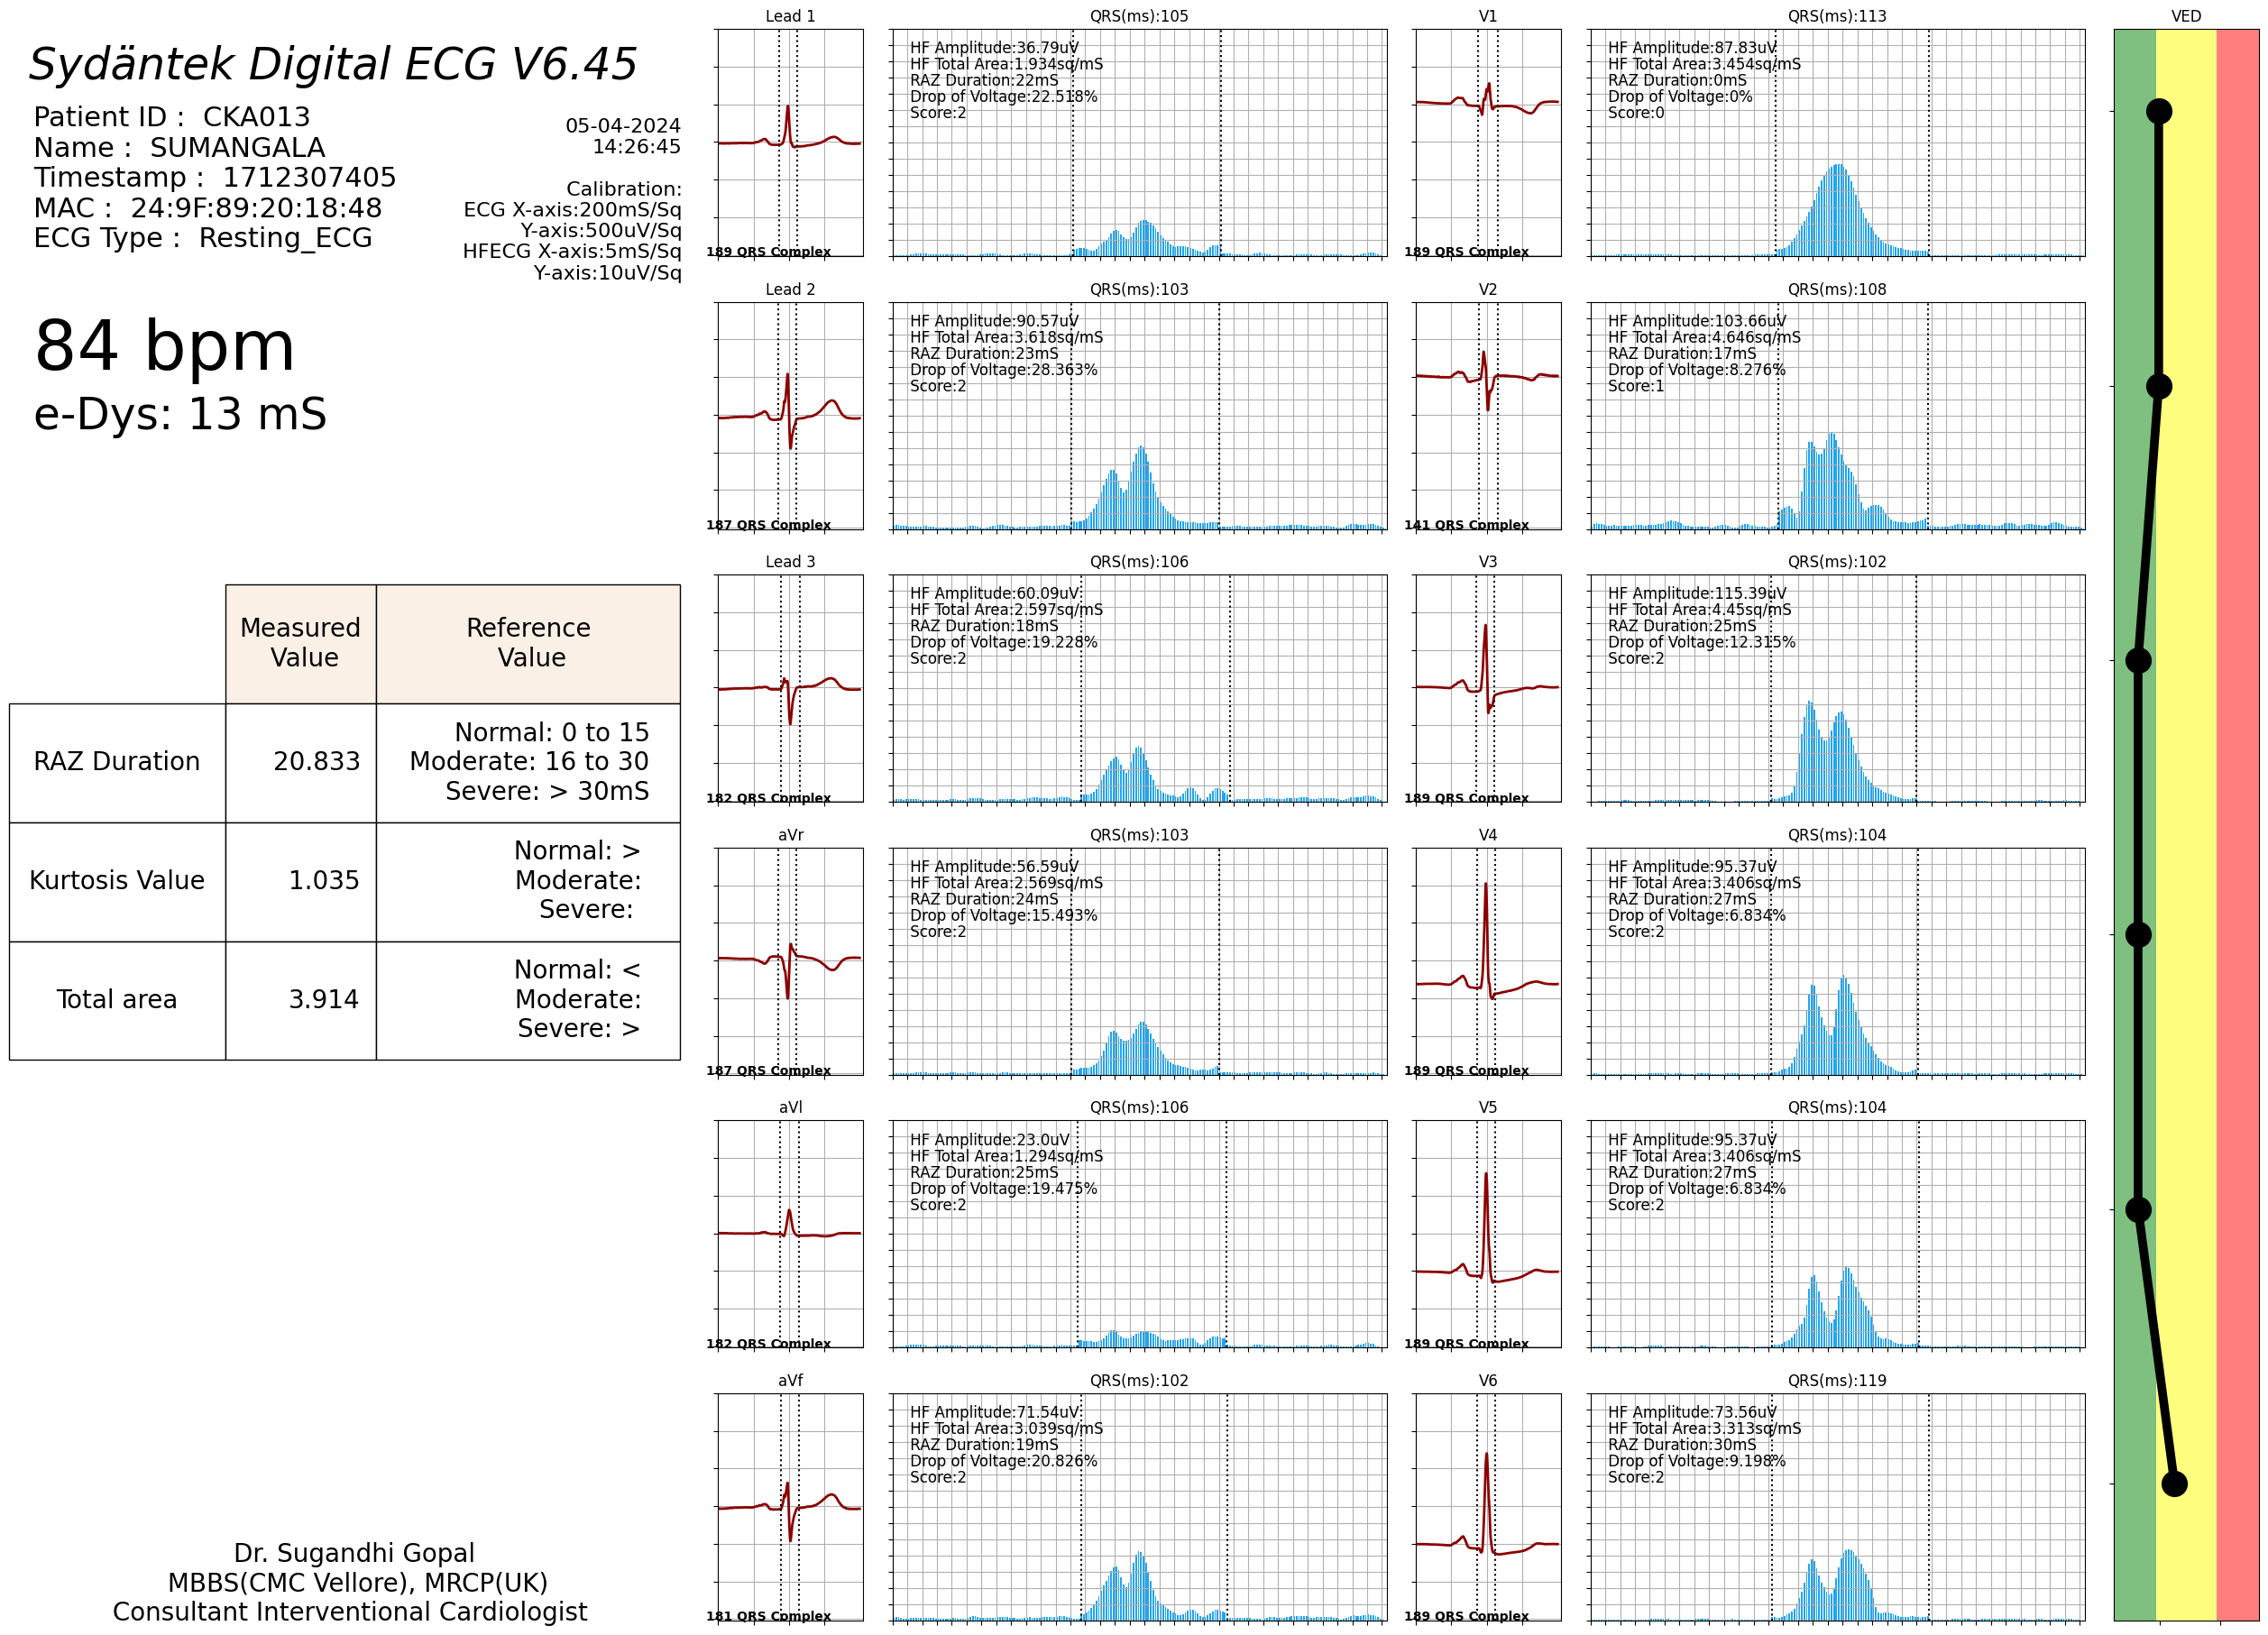

In [ ]:
 #name =  'A C Dinakar'
peaks = R_Peak_Detection_03(v4)
peaks = peaks[1:len(peaks)-2];peak_len = len(peaks);
print(len(peaks))

square_similarity = 0.80; chest_similarity = 0.60
# v3 = v2*0.9;
# v4 = v5*1.1
LL = 150; CL = 150
avl = i-(ii/2)
i_aecg, i_aHF, iecg, iecg_HF,pi,ni,fi = signal_average(i,peaks,square_similarity, hf=LL)
ii_aecg, ii_aHF, iiecg, iiecg_HF,pii,nii,fii = signal_average(ii,peaks,0.60, hf=LL)
iii_aecg, iii_aHF, iiiecg, iiiecg_HF,piii,niii,fiii = signal_average(iii,peaks, 0.70, hf=LL)
r_aecg, r_aHF, recg, recg_HF,pr,nr,fr = signal_average(avr,peaks,square_similarity, hf=LL)
l_aecg, l_aHF, lecg, lecg_HF,pl,nl,fl = signal_average(avl,peaks,square_similarity, hf=LL)
f_aecg, f_aHF, fecg, fecg_HF,pf,nf,ff = signal_average(avf,peaks,square_similarity, hf=LL)
v1_aecg, v1_aHF, v1ecg, v1ecg_HF,p1,n1,f1 = signal_average(v1,peaks,chest_similarity, hf=CL)
v2_aecg, v2_aHF, v2ecg, v2ecg_HF,p2,n2,f2 = signal_average(v2,peaks,chest_similarity, hf=CL)
v3_aecg, v3_aHF, v3ecg, v3ecg_HF,p3,n3,f3 = signal_average(v3,peaks,chest_similarity, hf=CL)
v4_aecg, v4_aHF, v4ecg, v4ecg_HF,p4,n4,f4 = signal_average(v4,peaks,chest_similarity, hf=CL)
v5_aecg, v5_aHF, v5ecg, v5ecg_HF,p5,n5,f5 = signal_average(v5,peaks,chest_similarity, hf=CL)
v6_aecg, v6_aHF, v6ecg, v6ecg_HF,p6,n6,f6 = signal_average(v6,peaks,chest_similarity, hf=CL)

i_e,i_par = env_par_ver65 (i_aHF)
ii_e,ii_par = env_par_ver65 (ii_aHF)
iii_e,iii_par = env_par_ver65 (iii_aHF)
r_e,r_par = env_par_ver65 (r_aHF)
l_e,l_par = env_par_ver65 (l_aHF)
f_e,f_par = env_par_ver65 (f_aHF)
v1_e,v1_par = env_par_ver65 (v1_aHF)
v2_e,v2_par = env_par_ver65 (v2_aHF)
v3_e,v3_par = env_par_ver65 (v3_aHF)
v4_e,v4_par = env_par_ver65 (v4_aHF)
v5_e,v5_par = env_par_ver65 (v5_aHF)
v6_e,v6_par = env_par_ver65 (v6_aHF)

sec = ts_used/4; HR = np.round(peak_len/sec)

RAZ = round((v1_par[4]+v2_par[4]+v3_par[4]+v4_par[4]+v5_par[4]+v6_par[4])/6,3)
score_C = round((v1_par[8]+v2_par[8]+v3_par[8]+v4_par[8]+v5_par[8]+v6_par[8])/1,3)
score_L = round((v1_par[8]+v2_par[8]+v3_par[8]+v4_par[8]+v5_par[8]+v6_par[8])/1,3)
Area = round((v1_par[3]+v2_par[3]+v3_par[3]+v4_par[3]+v5_par[3]+v6_par[3])/6,3)
KUR = round((v1_par[2]+v2_par[2]+v3_par[2]+v4_par[2]+v5_par[2]+v6_par[2])/6,3)

Patient_Details1 = ("Patient ID :  %s \nName :  %s  \nTimestamp :  %d  \nMAC :  %s \nECG Type :  %s \n \n\n"%(trialId,name,ts,macId,His))
HF_Parameters = ("RAZ Score:  %s \nHFECG Amplitude:  %s  \nHFQRS Duration:  %d  \nRMS :  %s \nClinical History :  %s \n \n\n"%(trialId,name,ts,macId,His))

figure = plt.figure(figsize=(32.04,22.92))
row_num = 6; col_num = 13

patient = plt.subplot2grid((row_num, col_num), (0, 0), rowspan=2, colspan=4)
parameter = plt.subplot2grid((row_num, col_num), (2,0), rowspan=2, colspan=4)
sig = plt.subplot2grid((row_num, col_num), (5,0), colspan=4)
ved = plt.subplot2grid((row_num, col_num), (0,12), rowspan=6)

ia = plt.subplot2grid((row_num, col_num), (0, 4), colspan=1); ihf = plt.subplot2grid((row_num, col_num), (0, 5), colspan=3);
iia = plt.subplot2grid((row_num, col_num), (1, 4), colspan=1); iihf = plt.subplot2grid((row_num, col_num), (1, 5), colspan=3)
iiia = plt.subplot2grid((row_num, col_num), (2, 4), colspan=1); iiihf = plt.subplot2grid((row_num, col_num), (2, 5), colspan=3)
ra = plt.subplot2grid((row_num, col_num), (3, 4), colspan=1); rhf = plt.subplot2grid((row_num, col_num), (3, 5), colspan=3)
la = plt.subplot2grid((row_num, col_num), (4, 4), colspan=1); lhf = plt.subplot2grid((row_num, col_num), (4, 5), colspan=3)
fa = plt.subplot2grid((row_num, col_num), (5, 4), colspan=1); fhf = plt.subplot2grid((row_num, col_num), (5, 5), colspan=3)

v1a = plt.subplot2grid((row_num, col_num), (0, 8), colspan=1); v1hf = plt.subplot2grid((row_num, col_num), (0, 9), colspan=3);
v2a = plt.subplot2grid((row_num, col_num), (1, 8), colspan=1); v2hf = plt.subplot2grid((row_num, col_num), (1, 9), colspan=3)
v3a = plt.subplot2grid((row_num, col_num), (2, 8), colspan=1); v3hf = plt.subplot2grid((row_num, col_num), (2, 9), colspan=3)
v4a = plt.subplot2grid((row_num, col_num), (3, 8), colspan=1); v4hf = plt.subplot2grid((row_num, col_num), (3, 9), colspan=3)
v5a = plt.subplot2grid((row_num, col_num), (4, 8), colspan=1); v5hf = plt.subplot2grid((row_num, col_num), (4, 9), colspan=3)
v6a = plt.subplot2grid((row_num, col_num), (5, 8), colspan=1); v6hf = plt.subplot2grid((row_num, col_num), (5, 9), colspan=3)

HR = ('%d bpm'%int(HR))
patient.text(0.5, 0.9, "Sydäntek Digital ECG V6.45   ",fontsize=35, ha = 'center', style = 'italic');
patient.text(0.99,0.5, (date+"\n"+time+"\n\n Calibration:\n ECG X-axis:200mS/Sq\n    Y-axis:500uV/Sq\n HFECG X-axis:5mS/Sq\n       Y-axis:10uV/Sq"),fontsize=16, ha = 'right');
#patient.text(0.99,0.5, (date+"\n"+time+"\n\n,fontsize=16, ha = 'right');
patient.text(0.02, 0.38, Patient_Details1, fontsize=22, ha = 'left');
patient.text(0.02,0.32, HR,fontsize=55,ha = 'left')


columnLabels = ['Measured\n Value','Reference\n Value']
rowLabels = ['RAZ Duration','Kurtosis Value','Total area']

N1 = ' Normal: 0 to 15\n Moderate: 16 to 30\n Severe: > 30mS';
N2 = '  Normal: > \n Moderate: \n Severe:  ';
N3 = '  Normal: < \n Moderate: \n Severe: > '
tableValues = [[RAZ, N1], [KUR, N2], [Area, N3]]
ccolors = np.full(3, 'linen')
table = parameter.table(cellText=tableValues,colWidths=[.2,.1,.1],rowLabels=rowLabels,colLabels=columnLabels,rowLoc='center', colColours=ccolors, bbox = [0.3, 0.03, 0.68, 0.95])
table.auto_set_font_size(False)
table.auto_set_column_width(col=list(range(len(tableValues))))
table.set_fontsize(20); table.scale(2, 8); parameter.axis('off')

sig.text(0.5, 0.0, "Dr. Sugandhi Gopal\n MBBS(CMC Vellore), MRCP(UK)\n Consultant Interventional Cardiologist  " , fontsize=20, ha = 'center'); sig.axis('off')
#sig.text(0.5, 0.0, "King George's Medical University" , fontsize=20, ha = 'center'); sig.axis('off')

###### Averaged ECG
leadplot_ecg(ia,i_aecg,ni,fi,'Lead 1',(0));leadplot_ecg(iia,ii_aecg,nii,fii,'Lead 2',(0))
leadplot_ecg(iiia,iii_aecg,niii,fiii,'Lead 3',(0));leadplot_ecg(ra,r_aecg,nr,fr,'aVr',(0))
leadplot_ecg(la,l_aecg,nl,fl,'aVl',(0));leadplot_ecg(fa,f_aecg,nf,ff,'aVf',(0))

leadplot_ecg(v1a,v1_aecg,n1,f1,'V1',(5));leadplot_ecg(v2a,v2_aecg,n2,f2,'V2',(5))
leadplot_ecg(v3a,v3_aecg,n3,f3,'V3',(0));leadplot_ecg(v4a,v4_aecg,n4,f4,'V4',(-3))
leadplot_ecg(v5a,v5_aecg,n5,f5,'V5',(-5));leadplot_ecg(v6a,v6_aecg,n6,f4,'V6',(-5))

############ averaged HFECG
leadplot_hf_en(ihf,i_aHF,i_e,i_par,pi,ni,fi);leadplot_hf_en(iihf,ii_aHF,ii_e,ii_par,pii,nii,fii);
leadplot_hf_en(iiihf,iii_aHF,iii_e,iii_par,piii,niii,fiii);leadplot_hf_en(rhf,r_aHF,r_e,r_par,pr,nr,fr);
leadplot_hf_en(lhf,l_aHF,l_e,l_par,pl,nl,fl);leadplot_hf_en(fhf,f_aHF,f_e,f_par,pf,nf,ff);

leadplot_hf_en(v1hf,v1_aHF,v1_e,v1_par,p1,n1,f1);leadplot_hf_en(v2hf,v2_aHF,v2_e,v2_par,p2,n2,f2);
leadplot_hf_en(v3hf,v3_aHF,v3_e,v3_par,p3,n3,f3);leadplot_hf_en(v4hf,v4_aHF,v4_e,v5_par,p4,n4,f4);
leadplot_hf_en(v5hf,v5_aHF,v5_e,v5_par,p5,n5,f5);leadplot_hf_en(v6hf,v6_aHF,v6_e,v6_par,p6,n6,f6);

################### Display of VED
y_ved = [1,2,3,4,5,6]  #fake data
x_ved = [v6_par[0],v5_par[0],v4_par[0],v3_par[0],v2_par[0],v1_par[0]]
#x_ved = [169, 169, 200, 210, 206, 210]
print(x_ved)
x0 = np.min(x_ved)-20
ved.plot(x_ved, y_ved, 'k', linewidth=7.0); ved.plot(x_ved, y_ved, 'ko', ms=20)
#ax.margins(0) # remove default margins (matplotlib verision 2+)
VED_diff = abs(((v6_par[0]+v6_par[0])/2) - ((v1_par[0]+v1_par[0])/2))        ########### Printing VED
print(VED_diff)
ved.axvspan(x0, x0+35, facecolor='green', alpha=0.5)
ved.axvspan(x0+35, x0+85, facecolor='yellow', alpha=0.5)
ved.axvspan(x0+85, x0+125, facecolor='red', alpha=0.5)
#ved.set_yticklabels(['v7','V6', 'V5', 'V4', 'V3', 'V2','V1'],fontsize=20)
ved.set_ylim([0.5,6.3]); ved.set_xlim([x0,x0+120])
ved.title.set_text('VED');
ved.set_yticklabels([]); ved.set_xticklabels([]);
patient.text(0.02,0.20, 'e-Dys: %d mS'%int(VED_diff),fontsize=35,ha = 'left')
patient.axis('off')

plt.savefig((savepath+trialId+'_'+His+'.pdf'), bbox_inches='tight')

# **HOLTER CODE**

# Functions & Packages

In [ ]:
!pip install pytz
!pip install neurokit2
!pip install condat-tv

import condat_tv
from google.colab import files
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import math
import pandas as pd
import scipy as sp
from PIL import Image, ImageDraw, ImageFont
from scipy import signal
import collections
import statistics as st
from collections import deque
import time
import matplotlib.backends.backend_pdf
import datetime
from pytz import timezone
import neurokit2 as nk
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.1 MB/s eta 0:00:00


In [ ]:

############# FILETR FUNCTION
def ecg_filters_V5_smooth(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  # for x in  range(1,len(lead_data),1):
  #     if (lead_data[x] == 0):
  #      lead_data[x] = lead_data[x-1]

 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
  #b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter
  h, g = signal.butter(1, [40/500] , btype='low', analog=False)
  j, i = signal.butter(1, [7/500] , btype='low', analog=False)

  filt_BW = signal.filtfilt(b, a, lead_data); filt_SM = (signal.lfilter(j, i, filt_BW))*0.000286;
  filt_LP = (signal.lfilter(h, g, filt_BW))*0.000286

  sparse = filt_LP - filt_SM;
  denoise = condat_tv.tv_denoise(sparse,7.65)
  smooth_data = filt_SM+denoise
  return smooth_data

def ecg_filters_Smooth_holter(lead_data,Fs=1000):
  # lead_data = data_loss(lead_data)
  d, c = sp.signal.butter(7, [25/(Fs/2)] , btype='low', analog=False)
  # b = signal.firwin(1735, cutoff = [3/500], window = "hamming", pass_zero=False); a = 1
  b, a = signal.butter(5, [3/(Fs/2)] , btype='high', analog=False)
  f, e = signal.iirnotch(50, 10, Fs)
  filt_BW = sp.signal.filtfilt(b, a, lead_data)*(0.000286)
  filt_50 = sp.signal.lfilter(f, e, filt_BW)
  filt_45 = sp.signal.lfilter(d, c, filt_50)#*(0.000286)
  smoothed = sp.signal.savgol_filter(filt_45, window_length =51, polyorder = 3)
  return smoothed

def ecg_filters_Smooth_holter_V2(lead_data,Fs=1000): #WITH SMOOTHINING FILTER
  # lead_data = data_loss(lead_data)
  d, c = sp.signal.butter(7, [25/(Fs/2)] , btype='low', analog=False)
  # b = signal.firwin(1735, cutoff = [3/500], window = "hamming", pass_zero=False); a = 1
  b, a = signal.butter(5, [3/(Fs/2)] , btype='high', analog=False)
  f, e = signal.iirnotch(50, 10, Fs)
  h, g = signal.butter(1, [30/500] , btype='low', analog=False)
  j, i = signal.butter(1, [3/500] , btype='low', analog=False)

  filt_BW = sp.signal.filtfilt(b, a, lead_data)*(0.000286)
  filt_50 = sp.signal.lfilter(f, e, filt_BW)
  filt_SM = (signal.lfilter(j, i, filt_50))
  filt_LP = (signal.lfilter(h, g, filt_50))*0.000286

  sparse = filt_LP - filt_SM;
  denoise = condat_tv.tv_denoise(sparse,7.65)
  smooth_data = filt_BW+denoise
  return filt_50

def ecg_filters_Rpeak(lead_data):
  d, c = sp.signal.butter(6, [25/500] , btype='low', analog=False)
  #b = signal.firwin(1735, cutoff = [5/500], window = "hamming", pass_zero=False); a = 1 ########### Baseline filter for Display
  b, a = signal.cheby1(4, 1, [7/500], 'high', analog=False) ############ Baseline filter for R Peak detation
  filt_BW = sp.signal.filtfilt(b, a, lead_data)*0.000286
  filt_45 = sp.signal.lfilter(d, c, filt_BW)
  return filt_45

def ecg_filters_V5_01(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  # for x in  range(1,len(lead_data),1):
  #     if (lead_data[x] == 0):
  #      lead_data[x] = lead_data[x-1]

 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter
  h, g = sp.signal.butter(4, [145/500] , btype='low', analog=False)

  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  filt_50 = sp.signal.lfilter(d, c, filt_BW); filt_100 = sp.signal.lfilter(f, e, filt_50)
  filt_LP = sp.signal.lfilter(h, g, filt_50)
  smoothed = sp.signal.savgol_filter(filt_LP, window_length =51, polyorder = 3)
  return smoothed

############ FETCH DATE AND TIME FROM TIMESTAMP
def get_time_from_timestamp(timestamp):
  read_able = datetime.datetime.fromtimestamp(timestamp)
  now_asia = str(read_able.astimezone(timezone('Asia/Kolkata'))); #print(now_asia)
  year = now_asia[0:10]
  year = year[8:10]+"-"+year[5:7]+"-"+year[0:4]
  time = now_asia[11:19]
  return (year,time)

########### DATA ADDITION
def Data_addidtion(input_signal, lines_per_page):
  LEN = len(input_signal)/15000
  reminder=LEN%lines_per_page; count = 0
  endBuff = collections.deque(np.full([15000,],2000,dtype=int))
  while (reminder%lines_per_page)!= 0:
    count = count+1
    input_signal = np.concatenate((input_signal, endBuff))
    reminder = (len(input_signal)/15000)%lines_per_page
  return input_signal

########### HEART RATE & R-DETECTION
def RR_calculation11(input_signal):
  # input_signal=data_loss(input_signal)
  # b = sp.signal.firwin(1735, cutoff = [3/500], window = "hamming", pass_zero=False); a = 1 ;  filt_BW = sp.signal.filtfilt(b, a, input_signal)
  # d, c = sp.signal.butter(15, [35/500] , btype='low', analog=False); filtered = sp.signal.lfilter(d, c, filt_BW);#filtered = filtered*filtered;
  filtered = ectopic_filters(input_signal)
  peaks,rpeak = sp.signal.find_peaks(filtered,distance = 300,height=(max(filtered[1000:5000])/2))
  IntRR=np.empty(len(peaks)-1)
  for i in range(1,len(peaks)):
    ch = peaks[i]-peaks[i-1]
    if ch>250: IntRR[i-1] = ch;
  return (peaks, IntRR)

def HeartRate_parameters11(Rpeak_buff,RRinterval,input_signal):
  # Rpeak_buff,RRinterval = RR_calculation11(input_signal); #print("RR_interval :",RRinterval)
  # Avg_HR = int(round((60*Fs)/np.mean(RRinterval)))   # average heart rate
  normalRR = []; pause_duration = []; pause_location = []; loc = len(input_signal)-np.sum(RRinterval); ch = 0
  for k in RRinterval:
    if k>=2000:
      pause_duration.append(k); pause_location.append(loc)
    elif k>250 and k<3000:
      normalRR.append(k); loc = int(loc+k)

  if len(normalRR)>=2:
    max_HR = int(round((60*Fs)/np.min(normalRR)));  #print("max ",np.min(normalRR))
    min_HR = int(round((60*Fs)/np.max(normalRR))); #print("min ",np.max(normalRR))
    Avg_HR = int(round((60*Fs)/np.mean(normalRR)))   # average heart rate
  else: max_HR=math.nan; min_HR=math.nan; Avg_HR=math.nan
  HeartRate = [Avg_HR, max_HR, min_HR]; #print(HeartRate)
  Pause_det = [pause_duration, pause_location]
  return (HeartRate, Pause_det)

def SVT_check(peaks, RR_int):
  i=0; SVT_beat=0; SVT_episode = 0
  SVT_st = collections.deque(); SVT_sp = collections.deque()
  while i<len(RR_int):
    if RR_int[i]<=460:
      SVT_st.append(peaks[i])
      while RR_int[i]<=460:
        SVT_beat = SVT_beat+1
        sp = peaks[i]
        i=i+1
      SVT_st.append(peaks[i-SVT_beat]); SVT_sp.append(sp);
      SVT_episode = SVT_episode+1
      SVT_beat=0
    else:
      i=i+1
  return(SVT_episode, SVT_st, SVT_sp)


############ NOISE DETECTION
# def data_loss(input_signal):
#   for x in  range(1,len(input_signal)-1,1):    #### data loss
#     if (input_signal[x] == 0):
#       input_signal[x] = input_signal[x-1] #st.mean([input_signal[x-1], input_signal[x+1]])
#   return (input_signal)

def SNR_estimation(data):
  Data = np.array(data)
  ideal_SNR = 2
  b, a = sp.signal.butter(7, [35/500] , btype='low', analog=False); sig = sp.signal.filtfilt(b, a, Data)
  d, c = sp.signal.butter(7, [35/500] , btype='high', analog=False); nos = sp.signal.filtfilt(d, c, Data)
  def SNR_Cal(sig,noi):
    return (np.sqrt(np.mean(sig**2)))/(np.sqrt(np.mean(noi**2)))
  SNR_seg = SNR_Cal(Data,nos); #print(SNR_seg)
  if (SNR_seg > ideal_SNR):
    return (1)    #### Good Segment
  else:
    return (0)   #### Bad Segment

def movement_artifact(data):
  avg_val = round(np.mean(data));
  range_lower = round(np.min(data)); range_higher = round(np.max(data))
  lower_deviation = np.subtract(avg_val,range_lower); higher_deviation = np.subtract(range_higher,avg_val)
  if ((lower_deviation<=10 and lower_deviation>=1) and (higher_deviation<=10 and higher_deviation>=1)):
    return (1)    #### Good Segment
  else:
    return(0)     #### Bad Segment

def Noise_estimation(data):
  count = 0; window = 5000; data_buff = []; segment = []
  b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
  num = (sp.signal.filtfilt(b, a, data))*0.000286   #baseline filter
  # num = data_loss(num)      #eliminating data loss
  noise_coeff = 0
  for t in num:
      data_buff.append(t)
      count  = count +1
      if count == window:
        Criteria1 = movement_artifact(data_buff);   Criteria2 = SNR_estimation(data_buff)
        count = 0
        if (Criteria1==1) and (Criteria2==1):
          noise_coeff=noise_coeff+1    #no noise
  return noise_coeff

###########   MACHINE DISSCONNECT FOR 15 SEC
def machine_diconnect_15sec(input_frame):
  zerocount = 0; startloc=0
  MD = False; i=0
  while (MD!=True)and(i!=len(input_frame)):
    if input_frame[i]==0:zerocount = zerocount+1
    else:zerocount = 0
    if zerocount>=1000:
      MD=True; startloc=i-zerocount
    i+=1
  if MD==True:
    k=len(input_frame)-startloc; l=k*10; t = np.linspace(0, 2, 15000-startloc, endpoint = True)
    dis_seg=sp.signal.square(2 * np.pi * l * t)*20000
    print(len(input_frame[0:startloc]))
    outdata = np.array(np.concatenate((input_frame[0:startloc],dis_seg)))
    return(outdata, MD)
  else: return (input_frame, MD)

########### READING ALL TIMESTAMP DATA
def read_ECG(start_timestamp, MAC, read='all'):

  #
  ts=start_timestamp
  lead1=collections.deque(); lead2=collections.deque(); lead3=collections.deque()
  v1_lead=collections.deque(); v2_lead=collections.deque(); v3_lead=collections.deque();
  v4_lead=collections.deque(); v5_lead=collections.deque(); v6_lead=collections.deque();
  tscount=0; skip=0; Tmax=0
  bufferloop = {}; fra = {}; buffer = client.fetch(MAC,(start_timestamp)); frame =  buffer.frame
  Patient_name=buffer.patient_name; Phone_number=buffer.patient_phone
  print(Patient_name, Phone_number)

  if read=='all': end=True; read=False
  else: end=0
  year=[]; time=[]; time_all=[]; stamplist=[]; stamplist_2=[]
  while end!=read:
    bufferloop = {}; fra = {}; buffer = client.fetch(MacId,(ts));
    if buffer != None:
      if (buffer.patient_name==Patient_name) and (buffer.patient_phone==Phone_number):
        skip=0;
        frame=buffer.frame; #print(Tmax, Patient_name, MacId, ts)
        data1=frame.i; data2=frame.ii; data3=frame.v1; data4=frame.v2;
        data5=frame.v3; data6=frame.v4; data7=frame.v5; data8=frame.v6
        stamplist.append(start_timestamp+(15*Tmax))
        y,t=get_time_from_timestamp(ts)
        time_all.append(t); year.append(y)
        # if (Tmax%3)!=0:
        #   time.append(t); stamplist_2.append(ts)
        for i in range(len(data1)):
          lead1.append(data1[i]); lead2.append(data2[i]); v1_lead.append(data3[i]); v2_lead.append(data4[i]);
          v3_lead.append(data5[i]); v4_lead.append(data6[i]); v5_lead.append(data7[i]); v6_lead.append(data8[i])
        ts=ts+15; c=0; Tmax +=1; #print(Tmax)
        if isinstance(end, int)==True: end+=1
    elif skip<=12:
      ts=ts+15; skip=skip+1; print("skip ",skip, ts)
    else:
      print("End of patient data")
      break;
  print("Number of Timestamps read : ",int(len(lead1)/15000))
  print(len(stamplist))

  Patient_det = [Patient_name, Phone_number]
  Date_frame = pd.DataFrame(list(zip(time_all, year)),columns=['All_Time','Date'])
  TS_Frame = pd.DataFrame(list(zip(stamplist)),columns=['All_Timestamp'])
  lead2 = np.array(lead2); lead1 = np.array(lead1);
  lead3 = lead2-lead1 ; avr_lead = -(lead2+lead1)/2; avl_lead = lead1-(lead2/2); avf_lead = lead2-(lead1/2);
  lead_frame = pd.DataFrame(list(zip(lead1,lead2,lead3,avr_lead,avl_lead, avf_lead,v1_lead,v2_lead,v3_lead,v4_lead,v5_lead,v6_lead)),
                            columns =['Lead_1','Lead_2','Lead_3','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'], dtype = float)
  return(Patient_det, lead_frame, Date_frame, TS_Frame)

def Value_axis(data_dict,value):
  data=list(data_dict.items())
  an_array=np.array(data)
  Values_1=an_array[value]
  Values_2=np.asarray(Values_1[1])
  return Values_2

############     ECTOPIC DETECTION
def bandpass(low, high, fs=1000, order=25):
    return sp.signal.butter(order, [low, high], fs=fs, btype='bandpass',
    #return sp.cheby1(4, 1, [low, high], btype='bandpass', analog=True,
    output='sos')

def ectopic_filters(signal):
  lead_data = signal #data_loss(signal)
  Baseline = sp.signal.medfilt(lead_data, kernel_size=401)
  BW_Filtered = lead_data - Baseline
  sos = bandpass(0.5, 20,fs=1000, order=3)
  filtered = (sp.signal.sosfilt(sos, BW_Filtered))
  return filtered

def QRS(complex):
  comp = complex; diff = np.diff(comp,n=1); sqr = np.square(diff); norm = sqr/max(sqr)
  count_on = 0; count_off = 0
  for i in range(0,100):
    if norm[i]<0.005:count_on = count_on+1
    QRSON = 0+count_on
  for i in range(150,249):
    if norm[i]<0.006: count_off = count_off+1
    QRSOFF = 249-count_off
  return (QRSOFF - QRSON)

def find_ectopic(signal, template):
  peaks,rpeak = sp.signal.find_peaks(signal,distance = 400,height=(max(signal[1000:5000])/4))
  peaks = peaks[1:len(peaks)-1];peak_len = len(peaks) ## 1st and last peak removed to avoid incomplete beats/complex
  Ramp = Value_axis(rpeak,0); Ramp = Ramp[0:len(Ramp)-1]
  AUC = collections.deque(); RR_int = collections.deque();
  ##    LIST OF RR INTERVALS
  for i in range(1, len(peaks)):    RR_int.append(peaks[i]-peaks[i-1])
  ##    INDIVIDUAL COMPLEX EXTRACTION
  com_width = round(Fs//(8));
  ecg = np.zeros((peak_len,com_width*2)); start_p = np.empty([peak_len],dtype=int); end_p = np.empty([peak_len],dtype=int)
  for i in  range(peak_len):
    start_p[i] = peaks[i]-com_width; end_p[i] = peaks[i]+com_width
    ecg[i] = signal[start_p[i]:end_p[i]]
  ##   LIST OF AREA UNDER THE CURVE
  for j in ecg:
    area = np.trapz(j);
    AUC.append(area)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(peaks, dtype=float); PVC_list[:] = np.NaN
  SVC_list = np.empty_like(peaks, dtype=float); SVC_list[:] = np.NaN
  AUC = np.array(AUC); prev_ect=0
  for i in range(1, len(RR_int)):
    if len(AUC[0:i-1])!=0: medAUC = st.median(AUC[0:i-1])
    else: medAUC= AUC[0]
    if RR_int[i]>=(1.6*RR_int[i-1]):
      if AUC[i]>(1.3*medAUC):
        PVC_list[i] = peaks[i]
      else: # less area undercurve
        SVC_list[i] = peaks[i]
  return SVC_list, PVC_list, len(SVC_list)

############    FETCHING SPECIFIED LEAD FROM DATAFRAME
def fetch_lead(Lead):
  if Lead=='1': return  (np.array(LeadFrame.Lead_1))
  elif Lead=='2': return (np.array(LeadFrame.Lead_2))
  elif Lead=='3': return (np.array(LeadFrame.Lead_3))
  elif Lead.casefold()=='avr': return (np.array(LeadFrame.AVR))
  elif Lead.casefold()=='avl': return (np.array(LeadFrame.AVL))
  elif Lead.casefold()=='avf': return (np.array(LeadFrame.AVF))
  elif Lead.casefold()=='v1': return (np.array(LeadFrame.V1))
  elif Lead.casefold()=='v2': return (np.array(LeadFrame.V2))
  elif Lead.casefold()=='v3': return (np.array(LeadFrame.V3))
  elif Lead.casefold()=='v4': return (np.array(LeadFrame.V4))
  elif Lead.casefold()=='v5': return (np.array(LeadFrame.V5))
  elif Lead.casefold()=='v6': return (np.array(LeadFrame.V6))
  else : return (np.array(LeadFrame.Lead_2))

###########   GENERATING REPORT : 1TS per line/ heart rate and pause/ plot and create pdf in patient name
def Report_generation(Lead, Patient, MacId, Date, TS, HIS, Timestamp_per_line=1,lines_per_page=60, Noise_detection=True):
  buff=fetch_lead(Lead);  buff = collections.deque(Data_addidtion(buff, lines_per_page))
  temp_buff =  np.array(buff)
  page=0; tsum=0; line=[]; linecount=lines_per_page;
  HRV_line =[]; TotPause =[]; MaxHR = []; MinHR = [];
  countlen=len(buff); samples_per_line = 15000*Timestamp_per_line
  _,time = get_time_from_timestamp(Timestamp)
  HolterTitle = 'SYDÄNTEK Short Holter'; plot_header=("%s       %s      Start:%d      Date:%s %s"%(Patient[0],MacId,Timestamp,Date.at[0,'Date'],str(time)))
  filtered = ectopic_filters(temp_buff[0:6000])
  peaks,rpeak = sp.signal.find_peaks(filtered,distance = 400,height=(max(filtered[1000:5000])/4))
  com_width = round(Fs//(8)); start_p = peaks[1]-com_width; end_p = peaks[1]+com_width
  template = filtered[start_p:end_p]

  ########### HOLTER LINE PLOTTING
  def plotting_ver1(sig, iteration):
    sig=data_loss(sig); SV_len = 0; PV_len = 0; NB_len = 0
    sig, state = machine_diconnect_15sec(sig)
    if state==False:    ##no disconnect
      HR_line, Pause_line = HeartRate_parameters11(ecg_filters_Rpeak(sig))
      HRV_line.append(HR_line[0]); MaxHR.append(HR_line[1]); MinHR.append(HR_line[2])
      SV, PV, NB = find_ectopic(sig, template);
      ax[iteration].plot(h,(ecg_filters_V5_01(sig)),'k',linewidth=0.4);  ###########################  Gain adjustement
      for n in SV:
        ax[iteration].axvspan(n-150, n+150, alpha=0.2, color="green")
        if math.isnan(n)==False: SV_len = SV_len+1
      for n in PV:
        ax[iteration].axvspan(n-150, n+150, alpha=0.2, color="green")
        if math.isnan(n)==False: PV_len = PV_len+1
      if len(Pause_line[0])!=0:
        TotPause.append(Pause_line[0]);
      ax[iteration].text(15050,0,str(HR_line[0]),color='blue',fontsize=7);
    else:   ##disconnect
      ax[iteration].plot(h,sig,'k',linewidth=0.4);
    NB_len = 0 #NB-SV_len-PV_len+1
    return (SV_len, PV_len, NB_len)

  while countlen!=0:
    plt.figure(page); fig, ax = plt.subplots(linecount+7,figsize=(8.27,11.69));
    ax[0].set_title(HolterTitle,color='purple', fontstyle='italic',fontsize=17); ax[0].text(-0.05,0,plot_header,fontsize=10, color='green')
    ax[0].set_yticklabels([]); ax[0].set_xticklabels([]); ax[0].axis('off')
    page_det = ("Page %d"%(page+1)); Atrialcount = 0; Ventricularcount = 0; Tot_beat = 0;
    for j in range(1,linecount+1):
      for i in range(samples_per_line):
        line.append(buff.popleft())
        countlen = countlen-1
      line=np.array(line); h = np.arange(0,len(line))
      if max(line[0:samples_per_line])!=2000:
        ax[j].text(-1700,0,str((TS.at[j-1+(20*page),'All_Timestamp'])),fontsize=7)
        if Noise_detection==True:
          if Noise_estimation(line)==1: ##if sample is clean
            SVC, PVC, Norm_beats = plotting_ver1(line, j);
            Tot_beat = Tot_beat+Norm_beats
            Atrialcount = Atrialcount+SVC
            Ventricularcount = Ventricularcount+PVC
          else: ## if sample is noisy
            l = 30; t = np.linspace(0, 1, samples_per_line, endpoint = True);
            line = deque(sp.signal.square(2*np.pi*l*t)*2); ax[j].plot(h,line,'k',linewidth=0.4);
        else:
          SVC, PVC, Norm_beats = plotting_ver1(line, j);
          Tot_beat = Tot_beat+Norm_beats
          Atrialcount = Atrialcount+SVC
          Ventricularcount = Ventricularcount+PVC
      else:   ##end of ecg blank plot
        ax[j].plot(0);
      line=deque(line)
      ax[j].set_yticklabels([]); ax[j].set_xticklabels([]); ax[j].set_ylim(-4,8); ax[j].set_xlim(-1500,15050); ax[j].axis('off')
      k = j+1; line.clear()
    print('Atrial Ectopic :%d         Ventricular Ectopic :%d'%(Atrialcount,Ventricularcount))
    # Ectopic_det = ('Atrial Ectopic : %d        Ventricular Ectopic : %d' %(Atrialcount,Ventricularcount))
    Ectopic_det = ('Atrial Ectopic :       Ventricular Ectopic : ')
    ax[k].text(0.1,0.1,"Average heart rate : %d bpm         Total Normal beats : "%(int(np.mean(HRV_line))), horizontalalignment='left',ma='right',fontsize=10,color='blue');ax[k+3].set_yticklabels([]);ax[k+3].set_xticklabels([]);ax[k+3].axis('off')
    ax[k+1].text(0.1,0.1,("Maximum heart rate : %d bpm         Minimum heart rate : %d bpm"%(max(HRV_line),min(HRV_line))), horizontalalignment='left',ma='left',fontsize=10,color='blue');ax[k].set_yticklabels([]);ax[k].set_xticklabels([]);ax[k].axis('off')
    ax[k+2].text(0.1,0.1,Ectopic_det, horizontalalignment='left',ma='left',fontsize=10,color='blue');ax[k+1].set_yticklabels([]);ax[k+1].set_xticklabels([]);ax[k+1].axis('off')
    ax[k+4].text(0.1,0.1,("PAUSE: %d"%len(TotPause)), horizontalalignment='left',ma='left',fontsize=10,color='blue');ax[k+2].set_yticklabels([]);ax[k+2].set_xticklabels([]);ax[k+2].axis('off')
    ax[k+4].text(0.1,0.1," ", horizontalalignment='left',ma='left',fontsize=10,color='blue');ax[k+4].set_yticklabels([]);ax[k+4].set_xticklabels([]);ax[k+4].axis('off')
    ax[k+5].text(0.1,0.1,page_det, horizontalalignment='right',ma='right',fontsize=8,color='black');ax[k+4].set_yticklabels([]);ax[k+5].set_xticklabels([]);ax[k+5].axis('off')
    HRV_line.clear() ; TotPause.clear() ; MaxHR.clear(); MinHR.clear; EctopicCount_page=0
    page+=1;

  ### creating and storing PDF
  pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/"+Name+"_"+Date.at[0,'Date']+"_holter.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Holter Report/Testing/"+Date.at[0,'Date']+"_"+Name+".pdf")
  for fig in range(1, plt.gcf().number + 1): pdf.savefig( fig, bbox_inches='tight',pad_inches=0.0 )
  pdf.close()



################ REGULAR IRREGULAR RHYTHM CHECKING
def Rhythm_Check(lead_data):
  b = sp.signal.firwin(1735, cutoff = [3/500], window = "hamming", pass_zero=False); a = 1 ;  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  d, c = sp.signal.butter(15, [35/500] , btype='low', analog=False); filtered = sp.signal.lfilter(d, c, filt_BW);filtered = filtered*filtered;
  peaks,rpeak = sp.signal.find_peaks(filtered,distance = 400,height=(max(filtered[1000:5000])/4))
  RR_int = []
  for j in range (0,len(peaks)-1):
    diff = (peaks[j+1]) - (peaks[j])
    RR_int.append(diff)
  st_dev = np.std(RR_int)
  if (st_dev<120):
    return(1);# print('Regular Rhythm')
  else:
    return(0);# print('Irregular Rhythm')

############# X AXIS PARAMETERS VER_1
def ecg_filters_Xparameter(lead_data):
  d, c = sp.signal.butter(3, [45/500] , btype='low', analog=False)
  #d = signal.firwin(511, cutoff = [150/500], window = "hamming", pass_zero=True); a = 1
  b = sp.signal.firwin(1735, cutoff = [0.8/500], window = "hamming", pass_zero=False); a = 1
  #b, a = sp.butter(5, [0.5/500] , btype='high', analog=False)
  filt_BW = sp.signal.filtfilt(b, a, lead_data)
  filt_45 = sp.signal.lfilter(d, c, filt_BW)
  return filt_45

def Xparameter_calculation(ecg_signal):
  Fs=1000
  ecg_signal = ecg_filters_Xparameter(ecg_signal)
  peaks, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=Fs)
  ##----------- HR and RR-interval -----------##
  R_peak=peaks.ECG_R_Peaks; peak=[]
  for k in range(len(R_peak)):
    peak.append(R_peak[k])
  df = pd.DataFrame.from_dict(rpeaks); #print(df)
  peaklocations = df.ECG_R_Peaks; IntRR=np.empty(len(peaklocations)-1)
  for i in range(1,len(peaklocations)):
    ch = peaklocations[i]-peaklocations[i-1]
    if ch<2000: IntRR[i-1] = ch;
  for j in range(0,len(IntRR)-1):
    if IntRR[j]<=500: IntRR[j]=st.mean([IntRR[j-1],IntRR[j+1]])
  avg_RR = np.mean(IntRR); print('AVG RR:',int(avg_RR))
  HeartRate = (60*Fs)/avg_RR; print("HR:",int(HeartRate))
  ##----------- QRS, PR, QT, QTC ------------##
  signal_cwt, waves_cwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=Fs, method="cwt")
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=Fs, method="dwt")
  P_Onset=Value_axis(waves_dwt,1); #print("P on:", P_Onset)
  R_Onset=Value_axis(waves_dwt,4); #print("R_Onset:",R_Onset)
  QRS_Offset=Value_axis(waves_cwt,5); #print("QRS_Offset:", QRS_Offset)
  QRS_Onset=Value_axis(waves_cwt,4); #print("QRS_Onset:",QRS_Onset)
  T_Offset=Value_axis(waves_cwt,9); print("T_Offset:",T_Offset)
  T_Peaks=Value_axis(waves_cwt,8); print("T_Peaks:",T_Peaks)

  QRS_interval=avg_intervalcalculation(QRS_Onset,QRS_Offset); print("QRS int:", QRS_interval)
  PR_interval=avg_intervalcalculation(P_Onset,R_Onset); print("PR int:", PR_interval)
  QT_interval=avg_intervalcalculation(QRS_Onset,T_Offset); print("QT neuro:", QT_interval)
  if QT_interval<300:
    T_Off=[]
    for i in range(len(T_Peaks)):
      st_p=T_Peaks[i]; en_p=T_Peaks[i]+200
      counter=0
      for j in range(st_p,en_p):
        counter=counter+1
        if(ecg_signal[j]<0):
          T_Off.append(st_p+counter)
          break
    QT_interval=avg_intervalcalculation(QRS_Onset,T_Off);  print("QT code:", QT_interval)
  QTc=(QT_interval+1.75*(HeartRate-60)); print("QTc :",QTc)
  return(HeartRate, PR_interval, QRS_interval, QT_interval, QTc)

def avg_intervalcalculation(start_pt,stop_pt):
  count=0;interval_average=0
  for d in range(0,min(len(start_pt),len(stop_pt))):
    if np.isnan(start_pt[d])!=True and np.isnan(stop_pt[d])!=True:
      interval_average=interval_average+(stop_pt[d]-start_pt[d])
      count=count+1
  interval_average=interval_average/count
  return(interval_average)

# Data Reading Block

User is only required to define 3 parameter:
1. Start Timestamp
2. Mac ID
3. Number of timestamps to read: Recomended to read 60 timestamps. If not defined by user, the code will by default read all the timestamps.

In [ ]:
Fs=1000
BW = int((Fs)-1)

# CKH1094	CKS2011 NARASIMHA MURTHY		55 M	9845557035	AM	24:9F:89:20:18:24	1701489945	12 Lead	pacemaker settings
# CKH1095	CKS2014 M NAGARAJA BABU 	68	M	9480319936		24:9F:89:20:18:24	1701496185	12 Lead

MacId = '24:9F:89:20:18:48'
Timestamp = 1712296350 #+ (15*301)
[Name,Number], LeadFrame, Date, TS = read_ECG(Timestamp, MacId, read=20)

Name = 'CKA001    Dr Rajashekar  '; print(Name);Name = Name.upper()
Age = '/M'
read_lead = 'v5'     #Options: 1, 2, 3, avl, avr, avf, v1, v2, v3 ,v4, v5, v6




Dr Rajadhekar Ananya Hospital 9845742165
Number of Timestamps read :  20
20
CKA001    Dr Rajashekar  


# Report Testing Block Version 3


Total peaks detected :  275


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

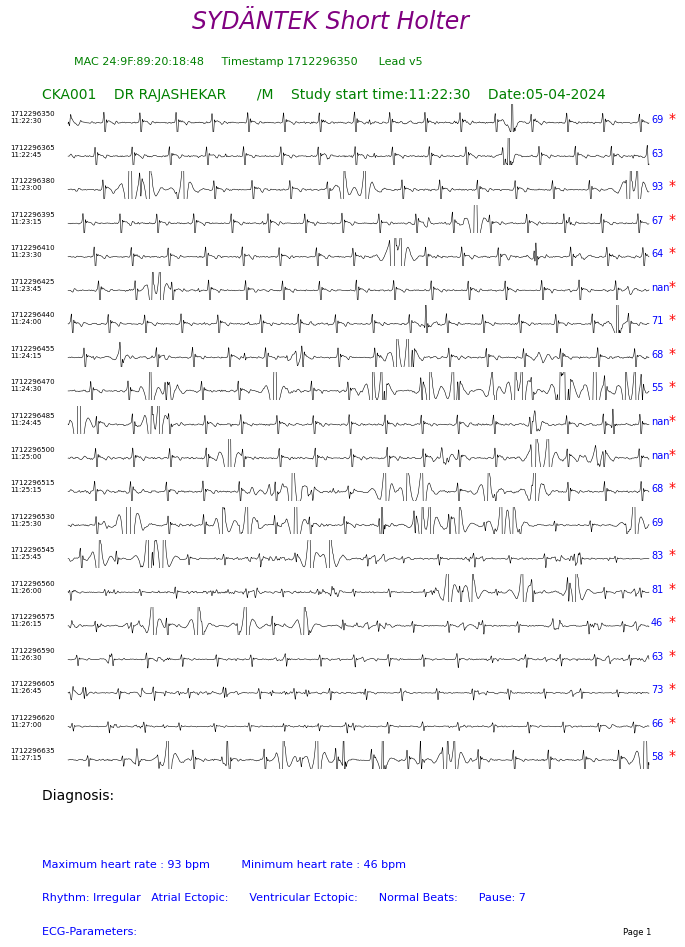

In [ ]:
trialcount = 0; Ventricularcount = 0; Tot_beat = 0;


def Rhythm_Check_ver2(lead_data, iteration):
  _,RR_int = RR_calculation11(lead_data)
  st_dev = np.std(RR_int); RC=0
  if (st_dev<90):
    # print("st_dev :", st_dev)
    ax[iteration].text(15500,0,'*',color='white',fontsize=10);
    RC = RC
    # return(1);# print('Regular Rhythm')
  else:
    ax[iteration].text(15500,0,'*',color='red',fontsize=10);
    RC = RC+1; #print("Iregular st_dev :", st_dev, RR_int)
    # return(0);# print('Irregular Rhythm')
  return RC

def plotting_ver2(sig, iteration):
  # sig=data_loss(sig); # SV_len = 0; PV_len = 0; NB_len = 0
  sig, state = machine_diconnect_15sec(sig)
  # secs = len(sig)/Fs; samps = int(secs*100) ;  sig_disp = (sp.signal.resample(ecg_filters_V5_01(sig*0.000286), samps));
  if state==False:    ##no disconnect
    RC = Rhythm_Check_ver2(sig, iteration)
    # HR_line, Pause_line = HeartRate_parameters11(ecg_filters_Rpeak(sig))
    Rpeak, RR_int = RR_calculation11(ecg_filters_Rpeak(sig))
    HR_line, Pause_line = HeartRate_parameters11(Rpeak, RR_int,sig)
    # SVT_count, SVT_start, SVT_Stop = SVT_check(Rpeak, RR_int)
    HRV_line.append(HR_line[0]); MaxHR.append(HR_line[1]); MinHR.append(HR_line[2])
    # ax[iteration].plot(h,ecg_filters_V5_smooth(sig)*1,'k',linewidth=0.4);
    ax[iteration].plot(h,ecg_filters_Smooth_holter(sig)*1,'k',linewidth=0.4);
    # if SVT_count!=0:
    #   for i in range(len(SVT_start)):
    #     ax[iteration].axvspan(SVT_start[i]+((iteration-2)*samples_per_line/1000)-50, SVT_Stop[i]+((iteration-2)*samples_per_line/1000)+50, alpha=0.2, color="yellow")
    # # ax[iteration].plot(sig_disp*1.5,'k',linewidth=0.4);
    if len(Pause_line[0])!=0:
      TotPause.append(Pause_line[0]);
    ax[iteration].text(15050,0,str(HR_line[0]),color='blue',fontsize=7);
  else:   ##disconnect
    ax[iteration].plot(h,sig[0:15000],'k',linewidth=0.4);
    RC = 0
  return RC

def detect_ectopic_beats(ecg_signal_peak, threshold):
  # Calculate the difference between consecutive R-R intervals
  rr_intervals = np.diff(ecg_signal_peak)
  # print("RR int 2: ",rr_intervals)
  # Calculate the mean and standard deviation of the R-R intervals
  rr_mean = np.mean(rr_intervals); #print("Mean RR :",rr_mean)
  rr_std = np.std(rr_intervals); #print("STD RR :",rr_std, rr_std*threshold)
  ectopic_beats = []; ectopic_idx = []
  # Detect ectopic beats based on the threshold
  for i in range(0, len(rr_intervals)):
      if abs(rr_intervals[i] - rr_mean) > threshold * rr_std:
          ectopic_beats.append(ecg_signal_peak[i+1]); ectopic_idx.append(i)
  return ectopic_beats

def find_PVC(signal, Rpeaks):
  RRinterval = np.diff(Rpeaks); print(RRinterval)
  ##   LIST OF AREA UNDER THE CURVE
  AUC = collections.deque(); NB=0
  # for k in Rpeaks:
  #   ch=abs(np.round(np.trapz(signal[k-80:k+80])));AUC.append(ch)
  #   # print("median : ",ch, 1.3*st.median(AUC))
  # AUC = np.array(AUC); #print(AUC)
  ##    ECTOPIC FUNCTION
  PVC_list = np.empty_like(Rpeaks, dtype=float); PVC_list[:] = np.NaN
  # SVC_list = np.empty_like(Rpeaks, dtype=float); SVC_list[:] = np.NaN
  for i in range(1,len(RRinterval)):
    if RRinterval[i]>=(1.2*RRinterval[i-1]):
          PVC_list[i] = Rpeaks[i]

      # if Ramplitued[i]>=(Ramplitued[i-1]+(0.2*Ramplitued[i-1])):#PVC
        # if AUC[i-1]>(1.3*st.median(AUC[0:i-1])):
          # PVC_list[i] = Rpeaks[i]
    else: NB=NB+1
        # else: #SVC or PVC
        #   if i>1:
        #     if AUC[i]>(1.3*st.mode(AUC[0:i-1])):
        #       PVC_list[i] = Rpeaks[i]
  return (np.array(PVC_list), NB)

# def Report_generation(Lead, Patient, MacId, Date, TS,HIS, Timestamp_per_line=1,lines_per_page=60, Noise_detection=True):
lines_per_page=20
Noise_detection=False
Timestamp_per_line=1
# read_lead = '1'
buff=fetch_lead(read_lead);
# buff1 = fetch_lead(read_lead);buff2 = np.concatenate((buff,buff1))

buff = collections.deque(Data_addidtion(buff, lines_per_page))
ect_buff =  np.array(buff)

page=0; line=[]; linecount=lines_per_page;
HRV_line =[]; TotPause =[]; MaxHR = []; MinHR = [];
HRV_plot = [];
RhythmCount = 0
countlen=len(buff); samples_per_line = 15000*Timestamp_per_line
_,time = get_time_from_timestamp(Timestamp)
HolterTitle = 'SYDÄNTEK Short Holter'; plot_header=("%s     %s    Study start time:%s    Date:%s"%(Name,Age,str(time),Date.at[0,'Date']))
plot_header_technical=("MAC %s     Timestamp %d      Lead %s"%(MacId,Timestamp,read_lead))

filtered = ectopic_filters(ect_buff)
peaks,rpeak = sp.signal.find_peaks(filtered,distance = 400,height=(max(filtered[1000:5000])/2)); print('Total peaks detected : ',len(peaks))
com_width = round(Fs//(8)); start_p = peaks[1]-com_width; end_p = peaks[1]+com_width
template = filtered[start_p:end_p]
SV=[]; PV=[]; NB=[]
# SV, PV,  NB = find_ectopic(filtered, template)
# PV = detect_ectopic_beats(peaks, 1.5)
# PV, NB = find_PVC(filtered,peaks)

while countlen!=0:
  plt.figure(page); fig, ax = plt.subplots(linecount+7,figsize=(8.27,11.69));
  # plt.figure(page); fig, ax = plt.subplots(linecount+3,figsize=(8.27,11.69));
  ax[0].set_title(HolterTitle,color='purple', fontstyle='italic',fontsize=17); ax[0].text(0.1,0,plot_header_technical,fontsize=8, color='green')
  ax[0].set_yticklabels([]); ax[0].set_xticklabels([]); ax[0].axis('off')
  ax[1].text(0.05,0,plot_header,fontsize=10, color='green'); ax[1].set_yticklabels([]); ax[1].set_xticklabels([]); ax[1].axis('off')

  page_det = ("Page %d"%(page+1));
  Atrialcount = 0; Ventricularcount = 0; Tot_beat = 0;
  PV_len = 0; SV_len = 0
  for j in range(2,linecount+2):
    for i in range(samples_per_line):
      line.append(buff.popleft())
      countlen = countlen-1
    line=np.array(line); h = np.arange(0,len(line))
    if max(line[0:samples_per_line])!=2000:
      index = j-2+(lines_per_page*page)
      TS_print = str(TS.at[index,'All_Timestamp']) +"\n"+ str(Date.at[index,'All_Time'])
      # TS_print = str(TS.at[index,'All_Timestamp']) +"\n"+ str(Date.at[index,'All_Time']+"\n Noise Coeff "+str(Noise_estimation(line)))
      ax[j].text(-1500,0,str(TS_print),fontsize=5)
      # ax[j].text(-1700,0,str(TS.at[index,'All_Timestamp']),fontsize=5)
      if Noise_detection==True:
        if Noise_estimation(line)>=1: ##if sample is clean
          RhythmCount = RhythmCount + plotting_ver2(line, j);
          for n in SV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Atrialcount = Atrialcount+1
              if math.isnan(n)==False: SV_len = SV_len+1
          for n in PV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Ventricularcount = Ventricularcount+1
              if math.isnan(n)==False: PV_len = PV_len+1
        else: ## if sample is noisy
          l = 30; t = np.linspace(0, 1, samples_per_line, endpoint = True);
          line = deque(sp.signal.square(2*np.pi*l*t)*2); ax[j].plot(h,line,'k',linewidth=0.4);
      else:
        RhythmCount = RhythmCount + plotting_ver2(line, j);
        if Noise_estimation(line)>=2:
          for n in SV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Atrialcount = Atrialcount+1
              if math.isnan(n)==False: SV_len = SV_len+1
          for n in PV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Ventricularcount = Ventricularcount+1
              if math.isnan(n)==False: PV_len = PV_len+1
    else:   ##end of ecg blank plot
      ax[j].plot(0);
    line=deque(line)
    ax[j].set_yticklabels([]); ax[j].set_xticklabels([]); ax[j].set_ylim(-4,8); ax[j].set_xlim(-1500,15050); ax[j].axis('off')
    k = j+1; line.clear()


  # print('Atrial Ectopic :%d         Ventricular Ectopic :%d   Normal Beats:%d'%(Atrialcount,Ventricularcount,NB))
  if RhythmCount>0 and RhythmCount<=5: rhy = str(RhythmCount)+' Irregular Timestamp';
  elif RhythmCount>5: rhy = 'Irregular ';
  else: rhy = 'Regular '
  if len(HRV_line)>=2: MAX = str(max(HRV_line)); MIN = str(min(HRV_line));
  # Ectopic_det = ('Rhythm : %s      Atrial Ectopic : %d       Ventricular Ectopic : %d' %(rhy, Atrialcount))
  Ectopic_det = ('Rhythm: %s  Atrial Ectopic:      Ventricular Ectopic:      Normal Beats:      Pause: %d'%(rhy,len(TotPause)))
  ax[k].text(0.05,0.1,"Diagnosis: ", horizontalalignment='left',ma='right',fontsize=10,color='black');ax[k].set_yticklabels([]);ax[k].set_xticklabels([]);ax[k].axis('off')
  # ax[k+1].text(0.05,0.1,"Irregular rhythm; Suggestive of Atrial Fibrillation", horizontalalignment='left',ma='right',fontsize=8,color='black')
  ax[k+1].set_yticklabels([]);ax[k+1].set_xticklabels([]);ax[k+1].axis('off')
  ax[k+2].text(0.05,0.1,("Maximum heart rate : %s bpm         Minimum heart rate : %s bpm"%(MAX,MIN)), horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+2].set_yticklabels([]);ax[k+2].set_xticklabels([]);ax[k+2].axis('off')
  ax[k+3].text(0.05,0.1,Ectopic_det, horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+3].set_yticklabels([]);ax[k+3].set_xticklabels([]);ax[k+3].axis('off')
  ax[k+4].text(0.05,0.1,"ECG-Parameters: ", horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+4].set_yticklabels([]);ax[k+4].set_xticklabels([]);ax[k+4].axis('off')
  # ax[k+4].text(0.05,0.1," ", horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+4].set_yticklabels([]);ax[k+4].set_xticklabels([]);ax[k+4].axis('off')
  ax[k+4].text(1,0.1,page_det, horizontalalignment='right',ma='right',fontsize=6,color='black');#ax[k+5].set_yticklabels([]);ax[k+5].set_xticklabels([]);ax[k+5].axis('off')
  HRV_line.clear() ; TotPause.clear() ; MaxHR.clear(); MinHR.clear; EctopicCount_page=0
  page+=1;

  ## creating and storing PDF
  pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/"+Name+" "+Date.at[0,'Date']+" _holterV3_ectV1.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek_Report_for_Celara/Holter Report/"+Name+" "+Date.at[0,'Date']+"_holterV3_ectV1.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek_Report_for_Celara/Holter Report/24Hours/CKH0784 DR RAMYA 04-03-2023/10_"+Name+" "+Date.at[0,'Date']+"_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/Long Holter/CKCath060/2_"+Name+" "+Date.at[0,'Date']+"_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek_Report_for_Celara/Holter Report/Testing/"+Name+".pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Holter Report/Testing/"+Date.at[0,'Date']+"_"+Name+".pdf")
  # for fig in range(1, plt.gcf().number + 1): pdf.savefig( fig, bbox_inches='tight',pad_inches=0.0 )
  # pdf.close()


# ***PACEMAKER MARKING***

<ipython-input-6-a0711e8a9694>:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  an_array=np.array(data)


Atrial Ectopic :0         Ventricular Ectopic :0
Atrial Ectopic :0         Ventricular Ectopic :0


<Figure size 640x480 with 0 Axes>

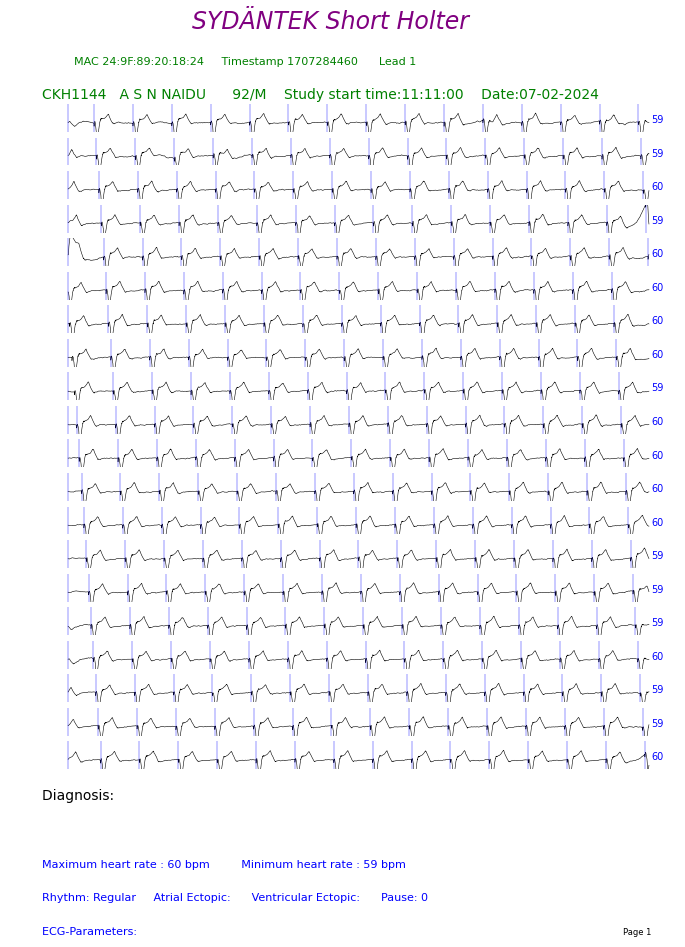

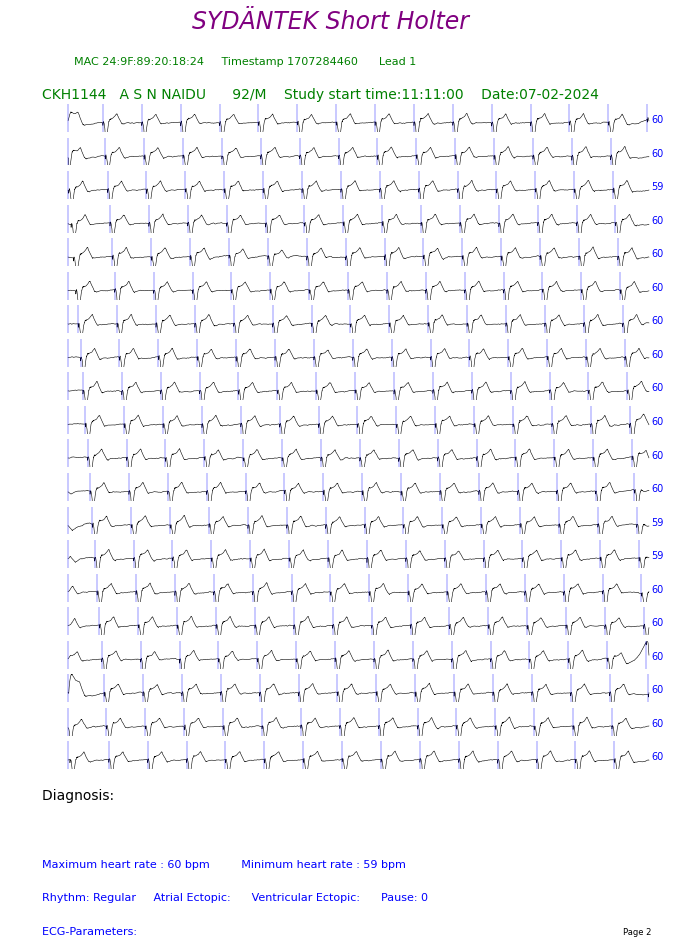

In [ ]:
def ecg_filters_V5_smooth(lead_data):  #### According to IEC 60601-2-25 (BW, 50, 100 and LP) with smoothing
  for x in  range(1,len(lead_data),1):
      if (lead_data[x] == 0):
       lead_data[x] = lead_data[x-1]

 ##### Baseline filter without ST Segment distortion
  b = signal.firwin(2377, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
  #b = signal.firwin(1735, cutoff = [0.67/500], window = "hamming", pass_zero=False); a = 1
 ##### Powerline noise and its harmonics removal
  Fs = 1000; F0 = 50; F1 = F0*2; r = 1 -((3.14*2)/1000); W0 = (2*3.14*F0)/Fs; W1 = (2*3.14*F1)/Fs
  d0 = 1; d1 = -2*(np.cos(W0)); d2 = 1; c2 = 1; c1 = -2*r*(np.cos(W0)); c0 = r * r; d = [d2, d1, d0]; c = [c2, c1, c0]
  f0 = 1; f1 = -2*(np.cos(W1)); f2 = 1; e2 = 1; e1 = -2*r*(np.cos(W1)); e0 = r * r; f = [f2, f1, f0]; e = [e2, e1, e0]
 ##### 150Hz Low pass filter
  h, g = signal.butter(1, [40/500] , btype='low', analog=False)
  j, i = signal.butter(1, [7/500] , btype='low', analog=False)

  filt_BW = signal.filtfilt(b, a, lead_data); filt_SM = (signal.lfilter(j, i, filt_BW))*0.000286;
  filt_LP = (signal.lfilter(h, g, filt_BW))*0.000286

  sparse = filt_LP - filt_SM;
  denoise = condat_tv.tv_denoise(sparse,7.65)
  smooth_data = filt_SM+denoise

  return smooth_data


def Rhythm_Check_ver2(lead_data, iteration):
  _,RR_int = RR_calculation11(lead_data)
  st_dev = np.std(RR_int); RC=0
  if (st_dev<130):
    # print("st_dev :", st_dev)
    ax[iteration].text(15500,0,'*',color='white',fontsize=10);
    RC = RC
    # return(1);# print('Regular Rhythm')
  else:
    ax[iteration].text(15500,0,'*',color='red',fontsize=10);
    RC = RC+1; #print("Iregular st_dev :", st_dev, RR_int)
    # return(0);# print('Irregular Rhythm')
  return RC

def pace_pulse_loc(sig):
  sos = signal.butter(4, 100, 'hp', fs=1000, output='sos')
  HP = signal.sosfilt(sos,sig); mark = max(HP[1000:14500])
  peaks,rpeak = signal.find_peaks(HP,distance = 200,height= (mark/2))
  if mark > 4000:
    return peaks
  else:
    return []

def plotting_ver2(sig, iteration):
  # sig=data_loss(sig); # SV_len = 0; PV_len = 0; NB_len = 0
  sig, state = machine_diconnect_15sec(sig)
  # secs = len(sig)/Fs; samps = int(secs*100) ;  sig_disp = (sp.signal.resample(ecg_filters_V5_01(sig*0.000286), samps));
  if state==False:    ##no disconnect
    RC = Rhythm_Check_ver2(sig, iteration)
    # HR_line, Pause_line = HeartRate_parameters11(ecg_filters_Rpeak(sig))
    Rpeak, RR_int = RR_calculation11(ecg_filters_Rpeak(sig))
    HR_line, Pause_line = HeartRate_parameters11(Rpeak, RR_int,sig)
    # SVT_count, SVT_start, SVT_Stop = SVT_check(Rpeak, RR_int)
    HRV_line.append(HR_line[0]); MaxHR.append(HR_line[1]); MinHR.append(HR_line[2])
    # ax[iteration].plot(h,ecg_filters_Smooth_holter(sig)*1.5,'k',linewidth=0.4);
    ax[iteration].plot(h,ecg_filters_V5_smooth(sig)*0.8,'k',linewidth=0.4);
    pace_loc = pace_pulse_loc(sig)
    for i in range(0,len(pace_loc)):
      ax[iteration].axvline(x = pace_loc[i], color = 'blue', linestyle = '-',linewidth=0.3)
    # if SVT_count!=0:51
    #   for i in range(len(SVT_start)):
    #     ax[iteration].axvspan(SVT_start[i]+((iteration-2)*samples_per_line/1000)-50, SVT_Stop[i]+((iteration-2)*samples_per_line/1000)+50, alpha=0.2, color="yellow")
    # # ax[iteration].plot(sig_disp*1.5,'k',linewidth=0.4);
    if len(Pause_line[0])!=0:
      TotPause.append(Pause_line[0]);
    ax[iteration].text(15050,0,str(HR_line[0]),color='blue',fontsize=7);
  else:   ##disconnect
    ax[iteration].plot(h,sig,'k',linewidth=0.4);
    RC = 0
  return RC


# def Report_generation(Lead, Patient, MacId, Date, TS,HIS, Timestamp_per_line=1,lines_per_page=60, Noise_detection=True):
lines_per_page=20
Noise_detection=False
Timestamp_per_line=1
# read_lead = 'v5'
buff=fetch_lead(read_lead);


buff = collections.deque(Data_addidtion(buff, lines_per_page))
ect_buff =  np.array(buff)

page=0; line=[]; linecount=lines_per_page;
HRV_line =[]; TotPause =[]; MaxHR = []; MinHR = [];
RhythmCount = 0
countlen=len(buff); samples_per_line = 15000*Timestamp_per_line
_,time = get_time_from_timestamp(Timestamp)
HolterTitle = 'SYDÄNTEK Short Holter'; plot_header=("%s     %s    Study start time:%s    Date:%s"%(Name,Age,str(time),Date.at[0,'Date']))
plot_header_technical=("MAC %s     Timestamp %d      Lead %s"%(MacId,Timestamp,read_lead))

filtered = ectopic_filters(ect_buff)
peaks,rpeak = sp.signal.find_peaks(filtered,distance = 400,height=(max(filtered[1000:5000])/2))
com_width = round(Fs//(8)); start_p = peaks[1]-com_width; end_p = peaks[1]+com_width
template = filtered[start_p:end_p]
SV=[]; PV=[]; NB=[]
SV, PV, NB = find_ectopic(filtered, template)

while countlen!=0:
  plt.figure(page); fig, ax = plt.subplots(linecount+7,figsize=(8.27,11.69));
  ax[0].set_title(HolterTitle,color='purple', fontstyle='italic',fontsize=17); ax[0].text(0.1,0,plot_header_technical,fontsize=8, color='green')
  ax[0].set_yticklabels([]); ax[0].set_xticklabels([]); ax[0].axis('off')
  ax[1].text(0.05,0,plot_header,fontsize=10, color='green'); ax[1].set_yticklabels([]); ax[1].set_xticklabels([]); ax[1].axis('off')

  page_det = ("Page %d"%(page+1));
  Atrialcount = 0; Ventricularcount = 0; Tot_beat = 0;
  PV_len = 0; SV_len = 0
  for j in range(2,linecount+2):
    for i in range(samples_per_line):
      line.append(buff.popleft())
      countlen = countlen-1
    line=np.array(line); h = np.arange(0,len(line))
    if max(line[0:samples_per_line])!=2000:
      index = j-2+(20*page)
      #TS_print = str(TS.at[index,'All_Timestamp']) +"\n"+ str(Date.at[index,'All_Time'])
      #ax[j].text(-1500,0,str(TS_print),fontsize=5)
      # ax[j].text(-1700,0,str(TS.at[index,'All_Timestamp']),fontsize=5)
      if Noise_detection==True:
        if Noise_estimation(line)>=2: ##if sample is clean
          RhythmCount = RhythmCount + plotting_ver2(line, j);
          for n in SV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Atrialcount = Atrialcount+1
              if math.isnan(n)==False: SV_len = SV_len+1
          for n in PV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Ventricularcount = Ventricularcount+1
              if math.isnan(n)==False: PV_len = PV_len+1
        else: ## if sample is noisy
          l = 30; t = np.linspace(0, 1, samples_per_line, endpoint = True);
          line = deque(sp.signal.square(2*np.pi*l*t)*2); ax[j].plot(h,line,'k',linewidth=0.4);
      else:
        RhythmCount = RhythmCount + plotting_ver2(line, j);
        if Noise_estimation(line)>=2:
          for n in SV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Atrialcount = Atrialcount+1
              if math.isnan(n)==False: SV_len = SV_len+1
          for n in PV:
            if n>=((j-2)*samples_per_line)+(300000*page) and n<= (j*samples_per_line)+(300000*page):
              # ax[j].axvspan(n-((j-2)*samples_per_line)-(300000*page)-150, n-((j-2)*samples_per_line)-(300000*page)+150, alpha=0.2, color="green")
              # ax[j].text(15500,0,'*',color='red',fontsize=10);
              Ventricularcount = Ventricularcount+1
              if math.isnan(n)==False: PV_len = PV_len+1
    else:   ##end of ecg blank plot
      ax[j].plot(0);
    line=deque(line)
    ax[j].set_yticklabels([]); ax[j].set_xticklabels([]); ax[j].set_ylim(-4,8); ax[j].set_xlim(-1500,15050); ax[j].axis('off')
    k = j+1; line.clear()


  print('Atrial Ectopic :%d         Ventricular Ectopic :%d'%(Atrialcount,Ventricularcount))
  if RhythmCount>0 and RhythmCount<=5: rhy = str(RhythmCount)+' Irregular Timestamp';
  elif RhythmCount>5: rhy = 'Irregular ';
  else: rhy = 'Regular '
  if len(HRV_line)>=2: MAX = str(max(HRV_line)); MIN = str(min(HRV_line))
  # Ectopic_det = ('Rhythm : %s      Atrial Ectopic : %d       Ventricular Ectopic : %d' %(rhy, Atrialcount))
  Ectopic_det = ('Rhythm: %s    Atrial Ectopic:      Ventricular Ectopic:      Pause: %d'%(rhy,len(TotPause)))
  ax[k].text(0.05,0.1,"Diagnosis: ", horizontalalignment='left',ma='right',fontsize=10,color='black');ax[k].set_yticklabels([]);ax[k].set_xticklabels([]);ax[k].axis('off')
  # ax[k+1].text(0.05,0.1,"Irregular rhythm; Suggestive of Atrial Fibrillation", horizontalalignment='left',ma='right',fontsize=8,color='black')
  ax[k+1].set_yticklabels([]);ax[k+1].set_xticklabels([]);ax[k+1].axis('off')
  ax[k+2].text(0.05,0.1,("Maximum heart rate : %s bpm         Minimum heart rate : %s bpm"%(MAX,MIN)), horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+2].set_yticklabels([]);ax[k+2].set_xticklabels([]);ax[k+2].axis('off')
  ax[k+3].text(0.05,0.1,Ectopic_det, horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+3].set_yticklabels([]);ax[k+3].set_xticklabels([]);ax[k+3].axis('off')
  ax[k+4].text(0.05,0.1,"ECG-Parameters: ", horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+4].set_yticklabels([]);ax[k+4].set_xticklabels([]);ax[k+4].axis('off')
  # ax[k+4].text(0.05,0.1," ", horizontalalignment='left',ma='left',fontsize=8,color='blue');ax[k+4].set_yticklabels([]);ax[k+4].set_xticklabels([]);ax[k+4].axis('off')
  ax[k+4].text(1,0.1,page_det, horizontalalignment='right',ma='right',fontsize=6,color='black');#ax[k+5].set_yticklabels([]);ax[k+5].set_xticklabels([]);ax[k+5].axis('off')
  HRV_line.clear() ; TotPause.clear() ; MaxHR.clear(); MinHR.clear; EctopicCount_page=0
  page+=1;

  ### creating and storing PDF
  pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/"+Name+" "+Date.at[0,'Date']+"pacemaker_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/"+Name+" "+Date.at[0,'Date']+"_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/Long Holter/1 "+Name+" "+Date.at[0,'Date']+"pacemaker_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/24Hours/CKH0755 DR. MUHAMMED MAJEED/10_"+Name+"_"+Date.at[0,'Date']+"_holterV3.pdf")
  # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Carditek Report for Celara/Holter Report/Testing/"+Name+".pdf")
  # # pdf = matplotlib.backends.backend_pdf.PdfPages("/content/drive/MyDrive/Holter Report/Testing/"+Date.at[0,'Date']+"_"+Name+".pdf")
  for fig in range(1, plt.gcf().number + 1): pdf.savefig( fig, bbox_inches='tight',pad_inches=0.0 )
  pdf.close()


In [ ]:

################################
trialId = 'CKS1849'               ## CKcath011	Kalinga Reddy			E4:E1:12:C4:CD:E1	1650357225
name =  'LIDWIN'
age_gender = '63/F'
ts =  1697863575 + (15*0)
#macId = 'E4:E1:12:C4:CD:E1'
macId = '24:9F:89:20:18:24'
#His = 'Angiogram Resting ECG'
His = 'Resting ECG'
#His = 'Post Stress ECG'
# His = 'Post Ballon '
#####################################

Patient_Details1 = ("SYDÄNTEK 12 Lead High Frequency ECG : Limb Leads \n\nTrial ID :  %s \nName :  %s  \nTimestamp :  %d  \nMAC :  %s \nClinical History :  %s \n \n\n"%(trialId,name,ts,macId,His))
date,time = get_time_from_timestamp(ts)
ts_considered = 20; ts_used = 0
trialId = trialId.upper()
name = name.upper()

#file_name = str(trialId)
bufferloop = {}; fra = {}
buffer = client.fetch(macId,(ts))
frame =  buffer.frame
i1 = frame.i ; ii1 = frame.ii;iii1 = frame.iii;avr1 = frame.avr ;avl1 = frame.avl; avf1 = frame.avf; v11 = frame.v1; v21 = frame.v2; v31 = frame.v3 ; v41 = frame.v4 ; v51 = frame.v5*1.1 ; v61 = frame.v6

for z in range(1,ts_considered):
    t = ts+(15*z)
    bufferloop["buffer%s"%z] = client.fetch(macId,(t))
    if bufferloop["buffer%s"%z] == None:
      ts_used = ts_used + 1;
      break
    else:
      fra["frame%s"%z] =  bufferloop["buffer%s"%z].frame
      iz = fra["frame%s"%z].i; iiz = fra["frame%s"%z].ii; iiiz = fra["frame%s"%z].iii; avrz = fra["frame%s"%z].avr; avlz = fra["frame%s"%z].avl; avfz = fra["frame%s"%z].avf;
      v1z = fra["frame%s"%z].v1; v2z = fra["frame%s"%z].v2; v3z = fra["frame%s"%z].v3; v4z = fra["frame%s"%z].v4; v5z = fra["frame%s"%z].v5; v6z = fra["frame%s"%z].v6;

      i= np.concatenate((i1,iz)); i1=i; ii= np.concatenate((ii1,iiz)); ii1=ii; iii= np.concatenate((iii1,iiiz)); iii1=iii; avr= np.concatenate((avr1,avrz)); avr1=avr; avl= np.concatenate((avl1,avlz)); avl1=avl; avf= np.concatenate((avf1,avfz)); avf1=avf;
      v1= np.concatenate((v11,v1z)); v11=v1; v2= np.concatenate((v21,v2z)); v21=v2; v3= np.concatenate((v31,v3z)); v31=v3; v4= np.concatenate((v41,v4z)); v41=v4; v5= np.concatenate((v51,v5z)); v51=v5; v6= np.concatenate((v61,v6z)); v61=v6;
      ts_used = ts_used + 1;

i = dataloss(i); ii = dataloss(ii); iii = dataloss(iii);
avr = dataloss(avr); avl = dataloss(avl); avf = dataloss(avf);
v1 = dataloss(v1); v2 = dataloss(v2); v3 = dataloss (v3);
v4 = dataloss(v4); v5 = dataloss(v5); v6 = dataloss(v6);



#print(trialId)
#print(peak_len)



NameError: name 'dataloss' is not defined

# **HFECG**

# ***Packages and Functions***

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import scipy as sp
import math
import statistics as stat
# from scipy import signal as sp
from scipy.signal import hilbert, savgol_filter
import collections
from scipy import signal
from numpy import array, sign, zeros
from scipy.interpolate import interp1d
from scipy.stats import kurtosis
from scipy.stats import skew
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linspace
from PIL import Image, ImageDraw, ImageFont,ImageFilter
import datetime
from pytz import timezone
import statistics as st

arr = collections.deque()

def get_time_from_timestamp(timestamp):
  read_able = datetime.datetime.fromtimestamp(timestamp)
  now_asia = str(read_able.astimezone(timezone('Asia/Kolkata'))); #print(now_asia)
  year = now_asia[0:10]
  year = year[8:10]+"-"+year[5:7]+"-"+year[0:4]
  time = now_asia[11:19]
  return (year,time)

def bandpass(low, high, fs=1000, order=25):
    return sp.signal.butter(order, [low, high], fs=fs, btype='bandpass',
    #return sp.signal.cheby1(4, 1, [low, high], btype='bandpass', analog=True,
    output='sos')

def dataloss(data):
  for x in  range(1,len(data),1):
    if (data[x] ==0):
       data[x] = data[x-1]
  return data

def high_pass(sig):
  sos = sp.signal.butter(4, 100, 'hp', fs=1000, output='sos')
  filt = sp.sosfilt(sos,sig)
  return filt

def signal_average(raw,peaks, similarity, hf = 100):
  Fs =1000
  b = sp.signal.firwin(1735, cutoff = [0.80/500], window = "hamming", pass_zero=False); a = 1
  filt_BW = sp.signal.filtfilt(b, a, raw)

  sos1 = bandpass(0.05, 150, order=7)
  filtered = ((sp.sosfilt(sos1, filt_BW)))*0.000286

  com_width = round(Fs//(2.5)); com_width_h = Fs//5; sim_com = round(Fs//(10));
  ecg = np.zeros((peak_len,com_width*2)); start_p = np.empty([peak_len],dtype=int); end_p =np.empty([peak_len],dtype=int)
  sim_ecg = np.zeros((peak_len,sim_com*2)); sim_start_p = np.empty([peak_len],dtype=int); sim_end_p =np.empty([peak_len],dtype=int)

  count = 0; temp_ecg= sim_ecg[3]
  for i in  range(peak_len):
    #j=com_width
    sim_start_p[i] = peaks[i]-sim_com; sim_end_p[i] = peaks[i]+sim_com
    sim_ecg[i] = filtered[sim_start_p[i]:sim_end_p[i]]

  for j in  range(0,len(sim_ecg)):
    s = np.corrcoef(temp_ecg,sim_ecg[j]); s = s[0][1]
    #print(s)
    if s> similarity:
      arr.append(j); count = count +1

  newpeak = np.empty([len(arr)],dtype=int)
  for z in range(len(arr)):
    ch= arr.popleft()
    newpeak[z] = peaks[ch]

  peak_len_n = len(newpeak)

  ecg_n = np.zeros((peak_len_n,com_width*2)); ecg_HF = np.zeros((peak_len_n,com_width_h*2))
  start_p = np.empty([peak_len_n],dtype=int); end_p =np.empty([peak_len_n],dtype=int)

  start_h = np.empty([peak_len_n],dtype=int); end_h =np.empty([peak_len_n],dtype=int)
  Avg_ecg = np.zeros((1,com_width*2)); Avg_HF = np.zeros((1,com_width_h*2))

  sos = bandpass(hf, 450, order=6);  HFECG_filtered = ((sp.sosfilt(sos, raw)))*0.000286

  # Amp_sig = HFECG_filtered[newpeak[1]-sim_com:newpeak[1]+sim_com]; sig = max(Amp_sig);
  # if sig < 0.040:
  #   if hf == 100:
  #     sos = bandpass(80, 250, order=6);  HFECG_filtered = ((sp.sosfilt(sos, raw)))*0.000286
  #   elif hf == 150:
  #     sos = bandpass(100, 250, order=6);  HFECG_filtered = ((sp.sosfilt(sos, raw)))*0.000286

  for i in  range(count):
    #j=com_width
    start_p[i] = newpeak[i]-com_width; end_p[i] = newpeak[i]+com_width; ecg_n[i] = filtered[start_p[i]:end_p[i]]; Avg_ecg = (Avg_ecg + ecg_n[i])
    start_h[i] = newpeak[i]-com_width_h; end_h[i] = newpeak[i]+com_width_h; ecg_HF[i] = HFECG_filtered[start_h[i]:end_h[i]]; Avg_HF = (Avg_HF + ecg_HF[i])

  Avg_ecg = Avg_ecg/peak_len_n; Avg_HF = Avg_HF/peak_len_n

  Avg_ecg = np.transpose(Avg_ecg); data = Avg_ecg.flatten(); data = abs(data); ecg = np.transpose(ecg_n)
  Avg_HF = np.transpose(Avg_HF); ecg_HF = np.transpose(ecg_HF)

  Rpeak,Ramp = sp.signal.find_peaks(data, height=(max(data)/2));Rpeak = Rpeak[0]
  loc_on = Rpeak-40
  pc = data[loc_on]; pp = data[loc_on-1];c = 1;
  while pc>pp:
    pc=data[loc_on-c];pp=data[loc_on-c-1];c=c+1
  QRSON = loc_on-c

  loc_of = Rpeak+50
  pc = data[loc_of]; pn = data[loc_of+1];d = 1;
  while pc<pn:
    pc=data[loc_of+d];pn=data[loc_of+1+1];d=d+1
  QRSoff = loc_of+d
  # loc_on = Rpeak-40
  # pc = data[loc_on]; pp = data[loc_on-1];c = 1;
  # while pc>pp:
  #   pc=data[loc_on-c];pp=data[loc_on-c-1];c=c+1
  # QRSON = loc_on-c

  # loc_of = Rpeak+40
  # pc = data[loc_of]; pn = data[loc_of+1];d = 1;
  # while pc<pn:
  #   pc=data[loc_of+d];pn=data[loc_of+1+1];d=d+1
  # QRSoff = loc_of+d
  # QRSON_array=np.array(QRSON)
  # QRSoff_array=np.array(QRSoff)
  # R_loc_new=np.empty(len(Rpeak))
  # PR_array=np.empty(len(Rpeak))
  # for v in range(0,len(Rpeak)):
  #   R_loc_new[v]=Rpeak[v]-80
  #   PR_array[v]=np.mean(ecg[(R_loc_new[v]):(QRSON[v])])
  # mode_value=stat.mode(PR_array)
  # min=PR_array[0]
  # for z in range (0,len(PR_array)):
  #   if (PR_array[z]<min):
  #     min=PR_array[z]
  # New_loc_on=Rpeak-40
  # pc1=Rpeak-40
  # pc1 = data[New_loc_on]; pp1 = data[New_loc_on-1];c1 = 1;
  # while pc1>pp1>mode_value:
  #   pc1=data[New_loc_on-c1];pp1=data[New_loc_on-c1-1];c1=c1+1
  # New_QRSON = New_loc_on-c1

  # New_loc_of = Rpeak+40
  # pc1 = data[New_loc_of]; pn1 = data[New_loc_of+1];d1 = 1;
  # while pc1<pn1<mode_value:
  #   pc1=data[New_loc_of+d1];pn1=data[New_loc_of+1+1];d1=d1+1
  # New_QRSoff = New_loc_of+d1
  return Avg_ecg, Avg_HF, ecg, ecg_HF,peak_len_n,QRSON,QRSoff

def leadplot_ecg(ecg,data,QRSON,QRSoff,x,position):
  ecg.plot(data+position,linewidth=2,color = 'darkred');
  ecg.axvline(x = QRSON, color = 'k', linestyle = ':')
  ecg.axvline(x = QRSoff, color = 'k', linestyle = ':')
  ecg.set_yticklabels([]); ecg.set_xticklabels([]);
  #ecg.text(-34, 0.03, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  ecg.set_yticks(np.arange(-20, 20,5)); ecg.set_xticks(np.arange(0, 800, 200))
  ecg.set_ylim([-15.2,15]); ecg.set_xlim(0,820);
  ecg.title.set_text(x); ecg.grid(True);
  return

def leadplot_hf(hf,data):
  hf.plot((data*1),linewidth=1.5);
  hf.set_ylim([-0.22,0.20]); hf.grid(True);
  hf.set_yticklabels([]); hf.set_xticklabels([]);
  hf.set_xlim(51,350);
  return

##########   Display with downsamplaned Stem
def hf_envop(HF):
  S_Avg_co = HF.flatten(); s = S_Avg_co; q_u = zeros(s.shape)
  u_x = [0,]; u_y = [s[0],]
  for k in range(1,len(s)-1):
    if (sign(s[k]-s[k-1])==1) and (sign(s[k]-s[k+1])==1):u_x.append(k); u_y.append(s[k])
  u_x.append(len(s)-1); u_y.append(s[-1])
  #plt.figure(); plt.stem(u_y)
  for k in range(21,len(u_y)-1):
    if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  #plt.figure(); plt.stem(u_y)
  rp,rv = sp.find_peaks(u_y,height=(max(u_y)/3))
  if max(u_y)< 0.040:
    RAZ = 2
  else:
    if len(rp)==2:
      if abs(rp[0]-rp[1])>4:
        if ((round(((min(u_y[rp[0]:rp[1]]))*100)/max(u_y)))<40): RAZ = 4 ;# print('RAZ N')
        else: RAZ = 3 ; #print('RAZ AP')
      else: RAZ = 1 ; #print('RAZ A')
    else: RAZ = 0 ; #print("NO RAZ")
  # if RAZ == 0:
  #   for k in range(1,len(u_y)-1):
  #     if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  #   for k in range(1,len(u_y)-1):
  #     if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  #   for k in range(2,len(u_y)-2,2):
  #     if (u_y[k]<u_y[k-2]) and (u_y[k]<u_y[k+2]): u_y[k] = (u_y[k-2]+u_y[k+2])/2

  u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
  for k in range(0,len(s)):
      q_u[k] = u_p(k)
  t = np.arange(0, len(q_u), 1)
  return t,q_u, RAZ


def score(data,QRSON,QRSoff):
  ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
  data2 = (data[ON:OFF]);
  aben = round(np.sum(np.square(data2)),4)
  t,en, RAZ = hf_envop(data);
  #plt.plot(t,en)
  data = data.flatten();n_en = abs(en);
  RMS = np.round(((np.sqrt(np.mean(data[QRSON:QRSoff]**2)))*1000),1)
  kur = np.round(kurtosis(n_en[QRSON:QRSoff], axis=0, bias=True),1)
  return RAZ,RMS,kur,aben

def R_Peak_Detection_V3(data):    ## R peak detection with ectopic marking
  peaks_up = []; amp = [];
  # print(data)
  b = sp.signal.firwin(2377, cutoff = [2/500], window = "hamming", pass_zero=False);a= 1;
  h, g = sp.signal.butter(4, [45/500] , btype='low', analog=False)
  filt_BW = sp.signal.filtfilt(b, a, data); data_F = signal.lfilter(h, g, filt_BW)
  data_FS = data_F*data_F; data_D = np.diff(data_FS);
  peaks,rpeak = sp.signal.find_peaks(data_D,distance = 400,height=(max(data_D[1000:5000])/5));n = len(peaks);
  for i in range(0,n):
    win=70;
    if (peaks[i]-(win))<0: start_win = 0
    else: start_win = (peaks[i]-(win))
    seg = data_F[start_win:(peaks[i])+(win)]; seg2 = seg*seg;
    plt.plot(seg2)
    max_peak,peak_amp = sp.signal.find_peaks(seg2, distance = 10, height = (max(seg2)/2))
    #######################3
    peaks_u = start_win + max_peak[0]
    peaks_up.append(peaks_u);
  return peaks_up

def hf_envop(HF):
  S_Avg_co = HF.flatten(); s = S_Avg_co; q_u = zeros(s.shape)
  u_x = [0,]; uy = [s[0],];
  for k in range(1,len(s)-1):
    if (sign(s[k]-s[k- 1])==1) and (sign(s[k]-s[k+1])==1):u_x.append(k); uy.append(s[k])
  u_x.append(len(s)-1); uy.append(s[-1]);
  u_y = uy
  for k in range(0,len(uy)-2):
    if uy[k]<(max(uy)/1.5) and uy[k+1]<(max(uy)/1.5) and uy[k-1]<(max(uy)/1.5): u_y[k] = (uy[k-1]+uy[k+1])/2
    # if (uy[k]<uy[k-1]) and (uy[k]<uy[k+1]):
    #   if u_y[k] < (uy[k-1]+uy[k+1])/3:
    #     u_y[k] = (uy[k-1]+uy[k+1]+u_y[k])/2.8
    #   else:
    #     u_y[k] = (uy[k-1]+uy[k+1])/2
      #plt.figure(); plt.stem(u_y)
  rp,rv = sp.find_peaks(u_y,height=(max(u_y)/3));
  if max(u_y)< 0.020:
    RAZ = 4
  else:
    if len(rp)>=2:
      #arrange = np.sort(rp)[::-1]; print(arrange); primary = arrange[0]; secondary = arrange[1]; h = max(primary,secondary); l = min(primary, secondary);# print(primary); print(secondary)
      if ((np.round(((np.min(u_y[rp[0]:rp[1]]))*100)/np.max(u_y)))<40):
        if np.abs(rp[0]-rp[1])>2: RAZ = 3 ;# print('RAZ N')
        else:
          RAZ = 2 ; #print('RAZ AP')
          for k in range(1,len(u_y)-1):
            if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
      else:
        RAZ = 1 ; #print('RAZ A')
        for k in range(1,len(u_y)-1):
          if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
    else:
      RAZ = 0 ; #print("NO RAZ")
      for k in range(1,len(u_y)-1):
        if (u_y[k]<u_y[k-1]) and (u_y[k]<u_y[k+1]): u_y[k] = (u_y[k-1]+u_y[k+1])/2
  u_p = interp1d(u_x,u_y, kind = 'cubic',bounds_error = False, fill_value=0.0)
  for k in range(0,len(s)):
      q_u[k] = u_p(k)
  #q_u = sp.medfilt(q_u, kernel_size=19)
  # average_q_u = []
  # for ind in range(len(q_u)-9):
  #   average_data.append(np.mean(q_u[ind:ind+10]))
  #diff_u = np.diff(q_u)*10
  t = np.arange(0, len(q_u), 1)
  return t,q_u, RAZ

def leadplot_hf(hf,data,peak,QRSON,QRSoff):
  Zoom = 2.5
  if peak > 10:
    ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
    data1 = (data[0:ON])*0.3; data2 = (data[ON:OFF]); data3 = (data[OFF:400])*0.3;
    data = np.concatenate((data1,data2,data3));
    data_P = np.concatenate((data1,data2,data3));
    for i in range(len(data_P)):
      if data_P[i] < 0:
        data_P[i] = data_P[i]*[-1]
    zcr = 0;
    # for i in range(1, len(data_P)):
    #   if data_P[i] * data_P[i - 1] < 0: zcr += 1
    # zcr = (zcr / len(data2))  ############# Zero Crossing
    aben = np.round(np.sum(np.square(data2)),4)  #############  absolute energy
    t,en, RAZ = hf_envop(data_P); data = data.flatten();
    RMS = np.round(((np.sqrt(np.mean(data2**2)))*1000),3)      ##############  RMS Voltage
    hfp = np.round(np.max(data)*1000)   ###########    Amplitude of HFECG
    variance = np.round(np.var(data2),4)
    kur = np.round(np.abs(kurtosis(en[ON:OFF], axis=0, bias=True)),3)

    en_r = sp.resample(data_P*Zoom, 100); t_r = np.linspace(0,100,100);
    hf.axvline(x = ON, color = 'k', linestyle = ':')
    hf.axvline(x = OFF, color = 'k', linestyle = ':')
    # if RAZ == 0: hf.text(7, 0.80, "RAZ Grade : 0",color='g',size=17,fontweight='bold');# hf.text(2, 0.65, "RAZ Score = 0 ",color='brown',size=13)
    # elif RAZ == 1: hf.text(7, 0.80, "RAZ Grade : 1",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 2 ",color='brown',size=13)
    # elif RAZ == 2: hf.text(7, 0.80, "RAZ Grade : 2",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 5 ",color='brown',size=13)
    # elif RAZ == 3: hf.text(7, 0.80, "RAZ Grade : 3",color='orange',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 5 ",color='brown',size=13)
    # elif RAZ == 4: hf.text(7, 0.80, "RAZ Grade : 4",color='red',size=17,fontweight='bold'); #hf.text(2, 0.65, "RAZ Score = 9 ",color='brown',size=13)
    hf.text(7, 0.67, "Peak Activation = "+str(np.argmax(data))+"mS",color='brown',size=15)
    hf.text(7, 0.57, "HF Amp = "+str(hfp)+"uV",color='brown',size=15)
    hf.text(7, 0.47, "Energy = "+str(aben),color='brown',size=15)
    hf.text(7, 0.37, "Variance = "+str(variance),color='brown',size=15)
    hf.text(7, 0.27, "Kurtosis = "+str(kur),color='brown',size=15)
    hf.text(7, 0.17, "RMS = "+str(RMS)+"uV",color='brown',size=15)
    hf.title.set_text('QRS(ms):'+str(QRSoff-QRSON));
    #hf.stem(en_r*Zoom, markerfmt=' ');
    #hf.bar(t_r, (en_r*Zoom), width = 0.75, color='#069AF3', alpha=0.9);
    hf.plot((data*Zoom*2));
    #hf.plot((data_P*Zoom*2));
    hf.plot(en*Zoom*2,linewidth=1.5);#plt.grid(True);
    hf.fill_between(t, en*Zoom*2,alpha=0.30,color='green')
  else:
    hf.plot(0);
    hf.text(45, 0.6, "INSUFFICIENT DATA", bbox=dict(facecolor='red', alpha=0.5))
  hf.set_yticklabels([]); hf.set_xticklabels([]);#hf.axis('off')
  hf.text(-130.50, -0.35, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  hf.set_yticks(np.arange(-1.90, 1.90,0.10)); hf.set_xticks(np.arange(0, 400,12))
  hf.set_xlim(0,400);hf.set_ylim(-0.40,0.90);
  hf.grid(True);
  return

def leadplot_hf_bar(hf,data,peak,QRSON,QRSoff):
  Zoom = 2
  if peak > 10:
    t,en, RAZ = hf_envop(data);
    data = data.flatten();n_en = abs(en);
    en_r = sp.resample(en*Zoom, 100); t_r = np.linspace(0,100,100);
    data = data*Zoom
    ON = int((QRSON/2)-25); OFF = int((QRSoff/2)+17+25)
    data1 = (data[0:ON])*0.3; data2 = (data[ON:OFF]); data3 = (data[OFF:400])*0.3;
    data = np.concatenate((data1,data2,data3));
    data_P = np.concatenate((data1,data2,data3));
    pri_peak = np.argmax(en);pri_m = max(en);
    sec_peak1,pv1 = sp.find_peaks(en[pri_peak:pri_peak+50],height=(np.max(en)/2));sec_peak1 = sec_peak1+pri_peak
    sec_peak2,pv2 = sp.find_peaks(en[pri_peak-50:pri_peak],height=(np.max(en)/2));sec_peak2 = (pri_peak-50)+sec_peak2

    sec_peak = np.concatenate((sec_peak2,sec_peak1)); sec_a= []
    dip_a = []
    if len(sec_peak)> 0:
      for m in range (len(sec_peak)):
        n = sec_peak[m]; sec_a.append(en[n]);
      sec_a = array(sec_a); sec_a = np.max(sec_a); ############# Check the location of Sec peak
      sec = np.argmax(sec_a); sec_peak = sec_peak[np.argmax(sec_a)]
      if pri_peak < sec_peak:
        dip_a = np.round(np.min(en[pri_peak:sec_peak]),4);
        hf.text(21, 1.27, "RAZ Duration = "+str(sec_peak-pri_peak)+"mS",color='brown',size=15)
      else:
        dip_a = np.round(np.min(en[sec_peak:pri_peak]),4);
        hf.text(21, 1.27, "RAZ Duration = "+str(pri_peak-sec_peak)+"mS",color='brown',size=15)
      hf.text(21, 1.17, "RAZ Amplitude = "+str(dip_a)+"uV",color='brown',size=15)
      per = 100- np.round(((dip_a*100)/pri_m),2)
      hf.text(21, 1.07, "Percentage of Drop = "+str(per)+"%",color='brown',size=15)
    ON = int(QRSON/4); OFF = int(QRSoff/7)
    hf.axvline(x = ON, color = 'k', linestyle = ':')
    hf.axvline(x = OFF, color = 'k', linestyle = ':')
    hf.title.set_text('QRS(ms):'+str(QRSoff-QRSON));
    hf.bar(t_r, (en_r*Zoom*1.5), width = 0.75, color='#069AF3', alpha=0.9);
  else:
    hf.plot(0);
    hf.text(45, 0.6, "INSUFFICIENT DATA", bbox=dict(facecolor='red', alpha=0.5))
  hf.set_xticks(np.arange(0, 400,1.5))
  hf.set_yticklabels([]); hf.set_xticklabels([]);#hf.axis('off')
  hf.text(0, 0.03, str(peak)+" QRS Complex",color='k',size=10, weight='bold');
  hf.set_xlim(20,80);
  hf.set_yticks(np.arange(-0.10, 1.90,0.10));hf.set_ylim(0,1.40);
  hf.grid(True);
  return

# **Reading Data**

# **Displaying Result**

In [ ]:
peaks = R_Peak_Detection_V3(v6)
peaks = peaks[1:len(peaks)-1];peak_len = len(peaks);

square_similarity = 0.90; chest_similarity = 0.97
#v3 = v2*1.2;
#v4 = v5*1.1;
LL = 140; CL = 150
i_aecg, i_aHF, iecg, iecg_HF,pi,ni,fi = signal_average(i,peaks,0.85, hf=LL)
ii_aecg, ii_aHF, iiecg, iiecg_HF,pii,nii,fii = signal_average(ii,peaks,square_similarity, hf=LL)
iii_aecg, iii_aHF, iiiecg, iiiecg_HF,piii,niii,fiii = signal_average(iii,peaks, 0.70, hf=LL)
r_aecg, r_aHF, recg, recg_HF,pr,nr,fr = signal_average(avr,peaks,0.70, hf=LL)
l_aecg, l_aHF, lecg, lecg_HF,pl,nl,fl = signal_average(avl,peaks,0.70, hf=LL)
f_aecg, f_aHF, fecg, fecg_HF,pf,nf,ff = signal_average(avf,peaks,square_similarity, hf=LL)
v1_aecg, v1_aHF, v1ecg, v1ecg_HF,p1,n1,f1 = signal_average(v1,peaks,0.96, hf=CL)
v2_aecg, v2_aHF, v2ecg, v2ecg_HF,p2,n2,f2 = signal_average(v2,peaks,0.96, hf=CL)
v3_aecg, v3_aHF, v3ecg, v3ecg_HF,p3,n3,f3 = signal_average(v3,peaks,chest_similarity, hf=CL)
v4_aecg, v4_aHF, v4ecg, v4ecg_HF,p4,n4,f4 = signal_average(v4,peaks,chest_similarity, hf=CL)
v5_aecg, v5_aHF, v5ecg, v5ecg_HF,p5,n5,f5 = signal_average(v5,peaks,chest_similarity, hf=CL)
v6_aecg, v6_aHF, v6ecg, v6ecg_HF,p6,n6,f6 = signal_average(v6,peaks,chest_similarity, hf=CL)

sec = ts_used/4; HR = np.round(peak_len/sec)

Patient_Details1 = ("Patient ID :  %s \nName :  %s  \nTimestamp :  %d  \nMAC :  %s \nECG Type :  %s \n \n\n"%(trialId,name,ts,macId,His))
HF_Parameters = ("RAZ Score:  %s \nHFECG Amplitude:  %s  \nHFQRS Duration:  %d  \nRMS :  %s \nClinical History :  %s \n \n\n"%(trialId,name,ts,macId,His))

figure = plt.figure(figsize=(32.04,22.92))
row_num = 6; col_num = 12

patient = plt.subplot2grid((row_num, col_num), (0, 0), rowspan=2, colspan=4)
parameter = plt.subplot2grid((row_num, col_num), (2,0), rowspan=2, colspan=4)
sig = plt.subplot2grid((row_num, col_num), (5,0), colspan=4)

ia = plt.subplot2grid((row_num, col_num), (0, 4), colspan=1); ihf = plt.subplot2grid((row_num, col_num), (0, 5), colspan=3);
iia = plt.subplot2grid((row_num, col_num), (1, 4), colspan=1); iihf = plt.subplot2grid((row_num, col_num), (1, 5), colspan=3)
iiia = plt.subplot2grid((row_num, col_num), (2, 4), colspan=1); iiihf = plt.subplot2grid((row_num, col_num), (2, 5), colspan=3)
ra = plt.subplot2grid((row_num, col_num), (3, 4), colspan=1); rhf = plt.subplot2grid((row_num, col_num), (3, 5), colspan=3)
la = plt.subplot2grid((row_num, col_num), (4, 4), colspan=1); lhf = plt.subplot2grid((row_num, col_num), (4, 5), colspan=3)
fa = plt.subplot2grid((row_num, col_num), (5, 4), colspan=1); fhf = plt.subplot2grid((row_num, col_num), (5, 5), colspan=3)

v1a = plt.subplot2grid((row_num, col_num), (0, 8), colspan=1); v1hf = plt.subplot2grid((row_num, col_num), (0, 9), colspan=3);
v2a = plt.subplot2grid((row_num, col_num), (1, 8), colspan=1); v2hf = plt.subplot2grid((row_num, col_num), (1, 9), colspan=3)
v3a = plt.subplot2grid((row_num, col_num), (2, 8), colspan=1); v3hf = plt.subplot2grid((row_num, col_num), (2, 9), colspan=3)
v4a = plt.subplot2grid((row_num, col_num), (3, 8), colspan=1); v4hf = plt.subplot2grid((row_num, col_num), (3, 9), colspan=3)
v5a = plt.subplot2grid((row_num, col_num), (4, 8), colspan=1); v5hf = plt.subplot2grid((row_num, col_num), (4, 9), colspan=3)
v6a = plt.subplot2grid((row_num, col_num), (5, 8), colspan=1); v6hf = plt.subplot2grid((row_num, col_num), (5, 9), colspan=3)


HF_sig = [i_aHF,ii_aHF,iii_aHF,r_aHF, l_aHF, f_aHF, v1_aHF, v2_aHF, v3_aHF, v4_aHF, v5_aHF, v6_aHF]
on = [ni, nii, niii, nr, nl, nf, n1, n2, n3, n4, n5, n6]
off = [fi, fii, fiii, fr, fl, ff, f1, f2, f3, f4, f5, f6]
RAZ = []; RMS = []; KUR = []; ENG = []

for t in range(len(HF_sig)):
  RA, RM, KU,EN = score(HF_sig[t],on[t],off[t]);
  RAZ.append(RA)
  RMS.append(RM)
  KUR.append(KU)
  ENG.append(EN)

print(RAZ)
print(RMS)
print(KUR)
print(ENG)


IScon = round(st.mean(RAZ[6:11]),3)
RMS = round(st.mean(RMS[6:11]),3)
KUR = abs(round(st.mean(KUR[6:11]),3))
ENG = round(st.mean(ENG),4)

HR = ('%d bpm'%int(HR))
patient.text(0.5, 0.9, "Sydäntek Digital ECG",fontsize=35, ha = 'center', style = 'italic');
patient.text(0.99,0.5, (date+"\n"+time+"\n\n Calibration:\n ECG X-axis:200mS/Sq\n    Y-axis:500uV/Sq\n HFECG X-axis:5mS/Sq\n       Y-axis:10uV/Sq"),fontsize=16, ha = 'right');
#patient.text(0.99,0.5, (date+"\n"+time+"\n\n,fontsize=16, ha = 'right');
patient.text(0.02, 0.38, Patient_Details1, fontsize=22, ha = 'left');
patient.text(0.02,0.32, HR,fontsize=55,ha = 'left')

patient.axis('off')

columnLabels = ['Measured\n Value','Reference\n Value']
rowLabels = ['RAZ','RMS Value','Kurtosis Value']

N1 = ' Normal: 0 to 2\n Moderate: 2 to 3\n Severe: 3 to 4';
N2 = '  Normal: > 3.48\n Moderate: 2.49 to 3.48\n Severe: < 2.49 ';N3 = '  Normal: < 0.67\n Moderate: 0.68 to 0.83\n Severe: > 0.95'
tableValues = [[IScon, N1], [RMS, N2], [KUR, N3]]
ccolors = np.full(3, 'linen')
table = parameter.table(cellText=tableValues,colWidths=[.2,.1,.1],rowLabels=rowLabels,colLabels=columnLabels,rowLoc='center', colColours=ccolors, bbox = [0.3, 0.03, 0.68, 0.95])
table.auto_set_font_size(False)
table.auto_set_column_width(col=list(range(len(tableValues))))
table.set_fontsize(20); table.scale(2, 8); parameter.axis('off')

sig.text(0.5, 0.0, "Dr. Sugandhi Gopal\n MBBS(CMC Vellore), MRCP(UK)\n Consultant Interventional Cardiologist  " , fontsize=20, ha = 'center'); sig.axis('off')
#sig.text(0.5, 0.0, "King George's Medical University" , fontsize=20, ha = 'center'); sig.axis('off')

###### Averaged ECG
leadplot_ecg(ia,i_aecg,ni,fi,'Lead 1',(0));leadplot_ecg(iia,ii_aecg,nii,fii,'Lead 2',(0))
leadplot_ecg(iiia,iii_aecg,niii,fiii,'Lead 3',(0));leadplot_ecg(ra,r_aecg,nr,fr,'aVr',(0))
leadplot_ecg(la,l_aecg,nl,fl,'aVl',(0));leadplot_ecg(fa,f_aecg,nf,ff,'aVf',(0))

leadplot_ecg(v1a,v1_aecg,n1,f1,'V1',(5));leadplot_ecg(v2a,v2_aecg,n2,f2,'V2',(5))
leadplot_ecg(v3a,v3_aecg,n3,f3,'V3',(0));leadplot_ecg(v4a,v4_aecg,n4,f4,'V4',(-3))
leadplot_ecg(v5a,v5_aecg,n5,f5,'V5',(-5));leadplot_ecg(v6a,v6_aecg,n6,f4,'V6',(-5))

############ averaged HFECG
leadplot_hf_bar(ihf,i_aHF,pi,ni,fi);leadplot_hf_bar(iihf,ii_aHF,pii,nii,fii);
leadplot_hf_bar(iiihf,iii_aHF,piii,niii,fiii);leadplot_hf_bar(rhf,r_aHF,pr,nr,fr);
leadplot_hf_bar(lhf,l_aHF,pl,nl,fl);leadplot_hf_bar(fhf,f_aHF,pf,nf,ff);

leadplot_hf_bar(v1hf,v1_aHF,p1,n1,f1);leadplot_hf_bar(v2hf,v2_aHF,p2,n2,f2);
leadplot_hf_bar(v3hf,v3_aHF,p3,n3,f3);leadplot_hf_bar(v4hf,v4_aHF,p4,n4,f4);
leadplot_hf_bar(v5hf,v5_aHF,p5,n5,f5);leadplot_hf_bar(v6hf,v6_aHF,p6,n6,f6);

# figure.savefig((results+trialId+'_V6_3_s.pdf'),bbox_inches='tight',pad_inches=0.25)

AttributeError: ignored

# 12 Lead QRS Sectrogram

In [ ]:
Fs=1000
# CKT001	MAHESH NARAYAN	58	M	24:9F:89:20:18:28	1663646640	1663646640
# CKT002	MANJUNATH KALAL	50	M	24:9F:89:20:18:28	1663649925	1663650165


trialId = ''
name =  "Deepthu Mathur"
age_gender = ''
ts=1699249290 +(15*1)
date,time = get_time_from_timestamp(ts)
macId = '24:9F:89:20:18:0C'
# macId = '24:9F:89:20:18:28'

###Starting Point of ECG Segment
start = 1000

Patient_Details = ("Name :  %s  \nID :  %s \nAge and gender:  %s  \nTimestamp :  %d  \nMAC: %s\n"%(name,trialId,age_gender,ts,macId))
file_name = str(trialId)

buffer = client.fetch(macId,ts)
frame = buffer.frame;

Lead1 = frame.i;Lead2 = frame.ii; v1 = frame.v1; v2 = frame.v2;v3 = frame.v3;v4 = frame.v4;v5 = frame.v5;v6 = frame.v6    ##############    to add V6 enter V5 Here


x1 = 1300
x2 = x1+1000

fig, ((ax1, ax2, ax3),(ax4, ax5, ax6),(ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15), (ax16, ax17, ax18)) = \
plt.subplots(6, 3, figsize=(10,15), gridspec_kw={'height_ratios': [1.3, 1, 1.3, 1, 1.3, 1]})
fig.subplots_adjust(hspace=1)
fig.suptitle(Patient_Details,fontsize=15,ha = 'left', y=1.11, x=0.04)
#------------- ECG plot -------------#
Lead3=Lead2-Lead1
ecgplot(ax1,Lead1,'Lead 1'); ecgplot(ax7,Lead2,'Lead 2'); ecgplot(ax13,Lead3,'Lead 3')
ecgplot(ax2,Leadv1,'V1'); ecgplot(ax8,Leadv2,'V2'); ecgplot(ax14,Leadv3,'V3')
ecgplot(ax3,Leadv4,'V4'); ecgplot(ax9,Leadv5,'V5'); ecgplot(ax15,Leadv6,'V6')
#------------- Spectrogram Plot -------------#
scalogram_qrs(ax4,Lead1,'Scalogram of lead 1'); scalogram_qrs(ax10,Lead2,'Scalogram of lead 2'); scalogram_qrs(ax16,Lead3,'Scalogram of lead 3')
scalogram_qrs(ax5,Leadv1,'Scalogram of lead v1'); scalogram_qrs(ax11,Leadv2,'Scalogram of lead v2'); scalogram_qrs(ax17,Leadv3,'Scalogram of lead v3')
scalogram_qrs(ax6,Leadv4,'Scalogram of lead v4'); scalogram_qrs(ax12,Leadv5,'Scalogram of lead v5'); scalogram_qrs(ax18,Leadv6,'Scalogram of lead v6')
plt.tight_layout()

plt.savefig(('/content/drive/MyDrive/Carditek Report for Celara/QRS Scalogram/'+trialId+'_'+name+'_'+date+'QRS.tif'), bbox_inches='tight')


AttributeError: ignored

# 12 Lead report for 502 error